# Documentation
**Author:** Spencer Ressel

**Created:** August 16th, 2024

***

This notebook analyzes aqua-planet simulation data from the CAM6 model run by Mu-Ting Chien. 
Specifically, MJO diagnostics are computed following the specifications listed by the CLIVAR Madden-Julian Oscillation Working Group (MJOWG).
For details, see https://atmos.uw.edu/~daehyun/mjo_diagnostics/

***

# Imports

In [4]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
# Aquaplanet analysis config file
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# File management
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Data anaylsis
import numpy as np
import scipy
import xarray as xr
# import xeofs
xr.set_options(keep_attrs=True)
import scipy.signal as signal
from scipy.stats import t

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from cartopy import util as cutil
from plotting_functions import *

# Auxiliary functions
sys.path.insert(0, "/glade/u/home/sressel/thesis-work/python/auxiliary_functions/")
from load_aquaplanet_data import *
from processing_functions import *
from standardize_data import standardize_data
from modified_colormap import modified_colormap
from bmh_colors import bmh_colors
from one_two_one_filter import one_two_one_filter
from tick_labeller import tick_labeller
from rounding_functions import round_out

print("Imports loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading imports...
Imports loaded


# Specify analysis parameters

In [5]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]

START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 0
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load data

In [6]:
reload_variables = True

variables_to_load = [
    "Precipitation",
    # "Outgoing Longwave Radiation",
    "Zonal Wind",
    "Meridional Wind",
    # "Vertical Wind",
    # "Temperature",
    # "Moisture",
    # "Relative Humidity",
    # "Geopotential Height",
    # "Longwave Heating Rate",
    # "Shortwave Heating Rate",
    # "Latent Heat Flux",
    # "Sensible Heat Flux",
    # "Surface Pressure",
    "Moist Static Energy",
    "Dry Static Energy",
    # "Column Moist Static Energy",
    # "Column Water Vapor",
    # "Column Temperature",
    # "Column Longwave Heating",
    # "Column Shortwave Heating",
    # "Potential Temperature",
    # "Saturation Specific Humidity"
    # "Column Relative Humidity",
    # "Diabatic Heating",
    # "Chikira alpha"
    # "Surface Longwave Flux",
    # "Surface Shortwave Flux",
    # "TOA Longwave Flux",
    # "TOA Shortwave Flux",
    # "Net Longwave Flux",
    # "Net Shortwave Flux",
]

# if reload_variables or 'variables_dict' not in globals():
#     variables_dict = load_aquaplanet_data(variables_to_load, experiment_to_load)
# else:
#     new_variables_dict = load_aquaplanet_data(variables_to_load, experiment_to_load)

#     # If not reloading, append new variables to existing dict
#     for variable_name, variable_data in new_variables_dict.items():
#         if variable_name not in variables_dict.keys():
#             print(f"Adding {variable_name} to Active Variables...", end="")
#             variables_dict[variable_name] = variable_data
#             print(rf"{'✔':>1}")

# print('=' * str_width)
# print(f"\nActive Variables:")
# print("\n".join([key for key in variables_dict.keys()]))

# Load pre-processed data

## Subset data

In [7]:
if not 'multi_experiment_variables_subset' in locals():
    multi_experiment_variables_subset = load_multi_experiment_processed_data(
        variables_to_load,
        'subset'
    )
else:
    multi_experiment_variables_subset = load_multi_experiment_processed_data(
        variables_to_load,
        'subset',
        multi_experiment_variables_subset,
        False
    )

          Loading subset data           
(1/5) Precipitation...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(2/5) Zonal Wind...                     
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(3/5) Meridional Wind...                
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(4/5) Moist Static Energy...            
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                

In [9]:
column_zonal_MSE = (100/9.8)*(
    multi_experiment_variables_subset['Moist Static Energy']
    * multi_experiment_variables_subset['Zonal Wind']
).sel(plev=slice(100, 975)).integrate('plev')

column_zonal_DSE = (100/9.8)*(
    multi_experiment_variables_subset['Dry Static Energy']
    * multi_experiment_variables_subset['Zonal Wind']
).sel(plev=slice(100, 975)).integrate('plev')

column_meridional_MSE = (100/9.8)*(
    multi_experiment_variables_subset['Moist Static Energy']
    * multi_experiment_variables_subset['Meridional Wind']
).sel(plev=slice(100, 975)).integrate('plev')

column_meridional_DSE = (100/9.8)*(
    multi_experiment_variables_subset['Dry Static Energy']
    * multi_experiment_variables_subset['Meridional Wind']
).sel(plev=slice(100, 975)).integrate('plev')

zonal_column_MSE_advection = (180/np.pi)*(column_zonal_MSE).differentiate('lon') / (EARTH_RADIUS*np.cos(np.deg2rad(column_zonal_MSE.lat)))
zonal_column_DSE_advection = (180/np.pi)*(column_zonal_DSE).differentiate('lon') / (EARTH_RADIUS*np.cos(np.deg2rad(column_zonal_DSE.lat)))
meridional_column_MSE_advection = (180/np.pi)*(column_meridional_MSE).differentiate('lat') / EARTH_RADIUS
meridional_column_DSE_advection = (180/np.pi)*(column_meridional_DSE).differentiate('lat') / EARTH_RADIUS

GMS = (zonal_column_MSE_advection + meridional_column_MSE_advection)/(zonal_column_DSE_advection + meridional_column_DSE_advection)
print("Finished")

Finished


In [34]:
# np.where(np.isnan(multi_experiment_variables_subset['Zonal Wind']))
multi_experiment_variables_subset['Zonal Wind'].sel(lat=slice(-30, 30), plev=slice(100, 975), time=first_half_subset_bounds)

<xarray.DataArray 'Zonal Wind' (experiment: 3, time: 1493, lat: 32, lon: 144,
                                plev: 36)> Size: 6GB
array([[[[[ 2.86853660e+01,  3.23834032e+01,  3.43485183e+01, ...,
            2.59604237e+00,  2.25924240e+00,  1.93517552e+00],
          [ 2.70637892e+01,  3.33291872e+01,  3.30083646e+01, ...,
            1.92179631e+00,  1.65784012e+00,  1.41781927e+00],
          [ 2.52416460e+01,  3.35314074e+01,  3.23969037e+01, ...,
            1.28574355e+00,  1.03515912e+00,  8.17228391e-01],
          ...,
          [ 2.99372638e+01,  3.11021478e+01,  3.97030878e+01, ...,
            4.40264791e+00,  3.87006533e+00,  2.92282316e+00],
          [ 3.01597504e+01,  3.09423889e+01,  3.84484301e+01, ...,
            3.87518904e+00,  3.29399503e+00,  2.32938297e+00],
          [ 2.97043557e+01,  3.14240003e+01,  3.64225537e+01, ...,
            3.05117129e+00,  2.50950650e+00,  1.94802820e+00]],

         [[ 2.74124102e+01,  3.10649017e+01,  3.51276940e+01, ...,
           -2.61747160e+00, -2.91603132e+00, -3.16704444e+00],
          [ 2.60939243e+01,  3.24348459e+01,  3.36696171e+01, ...,
           -2.94045751e+00, -3.14138877e+00, -3.30332424e+00],
          [ 2.42360207e+01,  3.33147547e+01,  3.31000388e+01, ...,
           -3.07287706e+00, -3.27403452e+00, -3.43252545e+00],
...
          [ 4.55152532e+01,  5.35239120e+01,  5.72235927e+01, ...,
            1.93952191e+00,  1.59578837e+00,             nan],
          [ 4.72823709e+01,  5.64668775e+01,  6.08029749e+01, ...,
            3.10915997e+00,  2.77057591e+00,             nan],
          [ 4.89519003e+01,  5.96701845e+01,  6.46362290e+01, ...,
            3.69466607e+00,  3.32676174e+00,             nan]],

         [[ 4.54879843e+01,  5.61212379e+01,  6.16933875e+01, ...,
            6.31422605e+00,  5.99694347e+00,             nan],
          [ 4.70421618e+01,  5.93962417e+01,  6.57039509e+01, ...,
            5.88600012e+00,  5.53018630e+00,             nan],
          [ 4.84152410e+01,  6.24127089e+01,  6.93614667e+01, ...,
            4.52414578e+00,  4.12207172e+00,             nan],
          ...,
          [ 4.00464283e+01,  4.66783708e+01,  4.98891639e+01, ...,
            3.56443463e+00,  3.25636211e+00,             nan],
          [ 4.18936040e+01,  4.95176823e+01,  5.35323418e+01, ...,
            5.01896996e+00,  4.71961233e+00,             nan],
          [ 4.37446344e+01,  5.27490069e+01,  5.75566952e+01, ...,
            5.96788231e+00,  5.66259705e+00,             nan]]]]])
Coordinates:
  * plev        (plev) int64 288B 100 125 150 175 200 ... 875 900 925 950 975
  * lat         (lat) float64 256B -29.37 -27.47 -25.58 ... 25.58 27.47 29.37
  * lon         (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time        (time) object 12kB 0003-01-03 00:00:00 ... 0007-02-04 00:00:00
  * experiment  (experiment) <U3 36B '-4K' '0K' '4K'
Attributes:
    description:  Zonal Wind
    units:        m s$^{-1}$
    file_id:      U
    short_name:   U
    subset:       True

## Detrended data

In [10]:
if not 'multi_experiment_variables_detrended' in locals():
    multi_experiment_variables_detrended = load_multi_experiment_processed_data(
        variables_to_load,
        'detrended'
    )
else:
    multi_experiment_variables_detrended = load_multi_experiment_processed_data(
        variables_to_load,
        'detrended',
        multi_experiment_variables_detrended,
        False
    )

         Loading detrended data         
(1/3) Precipitation...                  
----------------------------------------
Variable already loaded
(2/3) Zonal Wind...                     
----------------------------------------
Variable already loaded
(3/3) Vertical Wind...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
----------------------------------------
Data Loaded


## Filtered data

In [ ]:
if not 'multi_experiment_variables_filtered' in locals():
    multi_experiment_variables_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'filtered'
    )
else:
    multi_experiment_variables_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'filtered',
        multi_experiment_variables_filtered,
        False
    )

## MJO-filtered

In [ ]:
if not 'multi_experiment_variables_mjo_filtered' in locals():
    multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'mjo_filtered'
    )
else:
    multi_experiment_variables_mjo_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'mjo_filtered',
        multi_experiment_variables_mjo_filtered,
        False
    )

## Rossby-filtered

In [ ]:
if not 'multi_experiment_variables_rossby_filtered' in locals():
    multi_experiment_variables_rossby_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'rossby_filtered'
    )
else:
    multi_experiment_variables_rossby_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'rossby_filtered',
        multi_experiment_variables_rossby_filtered,
        False
    )

## Kelvin-filtered

In [ ]:
if not 'multi_experiment_variables_kelvin_filtered' in locals():
    multi_experiment_variables_kelvin_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'kelvin_filtered'
    )
else:
    multi_experiment_variables_kelvin_filtered = load_multi_experiment_processed_data(
        variables_to_load,
        'kelvin_filtered',
        multi_experiment_variables_kelvin_filtered,
        False
    )

## Regressed data

In [5]:
print(f"{f'Loading regressed data':^{str_width}}")
# print(f"{'='*str_width}")
reference_variable = 'PRCP'
regression_wave_type = 'MJO'

reload_regressed = False
variable_data_by_experiment = {}
if not 'multi_experiment_variables_regressed' in globals() or reload_regressed:
    multi_experiment_variables_regressed = {}
if not 'multi_experiment_significant_indices' in globals() or reload_regressed:
    multi_experiment_significant_indices = {}

for index, variable_name in enumerate(variables_to_load):
    # Print the variable name
    print(f"{'='*str_width}")
    print(f"{f'({index+1}/{len(variables_to_load)}) {variable_name}...':<{str_width}}")
    print(f"{'-'*str_width}")

    # For each variable, loop over the experiments and find/load the data
    print("Loading data...")
    file_location = rf"/glade/campaign/univ/uwas0152/post_processed_data/multi_experiment_variables_regressed"
    regressed_files = glob.glob(
        f"{file_location}/multi_experiment_{variable_name.lower().replace(' ', '_')}"
        + f"_{regression_wave_type}-{reference_variable}.nc"
    )

    # Does the variable have data?
    if regressed_files:
        # Append it to the list
        for index, file in enumerate(regressed_files):
            regression_data = xr.open_dataset(file)
            print(f"{f'    Coefficients...':<{str_width-1}}", end="")
            multi_experiment_variables_regressed[variable_name] = regression_data[f"{variable_name} - Coefficients"]
            multi_experiment_variables_regressed[variable_name].name = variable_name
            print(rf"{'✔':>1}")

            print(f"{f'    Significant Indices...':<{str_width-1}}", end="")
            multi_experiment_significant_indices[variable_name] = regression_data[f"{variable_name} - Significance"]
            multi_experiment_significant_indices[variable_name].name = variable_name
            print(rf"{'✔':>1}")

    else:
        # Move on to the next variable
        print(rf"{'✘':>1}")
        print(f"    No data")

print(f"{'='*str_width}")
print("Finished")

         Loading regressed data         
(1/6) Precipitation...                  
----------------------------------------
Loading data...
    Coefficients...                    ✔
    Significant Indices...             ✔
(2/6) Outgoing Longwave Radiation...    
----------------------------------------
Loading data...
    Coefficients...                    ✔
    Significant Indices...             ✔
(3/6) Zonal Wind...                     
----------------------------------------
Loading data...
    Coefficients...                    ✔
    Significant Indices...             ✔
(4/6) Meridional Wind...                
----------------------------------------
Loading data...
    Coefficients...                    ✔
    Significant Indices...             ✔
(5/6) Vertical Wind...                  
----------------------------------------
Loading data...
    Coefficients...                    ✔
    Significant Indices...             ✔
(6/6) Column Water Vapor...             
------------------

# Percent Changes Relative to CTRL 

In [147]:
def title_with_plev(variable_data):
    if 'plev' in variable_data.coords:
        return f"{variable_data.plev.values:.0f}-hPa {variable_data.name.title()}"

    else:
        return f"{variable_data.name.title()}"

latitude_bounds_list = [(-30, 30), (-15, 15)]
experiments_to_plot = ['-4K', '4K']

percent_change = {}
temperature_change = {}

print("Percent Change Relative to CTRL")
print(f"{'='*str_width}")

for latitude_bounds in latitude_bounds_list:

    temperature_change[latitude_bounds] = xr.ufuncs.abs(
        multi_experiment_variables_subset['Temperature']
        - multi_experiment_variables_subset['Temperature'].sel(
            experiment='0K',
            lat=slice(*latitude_bounds)
        )
    ).mean(dim=['time', 'plev', 'lat', 'lon'])


for variable in [
    multi_experiment_variables_subset['Zonal Wind'].sel(plev=950),
    multi_experiment_variables_subset['Zonal Wind'].sel(plev=850),
    multi_experiment_variables_subset['Vertical Wind'].sel(plev=500),
    multi_experiment_variables_subset['Column Water Vapor'],
    multi_experiment_variables_subset['Precipitation'],
    multi_experiment_variables_subset['Latent Heat Flux'],
]:
    variable_id = title_with_plev(variable)
    percent_change[variable_id] = {}

    for latitude_bounds in latitude_bounds_list:
        percent_change[variable_id][latitude_bounds] = 100*(
            variable.sel(lat=slice(*latitude_bounds)).mean(dim=['time', 'lat', 'lon'])
            - variable.sel(experiment = '0K', lat=slice(*latitude_bounds)).mean()
        ) / xr.ufuncs.abs(variable.sel(experiment = '0K', lat=slice(*latitude_bounds)).mean())

Percent Change Relative to CTRL


In [176]:
for variable_id in percent_change.keys():
    print(f"##### {variable_id}")
    print(f"{'-4K':>18} {'+4K':>12}")
    for latitude_bounds in latitude_bounds_list:
        print(f"{tick_labeller([latitude_bounds[0]], 'lat', precision=0)[0]}-{tick_labeller([latitude_bounds[1]], 'lat', precision=0)[0]}: ", end="")
        for experiment in experiments_to_plot:
            print(
                f"{
                    (percent_change[variable_id][latitude_bounds]/temperature_change[latitude_bounds]).sel(experiment=experiment).values:>6.2f
                } %/K  ",
                end=""
            )
        print()

##### 950-hPa Zonal Wind
               -4K          +4K
30°S-30°N:   1.63 %/K   -0.37 %/K  
15°S-15°N:   0.57 %/K    0.38 %/K  
##### 850-hPa Zonal Wind
               -4K          +4K
30°S-30°N:   1.38 %/K    0.39 %/K  
15°S-15°N:   0.23 %/K    1.16 %/K  
##### 500-hPa Vertical Wind
               -4K          +4K
30°S-30°N:   7.83 %/K   -8.66 %/K  
15°S-15°N:  -0.97 %/K    2.25 %/K  
##### Column Water Vapor
               -4K          +4K
30°S-30°N:  -5.00 %/K    6.51 %/K  
15°S-15°N:  -5.16 %/K    6.54 %/K  
##### Precipitation
               -4K          +4K
30°S-30°N:  -2.28 %/K    2.11 %/K  
15°S-15°N:  -2.68 %/K    1.85 %/K  
##### Latent Heat Flux
               -4K          +4K
30°S-30°N:  -2.22 %/K    2.39 %/K  
15°S-15°N:  -1.98 %/K    1.76 %/K  


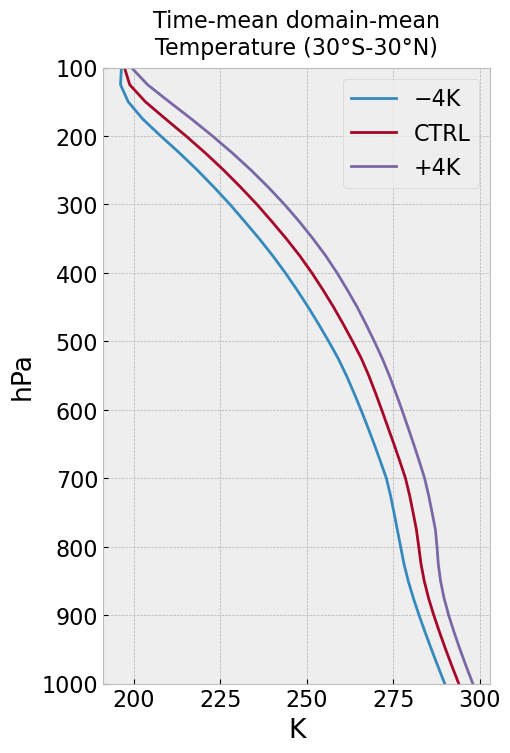

In [187]:
latitude_bounds = (-30,30)

variable_name = 'Temperature'
time_mean_domain_mean_variable = multi_experiment_variables_subset[variable_name].sel(
    lat=slice(*latitude_bounds)
).mean(dim=['time', 'lat', 'lon'])

plt.style.use('bmh')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 1, figsize=(5, 8))
ax.set_title(
    f"Time-mean domain-mean\n{variable_name}"
    + f" ({tick_labeller([latitude_bounds[0]], 'lat', precision=0)[0]}-{tick_labeller([latitude_bounds[1]], 'lat', precision=0)[0]})",
    fontsize=16,
    pad=10
)
for index, experiment in enumerate(experiments_list):
    ax.plot(
        time_mean_domain_mean_variable.sel(experiment=experiment),
        time_mean_domain_mean_variable.plev,
        color=bmh_colors(index+1),
        label=experiments_array.sel(experiment=experiment)['name'].item()
    )

if variable_name != 'Temperature':
    ax.axvline(x=0, ls=':', color='#bcbcbc')
    ax.set_xlim(left=1.1*time_mean_domain_mean_variable.min())

ax.set_xlabel(f"{time_mean_domain_mean_variable.attrs['units']}")
ax.set_yticks(np.arange(100, 1100, 100))
ax.set_ylim(100, 1000)
ax.invert_yaxis()
ax.set_ylabel(r"hPa")
ax.legend()
plt.show()

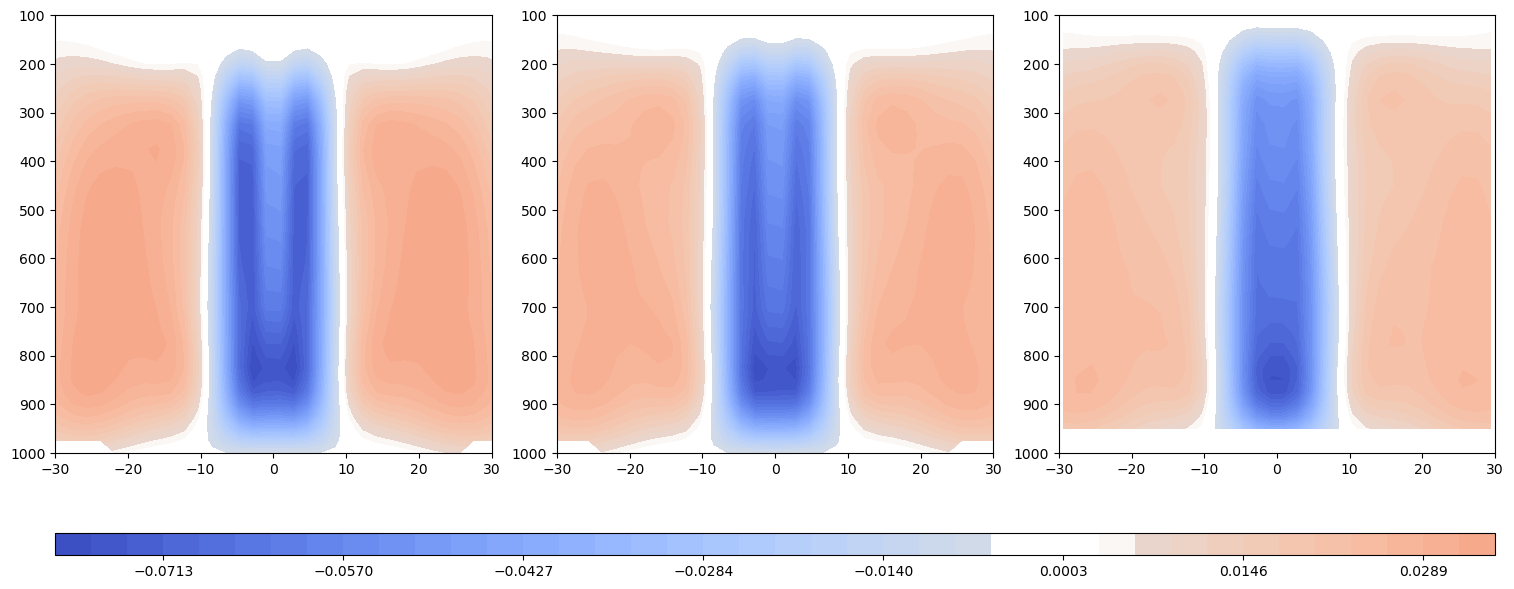

In [39]:
variable_to_plot = multi_experiment_variables_subset['Vertical Wind'].mean(dim=['time', 'lon'], skipna=False)

grand_min = variable_to_plot.min()
grand_max = variable_to_plot.max()

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 3, height_ratios=[30,1.5], width_ratios=[1, 1, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.15)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[0, 2]))

cbar_ax = fig.add_subplot(gs[-1, :])

ax[0].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    variable_to_plot.sel(experiment='-4K').T,
    cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    levels=np.linspace(grand_min, grand_max, 41),
    norm=mcolors.CenteredNorm(vcenter=0)
)
ax[1].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    variable_to_plot.sel(experiment='0K').T,
    cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    levels=np.linspace(grand_min, grand_max, 41),
    norm=mcolors.CenteredNorm(vcenter=0)
)
im = ax[2].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    variable_to_plot.sel(experiment='4K').T,
    cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    levels=np.linspace(grand_min, grand_max, 41),
    norm=mcolors.CenteredNorm(vcenter=0)
)

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

for ax in ax:
    ax.set_ylim(100, 1000)
    ax.set_xlim(-30, 30)
    ax.invert_yaxis()
plt.show()

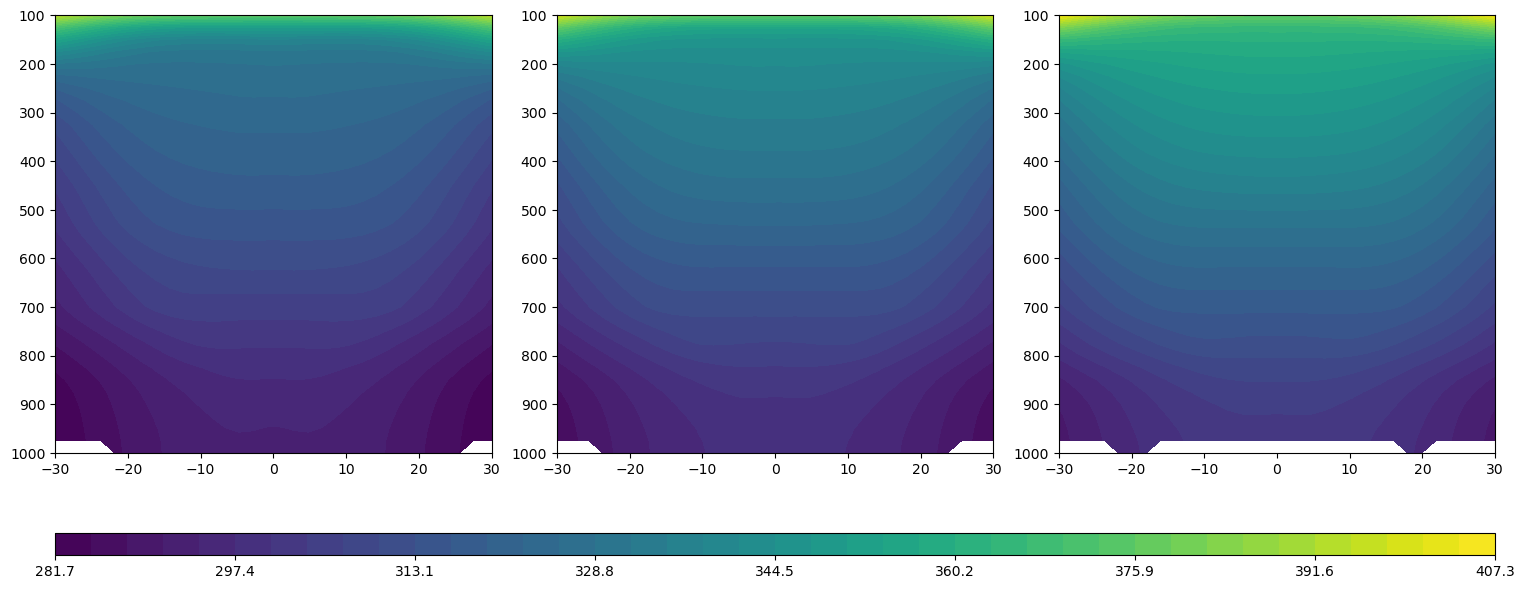

In [48]:
variable_to_plot = multi_experiment_variables_subset['Potential Temperature'].mean(dim=['time', 'lon'], skipna=False)

grand_min = variable_to_plot.sel(plev=slice(100, 950)).min()
grand_max = variable_to_plot.sel(plev=slice(100, 950)).max()
# grand_max=400

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 3, height_ratios=[30,1.5], width_ratios=[1, 1, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.15)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[0, 2]))

cbar_ax = fig.add_subplot(gs[-1, :])

ax[0].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    variable_to_plot.sel(experiment='-4K').T,
    # cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    levels=np.linspace(grand_min, grand_max, 41),
    # norm=mcolors.CenteredNorm(vcenter=0)
)
ax[1].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    variable_to_plot.sel(experiment='0K').T,
    # cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    levels=np.linspace(grand_min, grand_max, 41),
    # norm=mcolors.CenteredNorm(vcenter=0)
)
im = ax[2].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    variable_to_plot.sel(experiment='4K').T,
    # cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    levels=np.linspace(grand_min, grand_max, 41),
    # norm=mcolors.CenteredNorm(vcenter=0)
)

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

for ax in ax:
    ax.set_ylim(100, 1000)
    ax.set_xlim(-30, 30)
    ax.invert_yaxis()
plt.show()

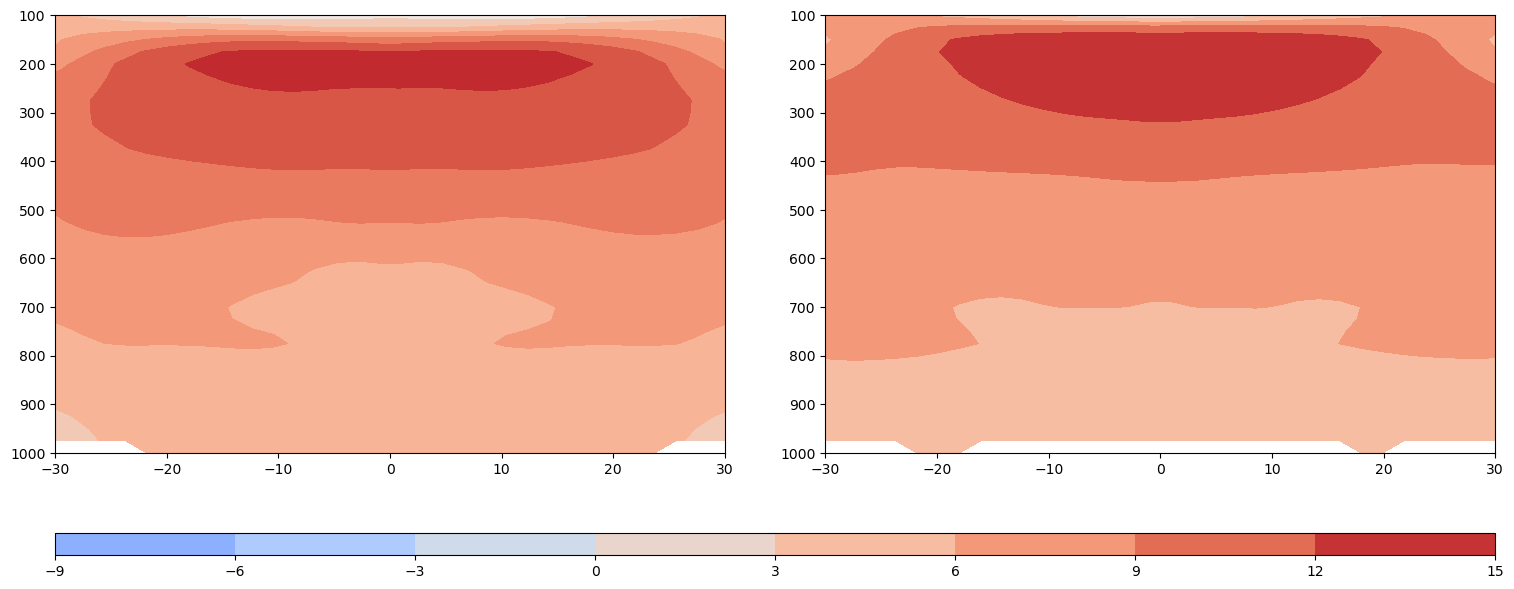

In [50]:
variable_to_plot = multi_experiment_variables_subset['Potential Temperature'].mean(dim=['time', 'lon'], skipna=False)

grand_min = variable_to_plot.min()
grand_max = variable_to_plot.max()

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 2, height_ratios=[30,1.5], width_ratios=[1, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.15)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))

cbar_ax = fig.add_subplot(gs[-1, :])

ax[0].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    (variable_to_plot.sel(experiment='0K').T - variable_to_plot.sel(experiment='-4K').T),
    cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    # levels=np.linspace(grand_min, grand_max, 21),
    # levels=np.linspace(-0.02, 0.02, 21),
    norm=mcolors.CenteredNorm(vcenter=0)
)
im = ax[1].contourf(
    variable_to_plot.lat,
    variable_to_plot.plev,
    (variable_to_plot.sel(experiment='4K').T - variable_to_plot.sel(experiment='0K').T),
    cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    # levels=np.linspace(grand_min, grand_max, 21),
    # levels=np.linspace(-0.02, 0.02, 21),
    norm=mcolors.CenteredNorm(vcenter=0)
)

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

for ax in ax:
    ax.set_ylim(100, 1000)
    ax.set_xlim(-30, 30)
    ax.invert_yaxis()
plt.show()

# Mean State Plots

## Latitude-Longitude

Column Water Vapor


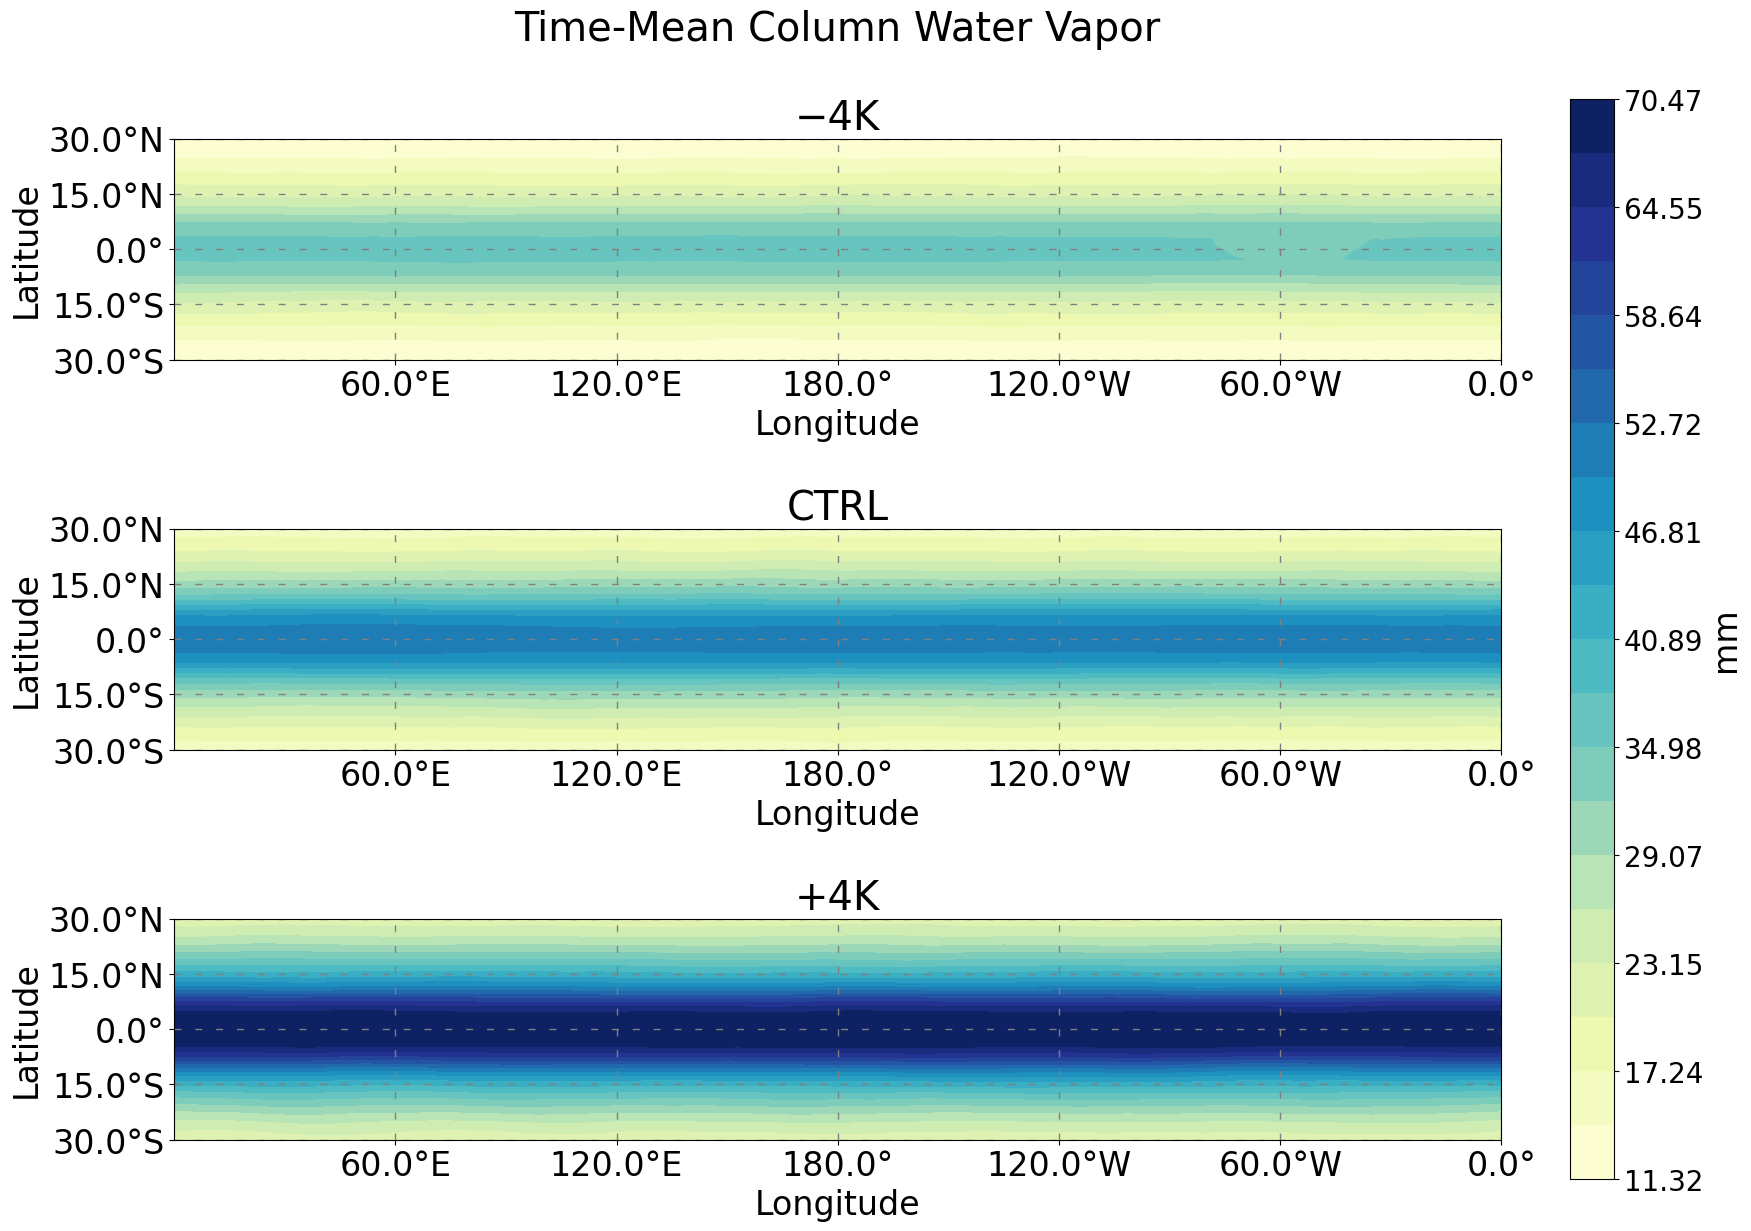

In [5]:
savefig=False
plt.style.use("default")
plt.rcParams.update({"font.size": 24})

variables_to_plot = [
    # multi_experiment_variables_subset['Precipitation'],
    multi_experiment_variables_subset['Column Water Vapor'],
    # multi_experiment_variables_subset['Outgoing Longwave Radiation'],
    # multi_experiment_variables_subset['Zonal Wind'].sel(plev=200),
    # multi_experiment_variables_subset['Zonal Wind'].sel(plev=850),
    # multi_experiment_variables_subset['Geopotential Height'].sel(plev=200),
    # multi_experiment_variables_subset['Geopotential Height'].sel(plev=850),
    # multi_experiment_variables_subset['Vertical Wind'].sel(plev=500),
    # multi_experiment_variables_subset['Moist Static Energy'].sel(plev=200),
    # multi_experiment_variables_subset['Moist Static Energy'].sel(plev=850),
    # multi_experiment_variables_subset['Column Temperature'],
    # multi_experiment_variables_subset['Column Water Vapor'],
    # multi_experiment_variables_subset['Column Longwave Heating'],
    # multi_experiment_variables_subset['Column Shortwave Heating'],
    # multi_experiment_variables_subset['Latent Heat Flux'],
    # multi_experiment_variables_subset['Sensible Heat Flux'],
    # multi_experiment_variables_subset['Surface Longwave Flux'],
    # multi_experiment_variables_subset['Surface Shortwave Flux'],
    # multi_experiment_variables_subset['TOA Longwave Flux'],
    # multi_experiment_variables_subset['TOA Shortwave Flux'],
    # multi_experiment_variables_subset['Net Longwave Flux'],
    # multi_experiment_variables_subset['Net Shortwave Flux'],
]

for variable_data in variables_to_plot:
    multi_experiment_lat_lon(
        variable_data.mean(dim='time', keep_attrs=True),
        fig_title = (
            f"Time-Mean"
              + f"{(' ' + (str(variable_data.plev.values) + '-hPa') if 'plev' in variable_data.coords else '')}"
              + f" {variable_data.name}"
        ),
    filename = f"/glade/u/home/sressel/aquaplanet_analysis/output/mean-state/latitude-longitude/multi-experiment_time-mean_{variable_data.attrs['file_id']}.png",
    savefig=False,
    cmap='variable',
    # norm=('zero-centered' if variable_data.name == 'Zonal Wind' or variable_data.name == 'Vertical Wind' else 'variable')
    )

In [24]:
files = glob.glob("/glade/u/home/sressel/aquaplanet_analysis/huang24_NCL_scripts/*")
for file in files:
    file_location = '/'.join(file.split("/")[:-1])
    file_name = file.split("/")[-1]
    os.system(f"cp {file_location}/{file_name} {file_location}/ressel_{file_name}")
    os.system(f"mv {file_location}/{file_name} {file_location}/huang_{file_name}")
    # os.system(f"cp {file} ressel_{file}")
    # os.system(f"mv {file} huang_{file}")

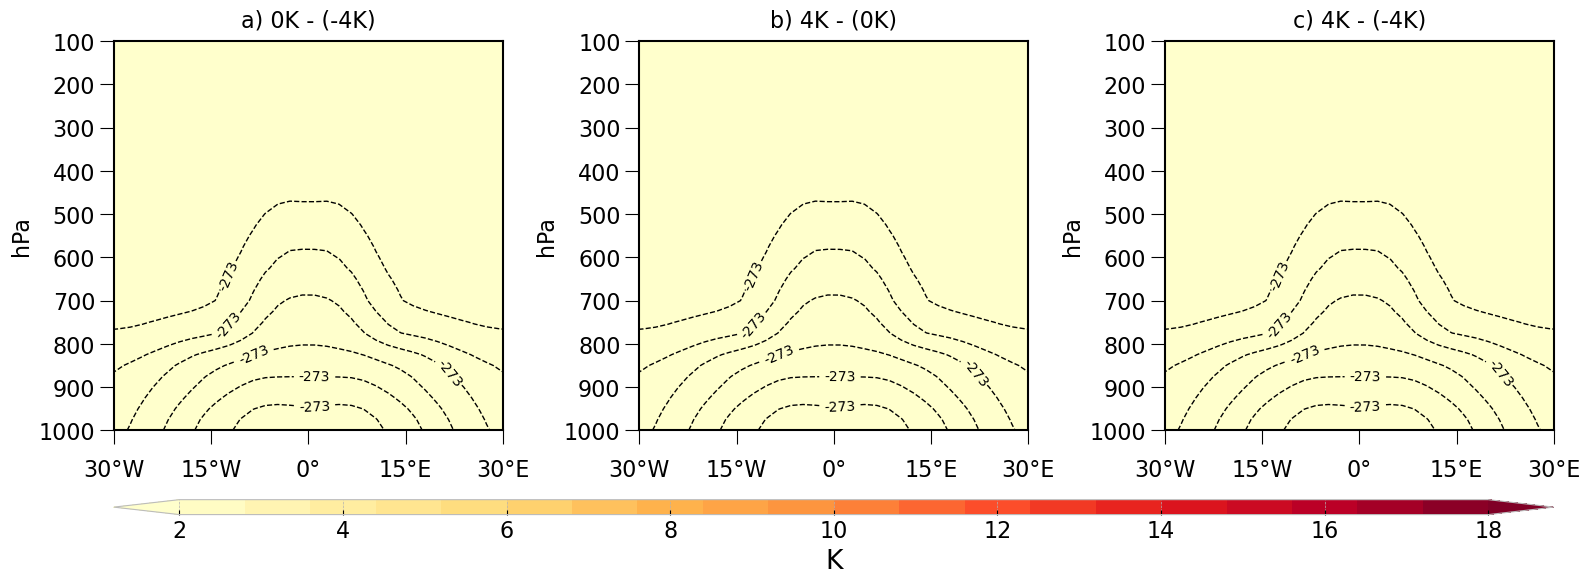

In [190]:
if 'zonal_mean_time_mean_temperature' not in locals():
    zonal_mean_time_mean_temperature = multi_experiment_variables_subset['Temperature'].mean(dim=['time', 'lon'])

plt.style.use('bmh')
plt.rcParams.update({'font.size':16})

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(2, 3, height_ratios=[35, 1], width_ratios=[1, 1, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.01, wspace=0.35)

axes = []
axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[0,1]))
axes.append(fig.add_subplot(gs[0,2]))
cbar_ax = fig.add_subplot(gs[1, :])

axes[0].set_title("a) 0K - (-4K)", fontsize=16, pad=10)
im = axes[0].contourf(
    zonal_mean_time_mean_temperature.lat,
    zonal_mean_time_mean_temperature.plev,
    (zonal_mean_time_mean_temperature.sel(experiment='0K') - zonal_mean_time_mean_temperature.sel(experiment='-4K')).T,
    # cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    cmap='YlOrRd',
    # norm=mcolors.CenteredNorm(vcenter=0),
    levels=np.linspace(2, 18, 21),
    extend='both'
)

axes[1].set_title("b) 4K - (0K)", fontsize=16, pad=10)
axes[1].contourf(
    zonal_mean_time_mean_temperature.lat,
    zonal_mean_time_mean_temperature.plev,
    (zonal_mean_time_mean_temperature.sel(experiment='4K') - zonal_mean_time_mean_temperature.sel(experiment='0K')).T,
    # cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    cmap='YlOrRd',
    # norm=mcolors.CenteredNorm(vcenter=0),
    levels=np.linspace(2, 18, 21),
    extend='both'
)

axes[2].set_title("c) 4K - (-4K)", fontsize=16, pad=10)
axes[2].contourf(
    zonal_mean_time_mean_temperature.lat,
    zonal_mean_time_mean_temperature.plev,
    (zonal_mean_time_mean_temperature.sel(experiment='4K') - zonal_mean_time_mean_temperature.sel(experiment='-4K')).T,
    # cmap=modified_colormap('coolwarm', 'white', 0.05, 0.05),
    cmap='YlOrRd',
    # norm=mcolors.CenteredNorm(vcenter=0),
    levels=np.linspace(2, 18, 21),
    extend='both'
)

cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('K')
cbar.set_ticks(np.arange(2, 20, 2))

for index, axis in enumerate(axes):
    axis.set_xlim(-30,30)
    axis.set_xticks(np.arange(-30,45,15), labels=tick_labeller(np.arange(-30,45,15), 'lon'), fontsize=16)
    # axis.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
    axis.set_ylim(100, 1000)
    axis.set_ylabel('hPa', fontsize=16)
    axis.set_yticks(np.arange(100, 1100, 100), labels=np.arange(100, 1100, 100), fontsize=16)
    axis.invert_yaxis()
    axis.set_aspect((60)/(900))
    axis.tick_params(axis='x', which='major', pad=10, length=10, direction='out')
    axis.tick_params(axis='y', which='major', length=10, direction='out')
    for spine in ['left', 'right', 'top', 'bottom']:
        axis.spines[spine].set_color('k')
        axis.spines[spine].set_lw(1.5)
    axis.grid(False)

    cs = axis.contour(
        zonal_mean_time_mean_temperature.lat,
        zonal_mean_time_mean_temperature.plev,
        (zonal_mean_time_mean_temperature.sel(experiment='0K')-273).T,
        colors='k',
        linewidths=1
    )
    cs0 = axis.contour(
        zonal_mean_time_mean_temperature.lat,
        zonal_mean_time_mean_temperature.plev,
        (zonal_mean_time_mean_temperature.sel(experiment='0K')-273).T,
        levels=[0],
        colors='k',
        linewidths=2
    )
    axis.clabel(cs, fontsize=10, colors='k', fmt='%1.0f', inline=True)
    axis.clabel(cs0, fontsize=10, colors='k', fmt='%1.0f', inline=True)


plt.show()

[[<matplotlib.lines.Line2D at 0x1495316c58e0>],

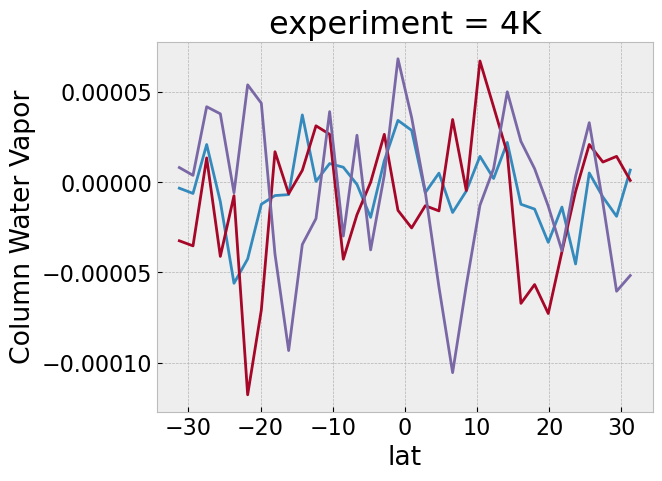

In [193]:
# [multi_experiment_variables_subset['Column Water Vapor'].sel(experiment=experiment).differentiate('lat').mean(dim=['time', 'lon']).plot() for experiment in experiments_list]
[multi_experiment_variables_subset['Column Water Vapor'].sel(experiment=experiment).differentiate('lon').mean(dim=['time', 'lon']).plot() for experiment in experiments_list]

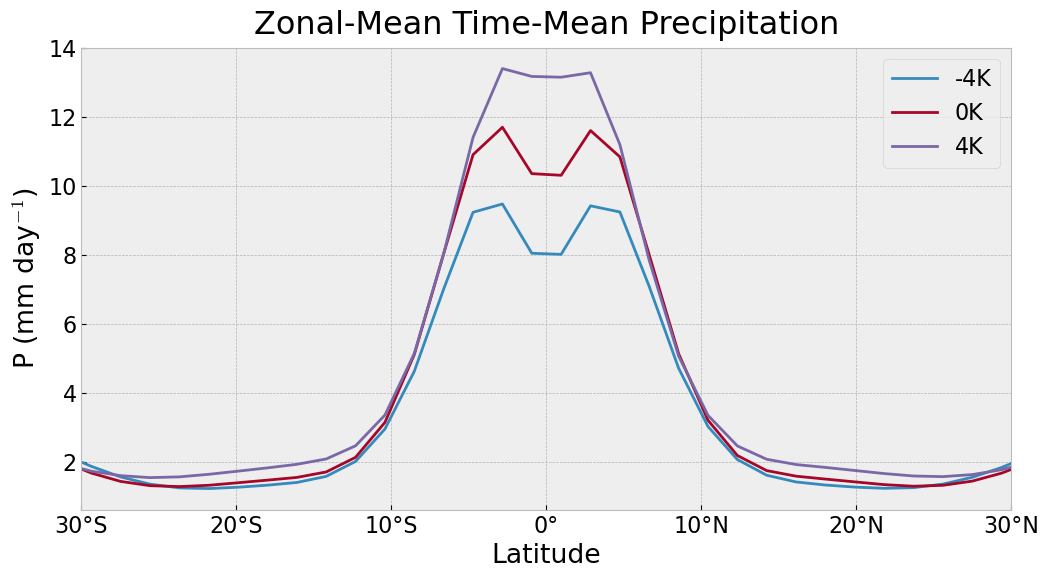

In [15]:
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.style.use('bmh')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 1, figsize=(12,6))
ax.set_title('Zonal-Mean Time-Mean Precipitation', pad=10)
for index, experiment in enumerate(experiments_list):
    ax.plot(
        multi_experiment_variables_subset['Precipitation'].lat,
        multi_experiment_variables_subset['Precipitation'].sel(experiment=experiment).mean(dim=['time', 'lon']),
        color=bmh_colors(index+1),
        label=experiment
    )

ax.set_ylabel(r'P (mm day$^{-1}$)')
ax.set_xlim(-30,30)
ax.set_xticks(ticks=np.arange(-30,40,10), labels=tick_labeller(np.arange(-30,40,10), 'lat'))
ax.set_xlabel('Latitude')
ax.legend(loc='upper right')
plt.show()

## Longitude-Height

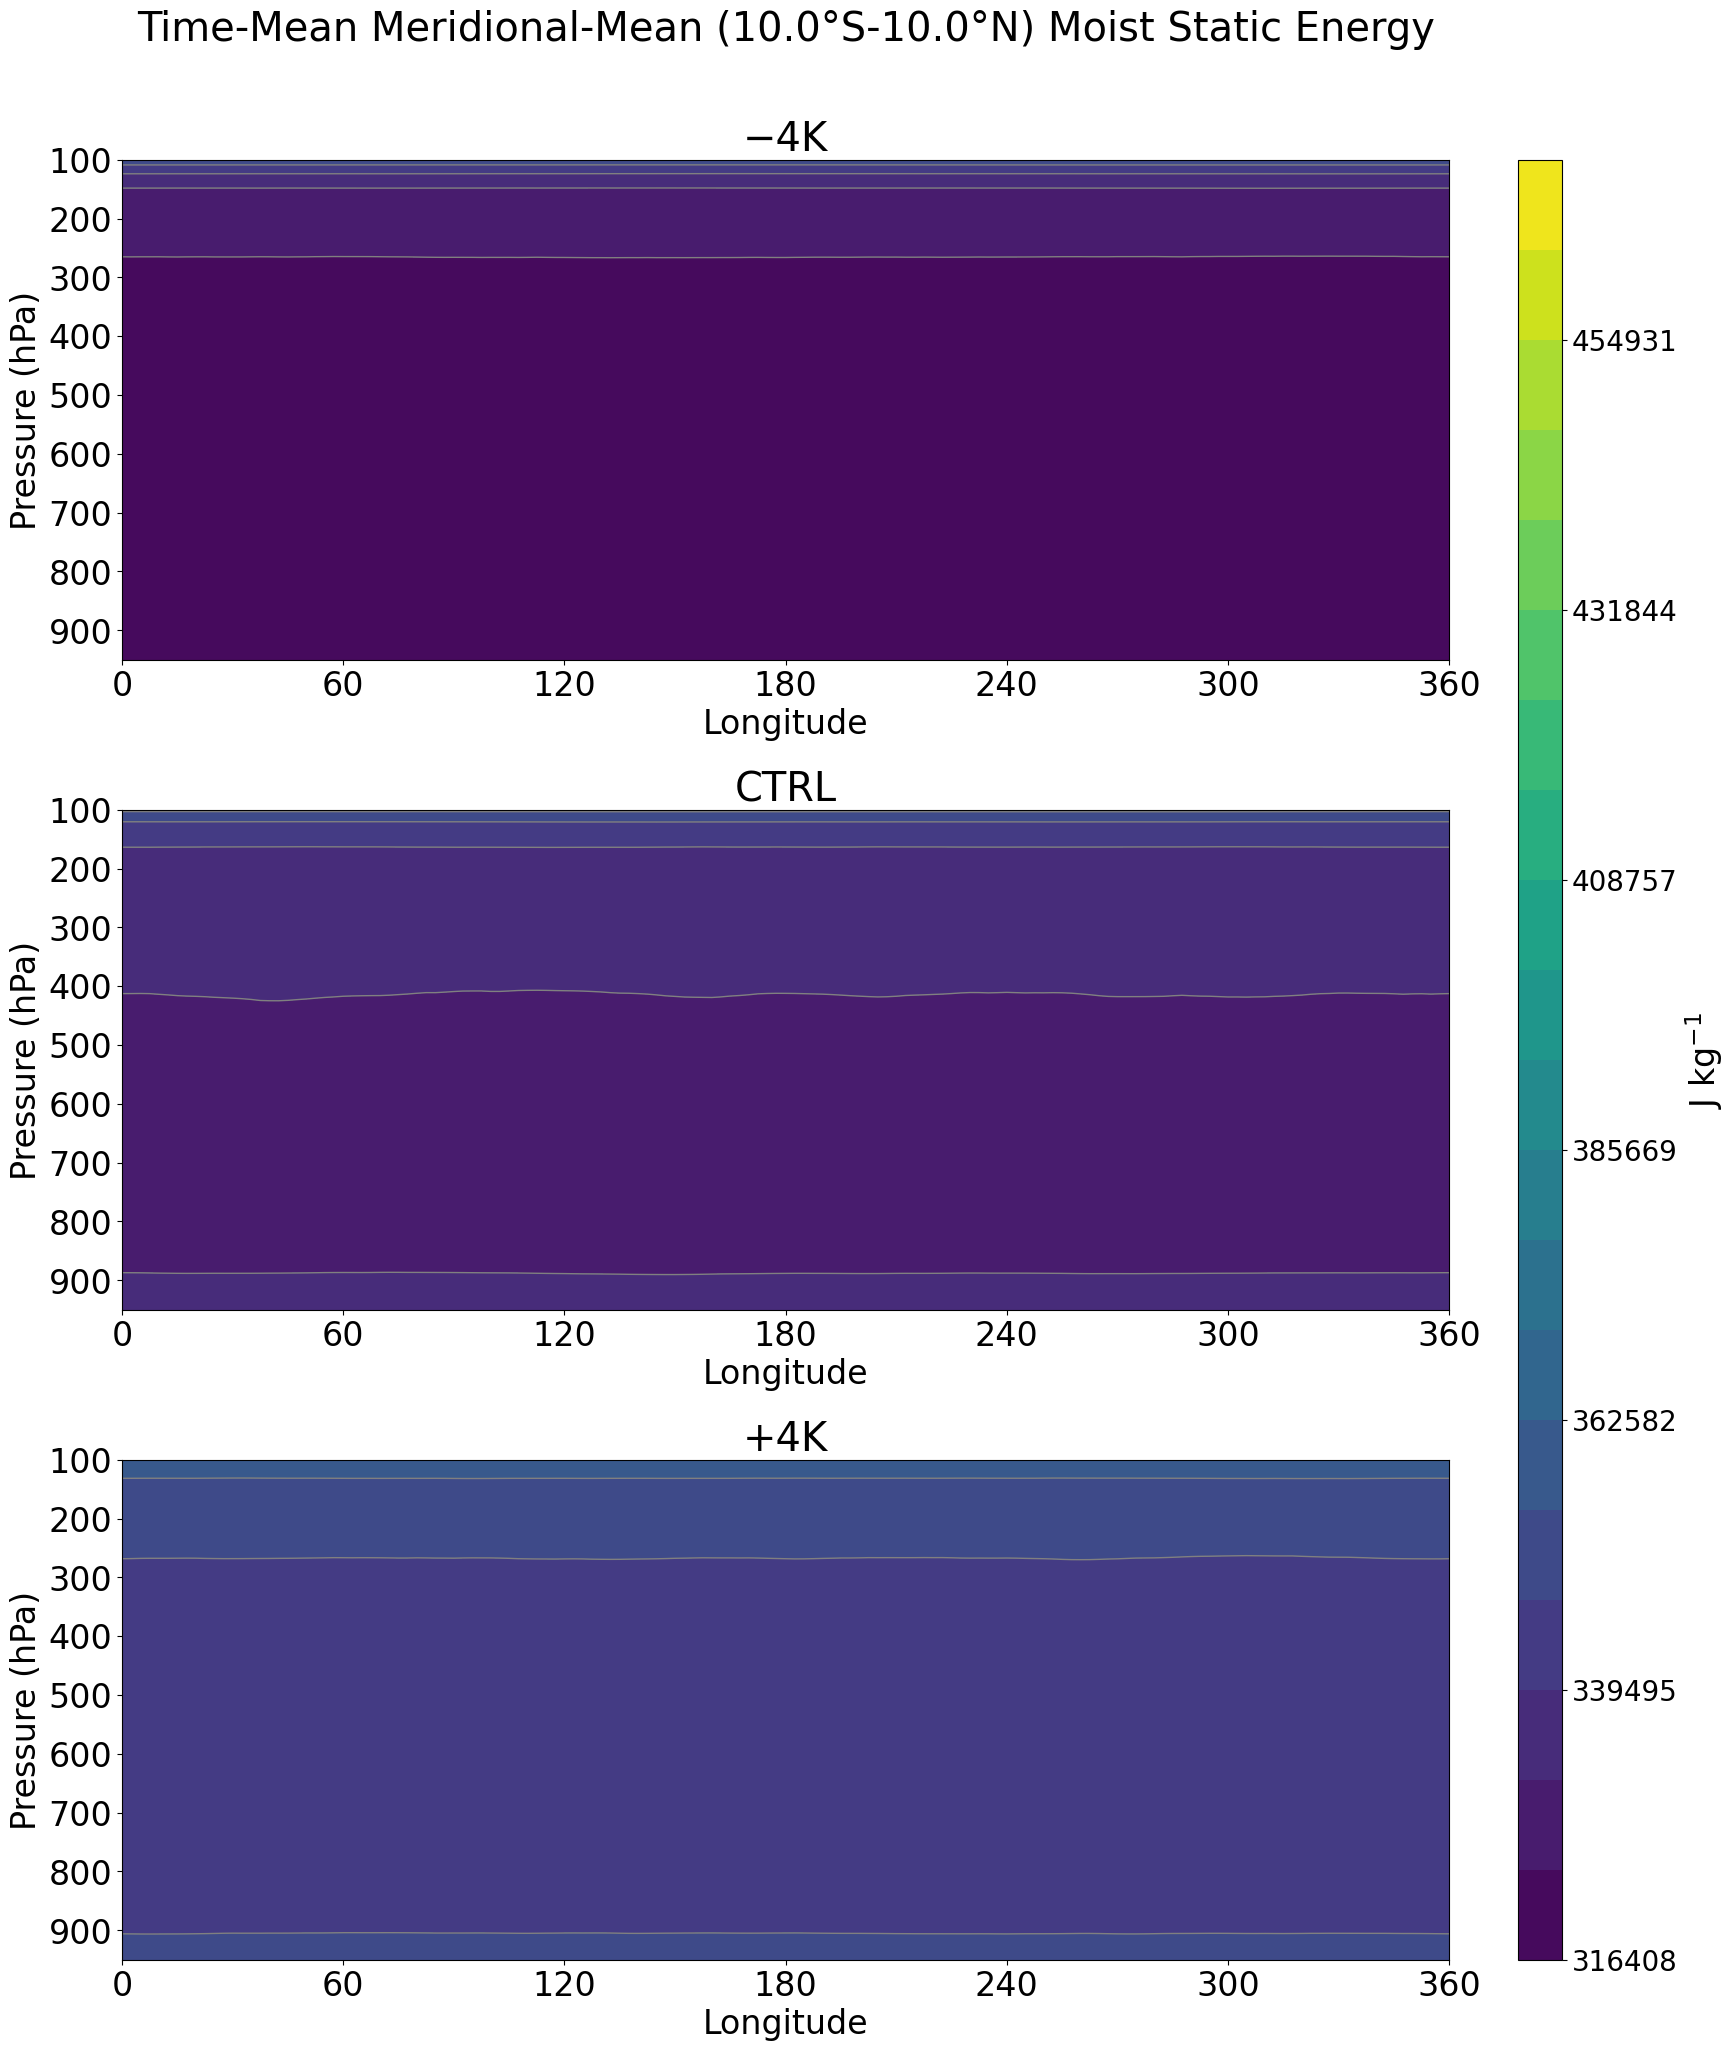

In [6]:
variables_to_plot = [
    # multi_experiment_variables_subset['Zonal Wind'],
    # multi_experiment_variables_subset['Meridional Wind'],
    # multi_experiment_variables_subset['Vertical Wind'],
    # multi_experiment_variables_subset['Geopotential Height'],
    # multi_experiment_variables_subset['Moisture'],
    # multi_experiment_variables_subset['Temperature'],
    # multi_experiment_variables_subset['Longwave Heating Rate'],
    # multi_experiment_variables_subset['Shortwave Heating Rate'],
    multi_experiment_variables_subset['Moist Static Energy'],
]

meridional_mean_region = (-10,10)
for variable_data in variables_to_plot:
    multi_experiment_lon_height(
        variable_data.mean(dim='time'),
        fig_title = (
            f"Time-Mean Meridional-Mean"
            + f" ({tick_labeller([meridional_mean_region[0]], 'lat')[0]}"
            + f"-{tick_labeller([meridional_mean_region[1]], 'lat')[0]})"
            + f" {variable_data.name.title()}"
        ),
        meridional_mean_region = slice(*meridional_mean_region)
    )

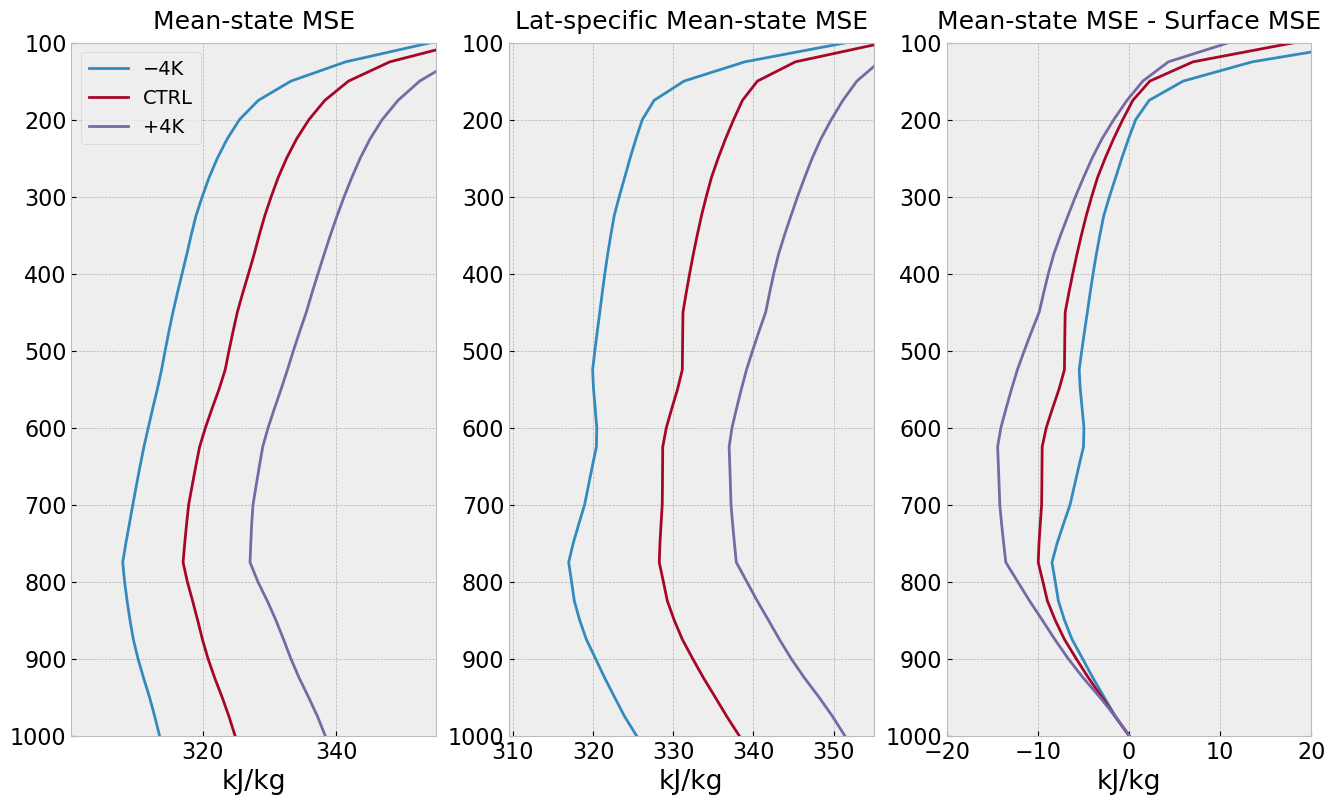

In [35]:
# plt.figure()
# (
#     multi_experiment_variables_subset['Moist Static Energy'].sel(experiment='-4K', lat=slice(-15,15)).mean(dim=['time', 'lat'])
#     - multi_experiment_variables_subset['Moist Static Energy'].sel(experiment='-4K', lat=slice(-15,15)).mean(dim=['time', 'lat']).isel(plev=-1)
# ).plot(y='plev', levels=np.linspace(-33e3, 53e3, 21))
# plt.gca().invert_yaxis()
# plt.show()

# plt.figure()
# (
#     multi_experiment_variables_subset['Moist Static Energy'].sel(experiment='0K', lat=slice(-15,15)).mean(dim=['time', 'lat'])
#     - multi_experiment_variables_subset['Moist Static Energy'].sel(experiment='0K', lat=slice(-15,15)).mean(dim=['time', 'lat']).isel(plev=-1)
# ).plot(y='plev', levels=np.linspace(-33e3, 53e3, 21))
# plt.gca().invert_yaxis()
# plt.show()

# plt.figure()
# (
#     multi_experiment_variables_subset['Moist Static Energy'].sel(experiment='4K', lat=slice(-15,15)).mean(dim=['time', 'lat'])
#     - multi_experiment_variables_subset['Moist Static Energy'].sel(experiment='4K', lat=slice(-15,15)).mean(dim=['time', 'lat']).isel(plev=-1)
# ).plot(y='plev', levels=np.linspace(-33e3, 53e3, 21))
# plt.gca().invert_yaxis()
# plt.show()

latitude_bounds = {}
latitude_bounds['-4K'] = slice(-5, 5)
latitude_bounds['0K'] = slice(-10, 10)
latitude_bounds['4K'] = slice(-15, 15)

# mean_state_moist_static_energy = multi_experiment_variables_subset['Moist Static Energy'].mean(dim='time')

plt.style.use('bmh')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 3, figsize=(16,9))
ax[0].set_title('Mean-state MSE', pad=10, fontsize=18)
ax[1].set_title('Lat-specific Mean-state MSE', pad=10, fontsize=18)
ax[2].set_title('Mean-state MSE - Surface MSE', pad=10, fontsize=18)
for index, experiment in enumerate(experiments_list):
    ax[0].plot(
        (1/1000)*mean_state_moist_static_energy.sel(experiment=experiment).mean(dim=['lat', 'lon']),
        mean_state_moist_static_energy.plev,
        color=bmh_colors(index+1),
        label=experiments_array.sel(experiment=experiment)['name'].item()
    )
    ax[1].plot(
        (1/1000)*mean_state_moist_static_energy.sel(experiment=experiment, lat=latitude_bounds[experiment]).mean(dim=['lat', 'lon']),
        mean_state_moist_static_energy.plev,
        color=bmh_colors(index+1),
        label=experiments_array.sel(experiment=experiment)['name'].item()
    )
    ax[2].plot(
        (
            (1/1000)*mean_state_moist_static_energy.sel(experiment=experiment, lat=latitude_bounds[experiment]).mean(dim=['lat', 'lon'])
            - (1/1000)*mean_state_moist_static_energy.sel(experiment=experiment, lat=latitude_bounds[experiment]).isel(plev=-1).mean(dim=['lat', 'lon'])
        ),
        mean_state_moist_static_energy.plev,
        color=bmh_colors(index+1),
        label=experiments_array.sel(experiment=experiment)['name'].item()
    )

    ax[index].set_yticks(np.arange(100, 1100, 100))
    ax[index].set_ylim(100, 1000)
    ax[index].invert_yaxis()
    ax[index].set_xlim(right=355)
    ax[index].set_xlabel('kJ/kg')

ax[0].legend(fontsize=14)

ax[2].set_xlim(-20, 20)

plt.show()

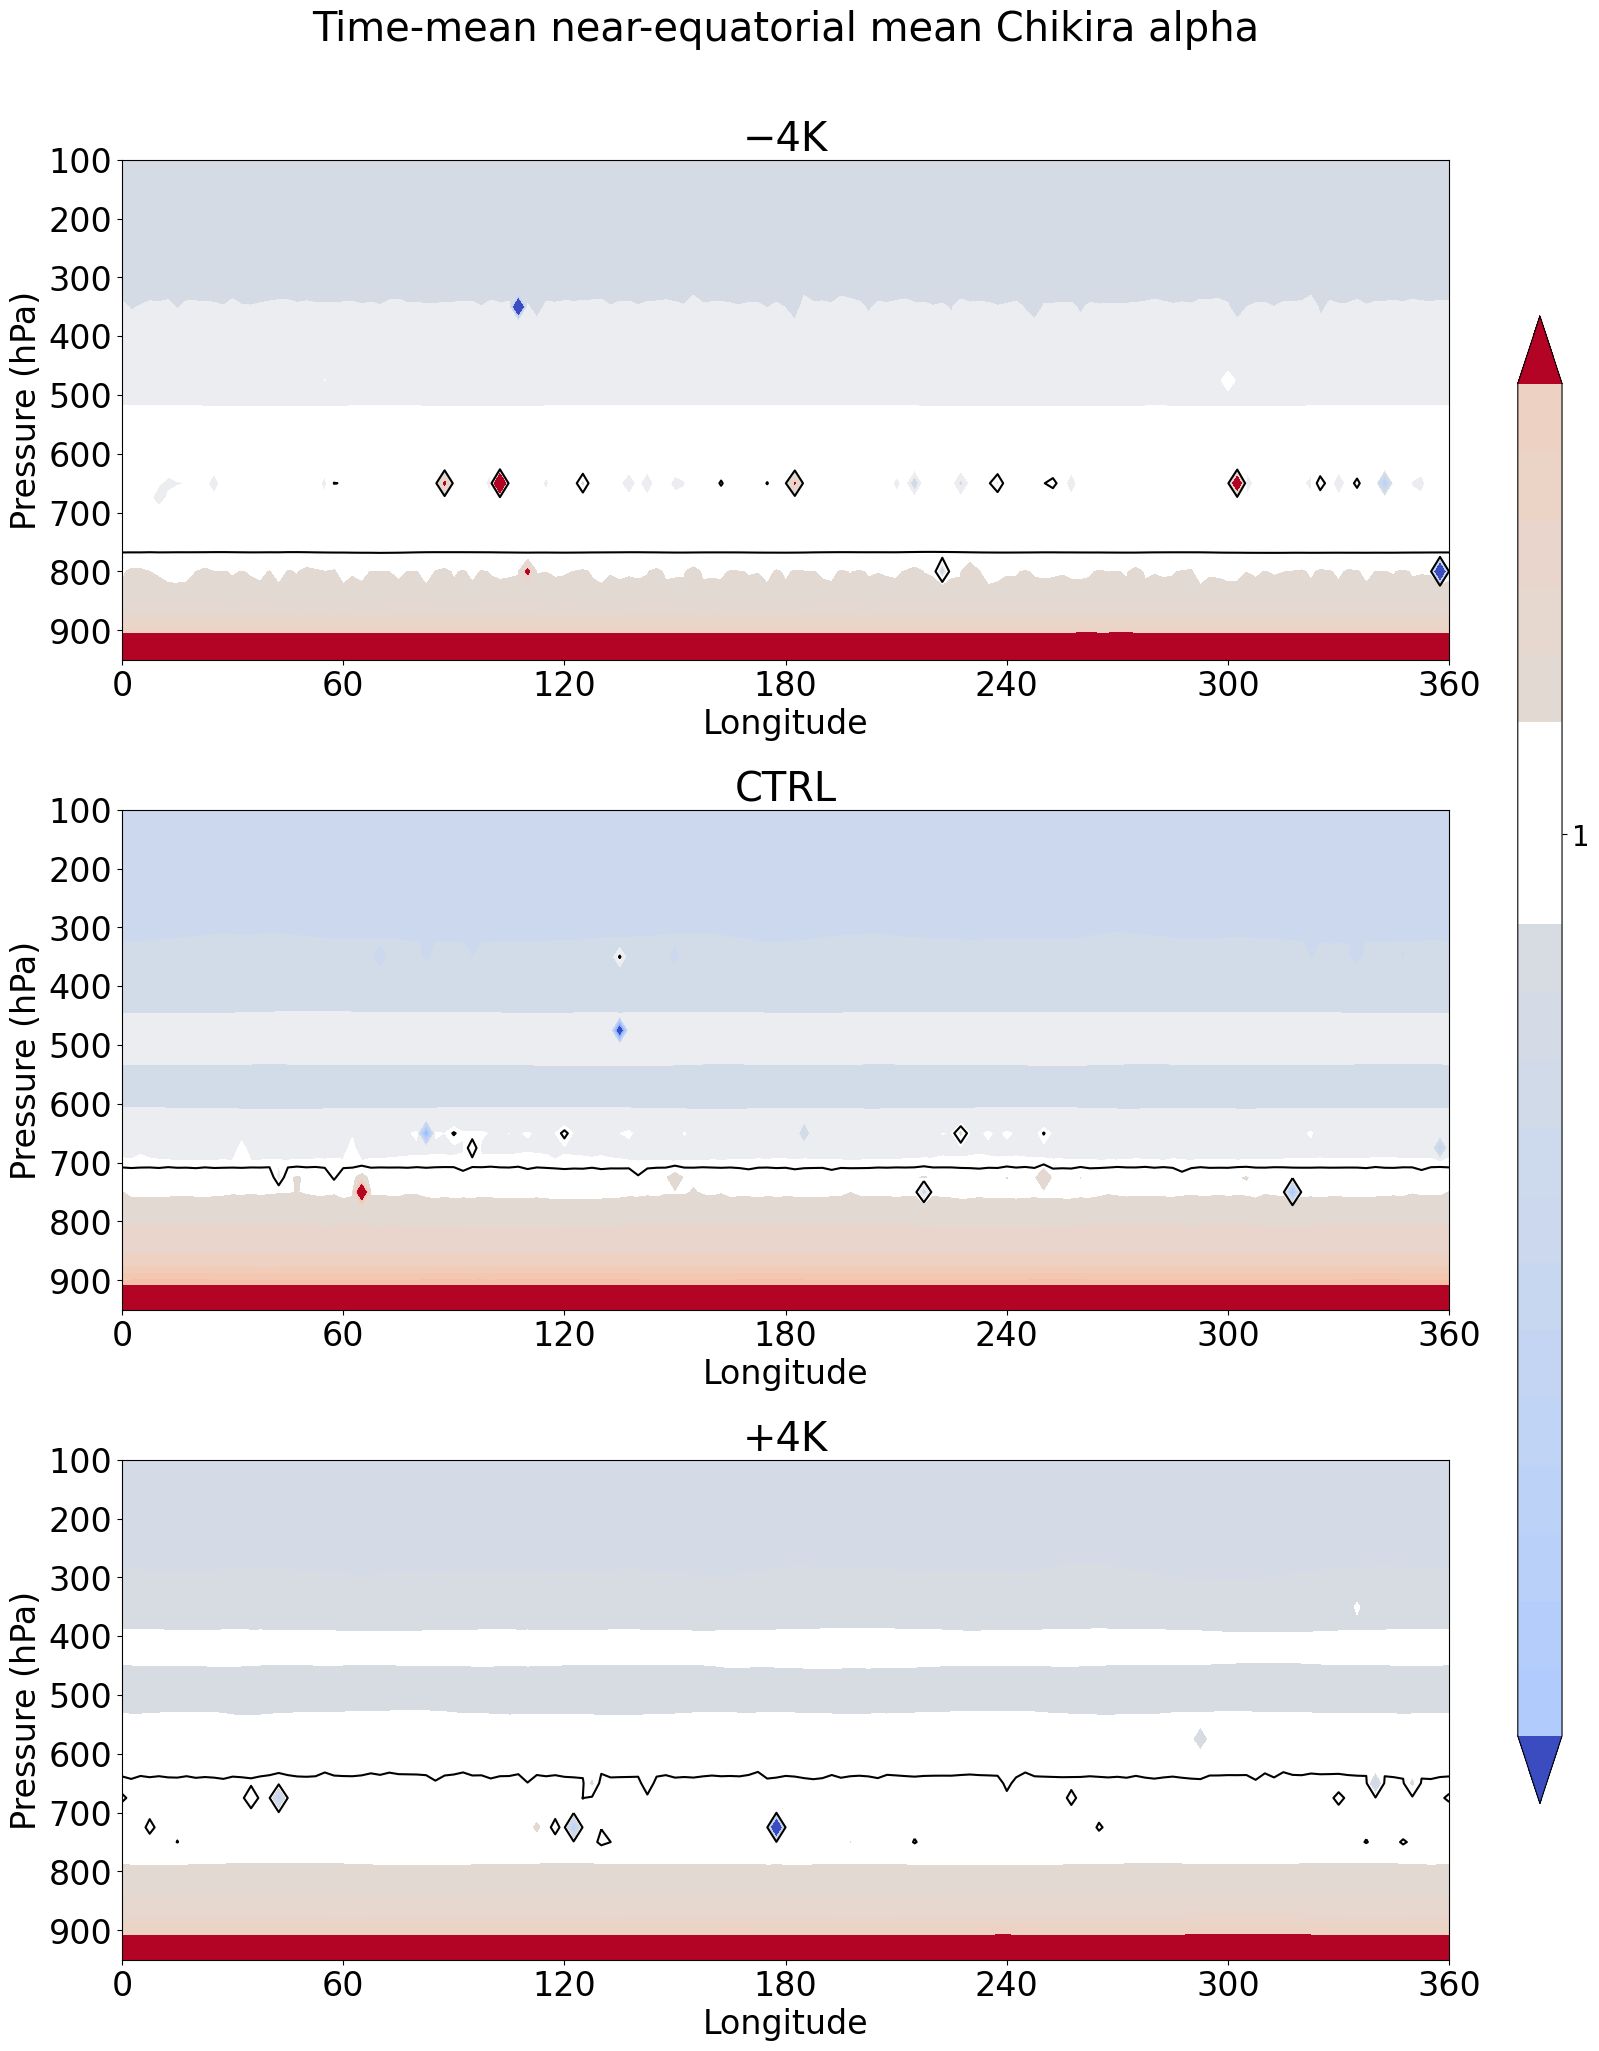

In [64]:
data_to_plot = multi_experiment_variables_subset['Chikira alpha'].sel(
    lat=slice(-15,15), plev=slice(100,950)
).mean(dim=['time', 'lat'])

plt.style.use("default")
plt.rcParams.update({"font.size": 24})

fig = plt.figure(figsize=(16, 20))
gs = GridSpec(3, 2, width_ratios=[30, 1], height_ratios=[1, 1, 1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.3, wspace=0.1)

axes = []
axes.append(fig.add_subplot(gs[0,0]))
axes.append(fig.add_subplot(gs[1,0]))
axes.append(fig.add_subplot(gs[2,0]))
cb_ax = fig.add_subplot(gs[:, 1])

grand_max = data_to_plot.max()
grand_min = data_to_plot.min()

for ax, experiment in zip(axes, experiments_list):

    ax.set_title(f"{experiments_array.sel(experiment=experiment)['name'].item()}")

    v_center = 1
    half_range = np.max(np.abs(data_to_plot.sel(experiment=experiment) - v_center))

    # Add cyclic point
    cdata, clon = cutil.add_cyclic_point(
        data_to_plot.sel(experiment=experiment),
        coord=data_to_plot.lon,
    )

    # Plot data
    im = ax.contourf(
        clon,
        data_to_plot.plev,
        cdata,
        levels=np.linspace(-3, 3, 21),
        # levels=21,
        cmap=modified_colormap('coolwarm', 'white', 0.025, 0.025),
        norm=mcolors.CenteredNorm(vcenter=v_center, halfrange=half_range),
        extend='both'
    )

    # Add colorbar
    cbar = fig.colorbar(
        im,
        cax=cb_ax,
        # ticks=np.arange(-3, 5, 2),
        ticks = [1],
        label=data_to_plot.attrs['units'],
        orientation="vertical",
    )
    cbar.ax.tick_params(labelsize=20)

    ax.contour(
        clon,
        data_to_plot.plev,
        cdata,
        levels=[1],
        colors='k',
    )

    # ax.axvline(x=180, ls=':', color='darkgray')

    # Axis parameters
    ax.set_xlim(0, 360)
    x_ticks = np.arange(0, 360 + 60, 60)
    ax.set_xticks(x_ticks)
    # ax.set_xticklabels(tick_labeller(x_ticks, "lon"))
    # ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
    ax.set_xlabel("Longitude")

    ax.set_ylim(100, 950)
    ax.set_yticks(np.arange(100, 1000, 100))
    ax.set_ylabel("Pressure (hPa)")
    ax.invert_yaxis()

    ax.set_aspect('auto')

fig.suptitle(
    "Time-mean near-equatorial mean Chikira alpha",
    x=(axes[0].get_position().x0 + axes[0].get_position().x1)/2,
    ha='center',
    y=1.025
)

plt.show()

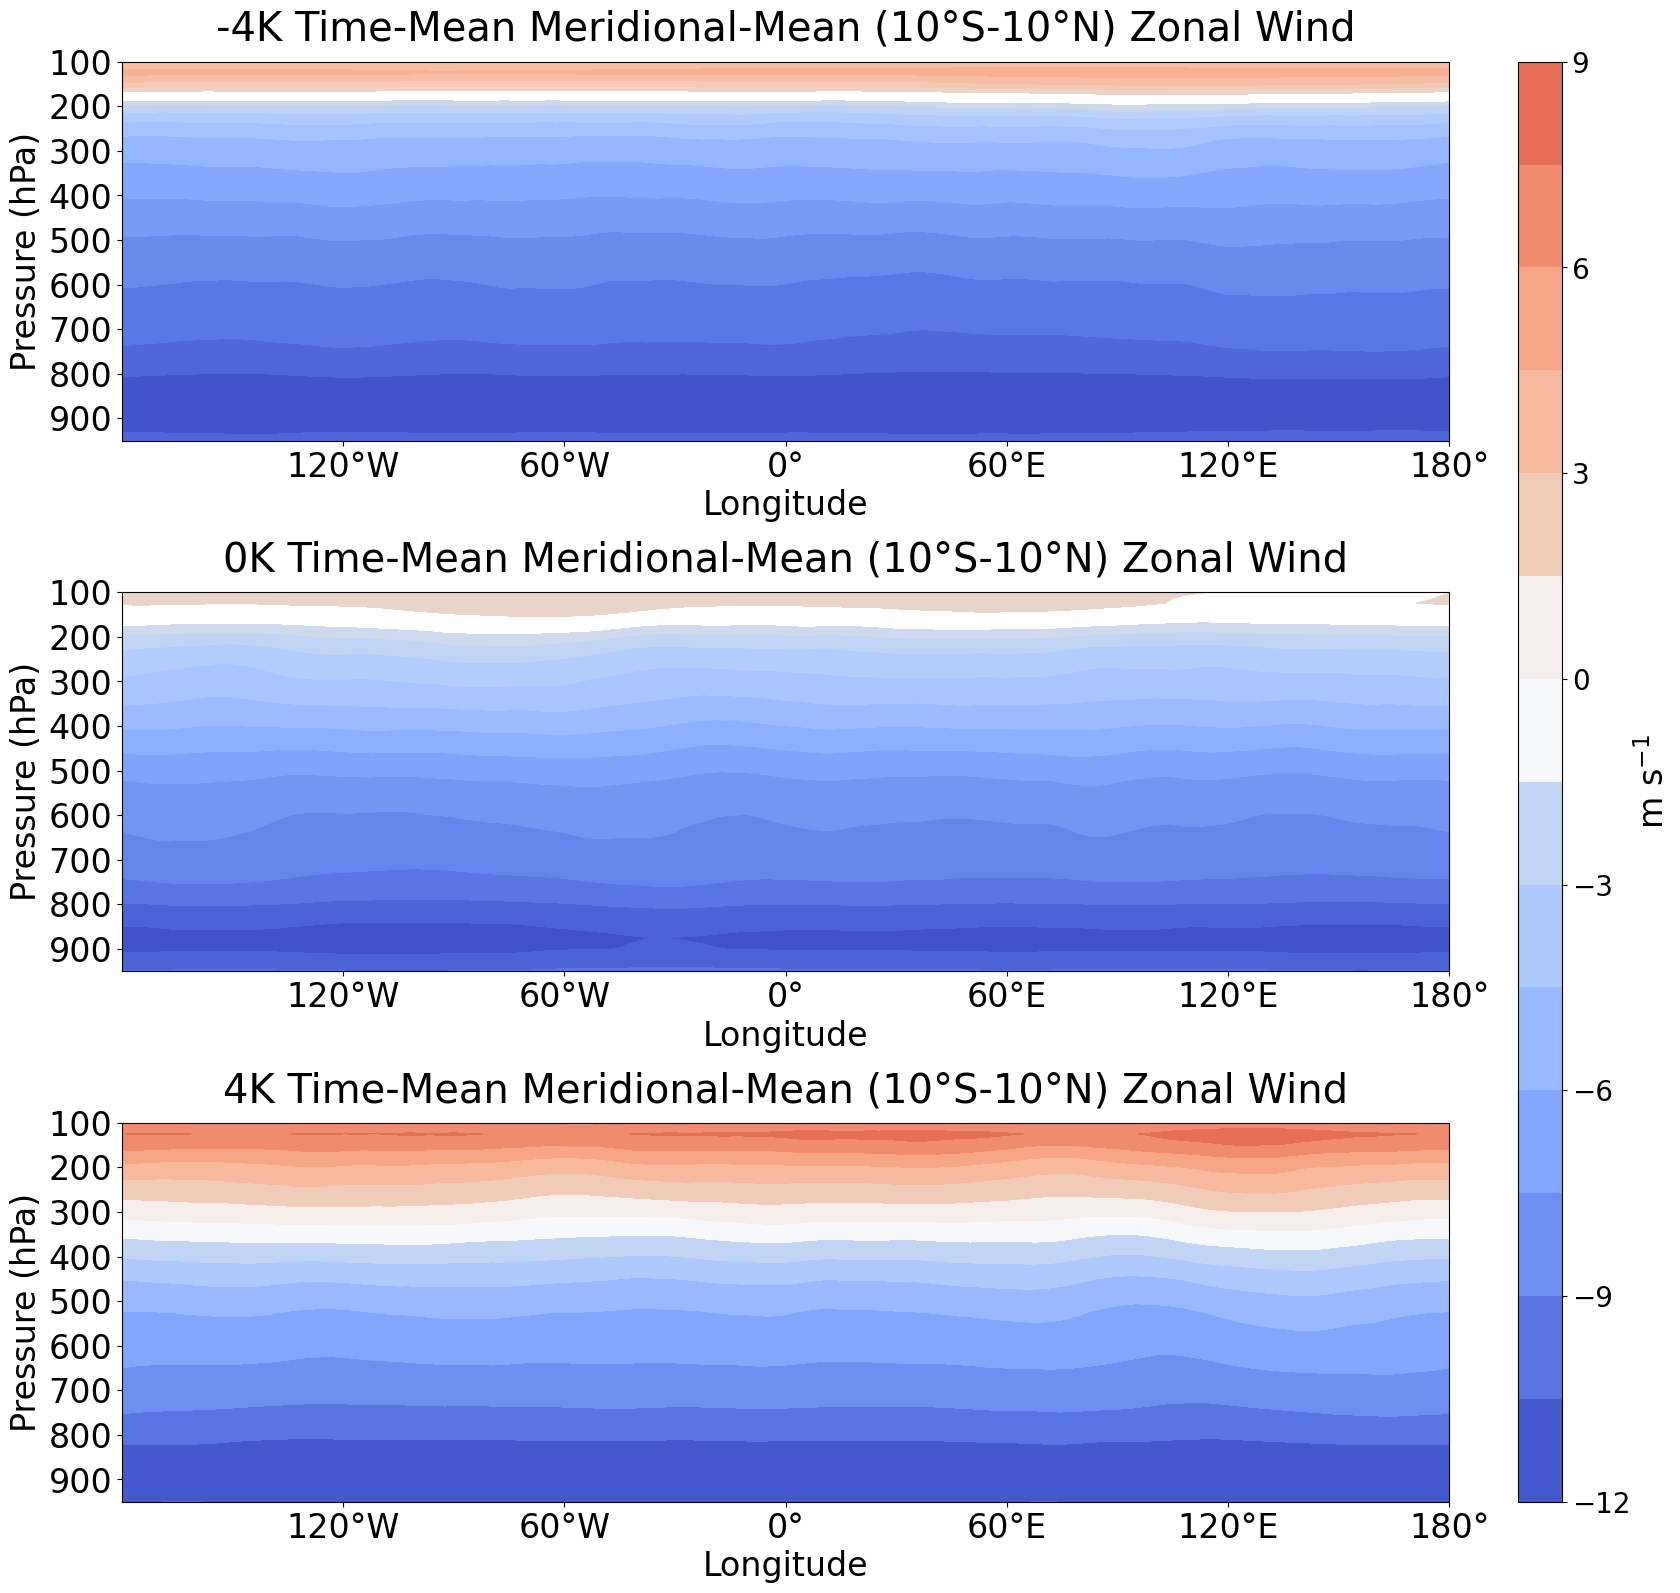

Finished


In [16]:
# savefig=False
# xr.set_options(keep_attrs=True)
# meridional_mean_region = slice(-10,10)

# variables_to_plot = [
#     multi_experiment_variables_subset['zonal wind'.title()],
#     # multi_experiment_variables_subset['meridional wind'.title()],
#     # multi_experiment_variables_subset['vertical wind'.title()],
#     # multi_experiment_variables_subset['temperature'.title()],
#     # multi_experiment_variables_subset['moisture'.title()],
#     # multi_experiment_variables_subset['geopotential height'.title()],
#     # multi_experiment_variables_subset['moist static energy'.title()],
#     # multi_experiment_variables_subset['longwave heating rate'.title()],
#     # multi_experiment_variables_subset['shortwave heating rate'.title()],
# ]

# for variable_data in variables_to_plot:

#     # variable_data = xr.concat(
#     #         [variable[experiment] for experiment in experiments_list],
#     #         dim=experiments_list)
#     # variable_data = variable_data.rename({"concat_dim": "experiment"})

#     time_mean_meridional_mean_variable_data = variable_data.sel(
#         lat=meridional_mean_region
#     ).mean(dim=['lat', 'time'])

#     grand_max = time_mean_meridional_mean_variable_data.max()
#     grand_min = time_mean_meridional_mean_variable_data.min()

#     plt.style.use("default")
#     plt.rcParams.update({"font.size": 24})

#     fig = plt.figure(figsize=(16, 16))
#     gs = GridSpec(3, 2, width_ratios=[30, 1], height_ratios=[1, 1, 1], figure=fig)
#     gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.4, wspace=0.1)

#     axes = []
#     axes.append(fig.add_subplot(gs[0,0]))
#     axes.append(fig.add_subplot(gs[1,0]))
#     axes.append(fig.add_subplot(gs[2,0]))
#     cb_ax = fig.add_subplot(gs[:, 1])

#     for ax, experiment in zip(axes, experiments_list):

#         ax.set_title(
#             (
#                 f"{experiment} Time-Mean Meridional-Mean"
#               + f" ({tick_labeller([meridional_mean_region.start], 'lat')[0]}"
#               + f"-{tick_labeller([meridional_mean_region.stop], 'lat')[0]})"
#               + f" {time_mean_meridional_mean_variable_data.name.title()}"
#             ),
#             pad=15
#         )

#         # Add cyclic point
#         cdata, clon = cutil.add_cyclic_point(
#             time_mean_meridional_mean_variable_data.sel(experiment=experiment).T,
#             coord=time_mean_meridional_mean_variable_data.lon,
#         )

#         # Plot data
#         im = ax.contourf(
#             clon,
#             time_mean_meridional_mean_variable_data.plev,
#             cdata,
#             levels=16,
#             **{k: copy.deepcopy(v) for k, v in {
#                 "norm": plotting_attributes[time_mean_meridional_mean_variable_data.name].get("norm"),
#                 "cmap": plotting_attributes[time_mean_meridional_mean_variable_data.name].get("cmap")
#             }.items() if v is not None}
#         )

#         # Add colorbar
#         cbar = fig.colorbar(
#             im,
#             cax=cb_ax,
#             label=time_mean_meridional_mean_variable_data.attrs['units'],
#             orientation="vertical",
#         )
#         cbar.ax.tick_params(labelsize=20)

#         # Axis parameters
#         ax.set_xlim(0, 360)
#         x_ticks = np.arange(0, 360 + 60, 60)
#         ax.set_xticks(x_ticks)
#         ax.set_xticklabels(tick_labeller(x_ticks-180, "lon"))
#         ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
#         ax.set_xlabel("Longitude")

#         ax.set_ylim(100, 950)
#         ax.set_yticks(np.arange(100, 1000, 100))
#         ax.set_ylabel("Pressure (hPa)")
#         ax.invert_yaxis()

#         ax.set_aspect('auto')

#     if not savefig:
#         plt.show()
#     else:
#         save_string = (
#             f"multi-experiment_time-mean_meridional-mean-{tick_labeller([meridional_mean_region.start], 'lat', False)[0]}"
#           + f"-{tick_labeller([meridional_mean_region.stop], 'lat', False)[0]}"
#           + f"_{time_mean_meridional_mean_variable_data.attrs['file_id']}.png"
#             )
#         print(f"Saving plot as {save_string}")
#         plt.savefig(
#             f"{output_directory}/mean-state/longitude-height/{save_string}",
#             dpi=500,
#             bbox_inches="tight",
#         )

# print(f"{'='*40}")
# print("Finished")

## Latitude-Height

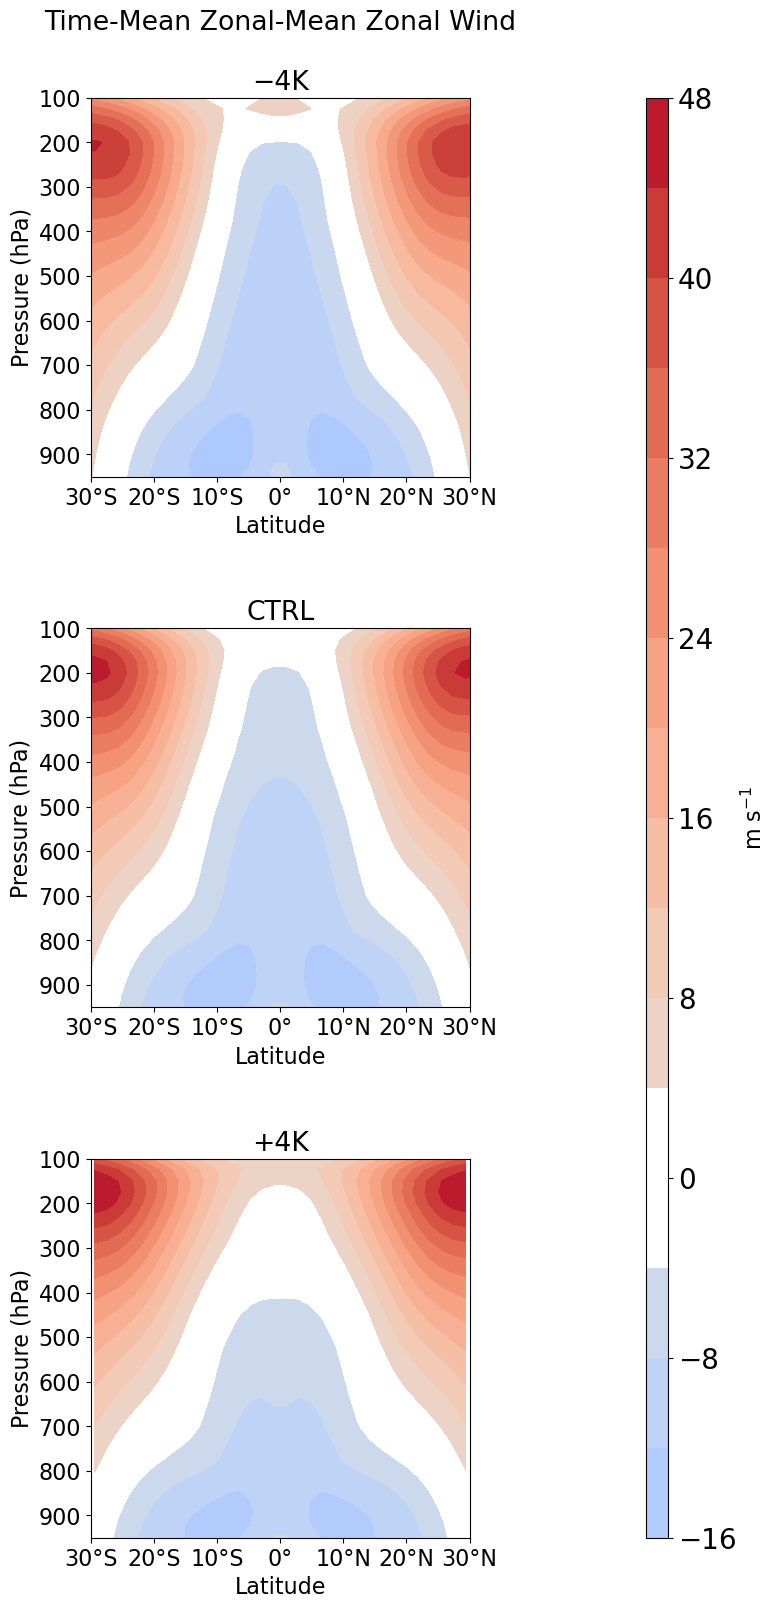

Finished


In [125]:
savefig=False
xr.set_options(keep_attrs=True)

variables_to_plot = [
    multi_experiment_variables_subset['zonal wind'.title()],
    # multi_experiment_variables_subset['meridional wind'.title()],
    # multi_experiment_variables_subset['vertical wind'.title()],
    # multi_experiment_variables_subset['temperature'.title()],
    # multi_experiment_variables_subset['moisture'.title()],
    # multi_experiment_variables_subset['geopotential height'.title()],
    # multi_experiment_variables_subset['moist static energy'.title()],
    # multi_experiment_variables_subset['longwave heating rate'.title()],
    # multi_experiment_variables_subset['shortwave heating rate'.title()],
]

for variable_data in variables_to_plot:

    time_mean_zonal_mean_variable_data = variable_data.sel(
    ).mean(dim=['lon', 'time'])

    grand_max = time_mean_zonal_mean_variable_data.max()
    grand_min = time_mean_zonal_mean_variable_data.min()

    plt.style.use("default")
    plt.rcParams.update({"font.size": 16})

    fig = plt.figure(figsize=(8, 16))
    gs = GridSpec(3, 2, width_ratios=[30, 1], height_ratios=[1, 1, 1], figure=fig)
    gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.4, wspace=0.1)

    axes = []
    axes.append(fig.add_subplot(gs[0,0]))
    axes.append(fig.add_subplot(gs[1,0]))
    axes.append(fig.add_subplot(gs[2,0]))
    cb_ax = fig.add_subplot(gs[:, 1])

    for ax, experiment in zip(axes, experiments_list):

        # ax.set_title(
        #     (
        #         f"{experiment} Time-Mean Zonal-Mean"
        #       + f" {time_mean_zonal_mean_variable_data.name.title()}"
        #     ),
        #     pad=15
        # )
        ax.set_title(experiments_array.sel(experiment=experiment)['name'].item())

        # Plot data
        im = ax.contourf(
            time_mean_zonal_mean_variable_data.lat,
            time_mean_zonal_mean_variable_data.plev,
            time_mean_zonal_mean_variable_data.sel(experiment=experiment).T,
            levels=16,
            **{k: copy.deepcopy(v) for k, v in {
                "norm": plotting_attributes[time_mean_zonal_mean_variable_data.name].get("norm"),
                "cmap": plotting_attributes[time_mean_zonal_mean_variable_data.name].get("cmap")
            }.items() if v is not None}
        )

        # Add colorbar
        cbar = fig.colorbar(
            im,
            cax=cb_ax,
            label=time_mean_zonal_mean_variable_data.attrs['units'],
            orientation="vertical",
        )
        cbar.ax.tick_params(labelsize=20)

        # Axis parameters
        ax.set_xlim(-30, 30)
        x_ticks = np.arange(-30, 30+10, 10)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(tick_labeller(x_ticks, "lat"))
        # ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
        ax.set_xlabel("Latitude")

        ax.set_ylim(100, 950)
        ax.set_yticks(np.arange(100, 1000, 100))
        ax.set_ylabel("Pressure (hPa)")
        ax.invert_yaxis()

        # ax.set_aspect('auto')
        ax.set_aspect(60/850)

    fig.suptitle(
        f"Time-Mean Zonal-Mean"
        + f" {variable_data.name.title()}",
        x=(axes[0].get_position().x0 + axes[0].get_position().x1)/2,
        ha='center',
        y=1.005
    )

    if not savefig:
        plt.show()
    else:
        save_string = (
            f"multi-experiment_time-mean_zonal-mean"
          + f"_{time_mean_zonal_mean_variable_data.attrs['file_id']}.png"
            )
        print(f"Saving plot as {save_string}")
        plt.savefig(
            f"{output_directory}/mean-state/latitude-height/{save_string}",
            dpi=500,
            bbox_inches="tight",
        )

print(f"{'='*40}")
print("Finished")

## Experiment-mean vertical profiles

In [11]:
variables_loaded = {}
for exp_index, experiment in enumerate(['-4K', '0K', '4K']):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
    ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME))
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    non_timed_data =  xr.open_dataset(
        rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
    )

    print(f"{'Pressure Array...':<{str_width-1}}", end="")
    lower_level_pressure = 1100.*100.
    upper_level_pressure = 100.*100.
    surface_pressure = variables_loaded['PS']
    pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
    pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
    print(rf"{'✔':>1}")

    time_mean_temperature = variables_loaded['T'].mean(dim=['time'])
    temperature_minimum_index = time_mean_temperature.argmin('lev')
    temperature_minimum_pressure_level = pressure_array.mean(dim='time').transpose("lev", ...)[temperature_minimum_index].mean(dim=['lat', 'lon'])
    print(temperature_minimum_pressure_level.values)

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FLUT...                         ✔
(5/17) FSNS...                         ✔
(6/17) FSNT...                         ✔
(7/17) LHFLX...                        ✔
(8/17) OMEGA...                        ✔
(9/17) PRECC...                        ✔
(10/17) PRECL...                       ✔
(11/17) PS...                          ✔
(12/17) Q...                           ✔
(13/17) SHFLX...                       ✔
(14/17) T...                           ✔
(15/17) U...                           ✔
(16/17) V...                           ✔
(17/17) Z3...                          ✔
----------------------------------------
Pressure Array...                      ✔
12132.269086295419
----------------------------------------
Loading 0K data...                    

In [5]:
experiment_mean_temperature = multi_experiment_variables_subset['Temperature'].mean(dim=['time', 'lat', 'lon'])
# experiment_mean_potential_temperature = multi_experiment_variables_subset['Potential Temperature'].mean(dim=['time', 'lat', 'lon'])
# experiment_mean_moisture = multi_experiment_variables_subset['Moisture'].mean(dim=['time', 'lat', 'lon'])
# experiment_mean_moist_static_energy = multi_experiment_variables_subset['Moist Static Energy'].sel(lat=slice(-10,10)).mean(dim=['time', 'lat', 'lon'])

In [36]:
variables_loaded = {}
experiment_mean_temperature = {}
vertical_temperature_gradient = {}

non_timed_data =  xr.open_dataset(
    rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
)

for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
    ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME))
        print(rf"{'✔':>1}")

    surface_pressure = variables_loaded['PS']
    pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
    pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")

    print(np.max(variables_loaded['T']))
    vertical_temperature_gradient[experiment] = xr.zeros_like(variables_loaded['T'])
    vertical_temperature_gradient[experiment][:, 0] = (
        (variables_loaded['T'][:, 1].values - variables_loaded['T'][:, 0].values)
        / (pressure_array[:, 1].values - pressure_array[:, 0].values)
    )
    vertical_temperature_gradient[experiment][:, 1:-1] = (
        (variables_loaded['T'][:, 2:].values - variables_loaded['T'][:, :-2].values)
        / (pressure_array[:, 2:].values - pressure_array[:, :-2].values)
    )
    vertical_temperature_gradient[experiment][:, -1] = (
        (variables_loaded['T'][:, -1].values - variables_loaded['T'][:, -2].values)
        / (pressure_array[:, -1].values - pressure_array[:, -2].values)
    )
    print(f"{'-'*str_width}")

multi_experiment_vertical_temperature_gradient = xr.concat(
    [vertical_temperature_gradient[experiment] for experiment in experiments_list],
    dim=experiments_array
)

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FSNS...                         ✔
(5/17) FSNT...                         ✔
(6/17) LHFLX...                        ✔
(7/17) OMEGA...                        ✔
(8/17) PRECC...                        ✔
(9/17) PRECL...                        ✔
(10/17) PS...                          ✔
(11/17) Q...                           ✔
(12/17) SHFLX...                       ✔
(13/17) T...                           ✔
(14/17) U...                           ✔
(15/17) V...                           ✔
(16/17) Z3...                          ✔
(17/17) FLUT...                        ✔
<xarray.DataArray 'T' ()> Size: 8B
array(304.15081787)
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean
----------

In [66]:
var = 'OMEGA'

variable_data_files = sorted(glob.glob(
        rf"{data_directory}/4K/daily_model-level_data/*_{var}.nc"
    ))
plus = xr.open_dataset(variable_data_files[0])[var]

variable_data_files = sorted(glob.glob(
        rf"{data_directory}/0K/daily_model-level_data/*_{var}.nc"
    ))
zero = xr.open_dataset(variable_data_files[0])[var]

variable_data_files = sorted(glob.glob(
        rf"{data_directory}/-4K/daily_model-level_data/*_{var}.nc"
    ))
minus = xr.open_dataset(variable_data_files[0])[var]

print(np.max(np.abs(plus - zero)))
print(np.max(np.abs(plus - minus)))

<xarray.DataArray 'OMEGA' ()> Size: 8B
array(0.)
Attributes:
    mdims:         1
    units:         Pa/s
    long_name:     Vertical velocity (pressure)
    cell_methods:  time: mean
<xarray.DataArray 'OMEGA' ()> Size: 8B
array(0.)
Attributes:
    mdims:         1
    units:         Pa/s
    long_name:     Vertical velocity (pressure)
    cell_methods:  time: mean


In [69]:
variables_loaded = {}
for exp_index, experiment in enumerate(experiments_list):

    print(f"{'-'*str_width}")
    print(f"{f'Loading {experiment} data...':<{str_width}}")
    print(f"{'-'*str_width}")
    variable_data_files = sorted(glob.glob(
        rf"{data_directory}/{experiment}/daily_model-level_data/*.nc"
    ))
    for index, file in enumerate(variable_data_files):
        variable_data = xr.open_dataarray(file)
        print(f"{f'({index+1}/{len(variable_data_files)}) {variable_data.name}...':<{str_width-1}}", end="")
        variables_loaded[variable_data.name] = variable_data.sel(time=slice(START_TIME, END_TIME))
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

    recalculate_budgets = True

    non_timed_data =  xr.open_dataset(
        rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/SST_AQP3_Qobs_27_-4K_3h_20y_new2.cam.h1.0001-02-16-43200.nc"
    )

    if recalculate_budgets:
        print(f"{'Pressure Array...':<{str_width-1}}", end="")
        lower_level_pressure = 1100.*100.
        upper_level_pressure = 100.*100.
        surface_pressure = variables_loaded['PS']
        pressure_array = non_timed_data['hyam']*non_timed_data['P0'] + non_timed_data['hybm']*surface_pressure
        pressure_array = pressure_array.transpose("time", "lev", "lat", "lon")
        print(rf"{'✔':>1}")

        print(f"{'Moist Static Energy...':<{str_width-1}}", end="")
        GRAVITY = 9.8                        #  m/s^2
        SPECIFIC_HEAT = 1005.7               #  J/Kg*K ; specific heat at constant pressure for dry air
        HEAT_OF_VAPORIZATION = 2.501e6       #  [J/kg]=[m2/s2]  Latent Heat of Vaporization at 0
        HEAT_OF_FUSION = 3.337e5             # [J/kg]=[m2/s2]  Latent Heat of Sublimation at 0
        moist_static_energy = (
            HEAT_OF_VAPORIZATION*variables_loaded['Q']
            - HEAT_OF_FUSION*variables_loaded['CLDICE']
            + SPECIFIC_HEAT*variables_loaded['T']
            + GRAVITY*variables_loaded['Z3']
        )

        print(moist_static_energy.max())

----------------------------------------
Loading -4K data...                     
----------------------------------------
(1/17) CLDICE...                       ✔
(2/17) FLNS...                         ✔
(3/17) FLNT...                         ✔
(4/17) FSNS...                         ✔
(5/17) FSNT...                         ✔
(6/17) LHFLX...                        ✔
(7/17) OMEGA...                        ✔
(8/17) PRECC...                        ✔
(9/17) PRECL...                        ✔
(10/17) PS...                          ✔
(11/17) Q...                           ✔
(12/17) SHFLX...                       ✔
(13/17) T...                           ✔
(14/17) U...                           ✔
(15/17) V...                           ✔
(16/17) Z3...                          ✔
(17/17) FLUT...                        ✔
----------------------------------------
Pressure Array...                      ✔
Moist Static Energy...                 <xarray.DataArray ()> Size: 8B
array(643308.125)
Attributes

[[<matplotlib.lines.Line2D at 0x149df3057380>],

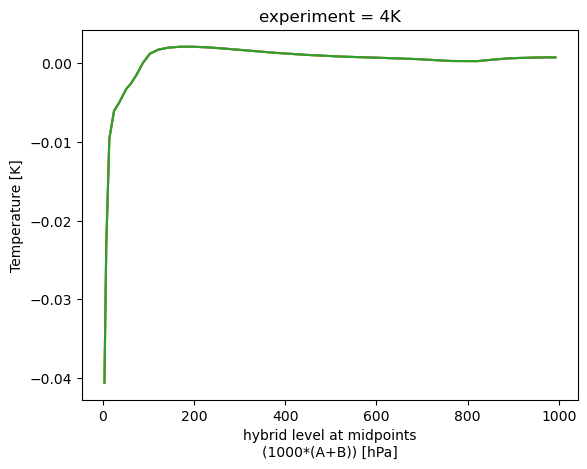

In [33]:
multi_experiment_vertical_temperature_gradient = xr.concat(
    [vertical_temperature_gradient[experiment] for experiment in experiments_list],
    dim=experiments_array
)

weights = np.cos(np.deg2rad(multi_experiment_vertical_temperature_gradient.lat))
weights.name = "weights"
experiment_mean_temperature_gradient = multi_experiment_vertical_temperature_gradient.weighted(weights).mean(
    dim=['time', 'lat', 'lon']
)
[experiment_mean_temperature_gradient.sel(experiment=experiment).plot() for experiment in experiments_list]

In [35]:
multi_experiment_vertical_temperature_gradient[:, 0, :, 0, 0]

<xarray.DataArray 'T' (experiment: 3, lev: 32)> Size: 384B
array([[-2.9285291e-02, -1.6198961e-02, -6.1874427e-03, -4.3384065e-03,
        -3.9331256e-03, -2.6015756e-03, -4.9011636e-04,  8.8749791e-04,
         1.4822660e-03,  1.6711855e-03,  8.2998088e-04, -4.7054800e-04,
        -9.3602686e-04, -5.4183928e-04,  2.2617457e-04,  9.1113796e-04,
         1.2957748e-03,  1.4402437e-03,  1.2784440e-03,  9.9577638e-04,
         8.3402160e-04,  9.2903560e-04,  6.4757495e-04,  6.3121486e-05,
         2.0925020e-04,  6.7884341e-04,  8.0320565e-04,  8.3398999e-04,
         8.2238374e-04,  8.1079802e-04,  8.0329948e-04,  8.0080028e-04],
       [-2.9285291e-02, -1.6198961e-02, -6.1874427e-03, -4.3384065e-03,
        -3.9331256e-03, -2.6015756e-03, -4.9011636e-04,  8.8749791e-04,
         1.4822660e-03,  1.6711855e-03,  8.2998088e-04, -4.7054800e-04,
        -9.3602686e-04, -5.4183928e-04,  2.2617457e-04,  9.1113796e-04,
         1.2957748e-03,  1.4402437e-03,  1.2784440e-03,  9.9577638e-04,
         8.3402160e-04,  9.2903560e-04,  6.4757495e-04,  6.3121486e-05,
         2.0925020e-04,  6.7884341e-04,  8.0320565e-04,  8.3398999e-04,
         8.2238374e-04,  8.1079802e-04,  8.0329948e-04,  8.0080028e-04],
       [-2.9285291e-02, -1.6198961e-02, -6.1874427e-03, -4.3384065e-03,
        -3.9331256e-03, -2.6015756e-03, -4.9011636e-04,  8.8749791e-04,
         1.4822660e-03,  1.6711855e-03,  8.2998088e-04, -4.7054800e-04,
        -9.3602686e-04, -5.4183928e-04,  2.2617457e-04,  9.1113796e-04,
         1.2957748e-03,  1.4402437e-03,  1.2784440e-03,  9.9577638e-04,
         8.3402160e-04,  9.2903560e-04,  6.4757495e-04,  6.3121486e-05,
         2.0925020e-04,  6.7884341e-04,  8.0320565e-04,  8.3398999e-04,
         8.2238374e-04,  8.1079802e-04,  8.0329948e-04,  8.0080028e-04]],
      dtype=float32)
Coordinates:
    lat         float64 8B -38.84
    lon         float64 8B 0.0
  * lev         (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
    time        object 8B 0003-01-03 00:00:00
  * experiment  (experiment) <U3 36B '-4K' '0K' '4K'
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

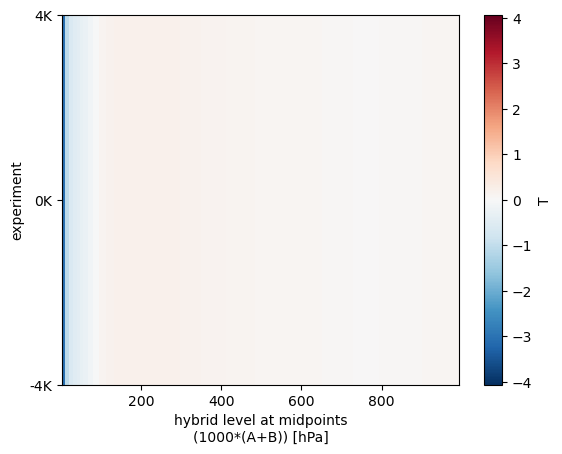

### Vertical Profile plotter

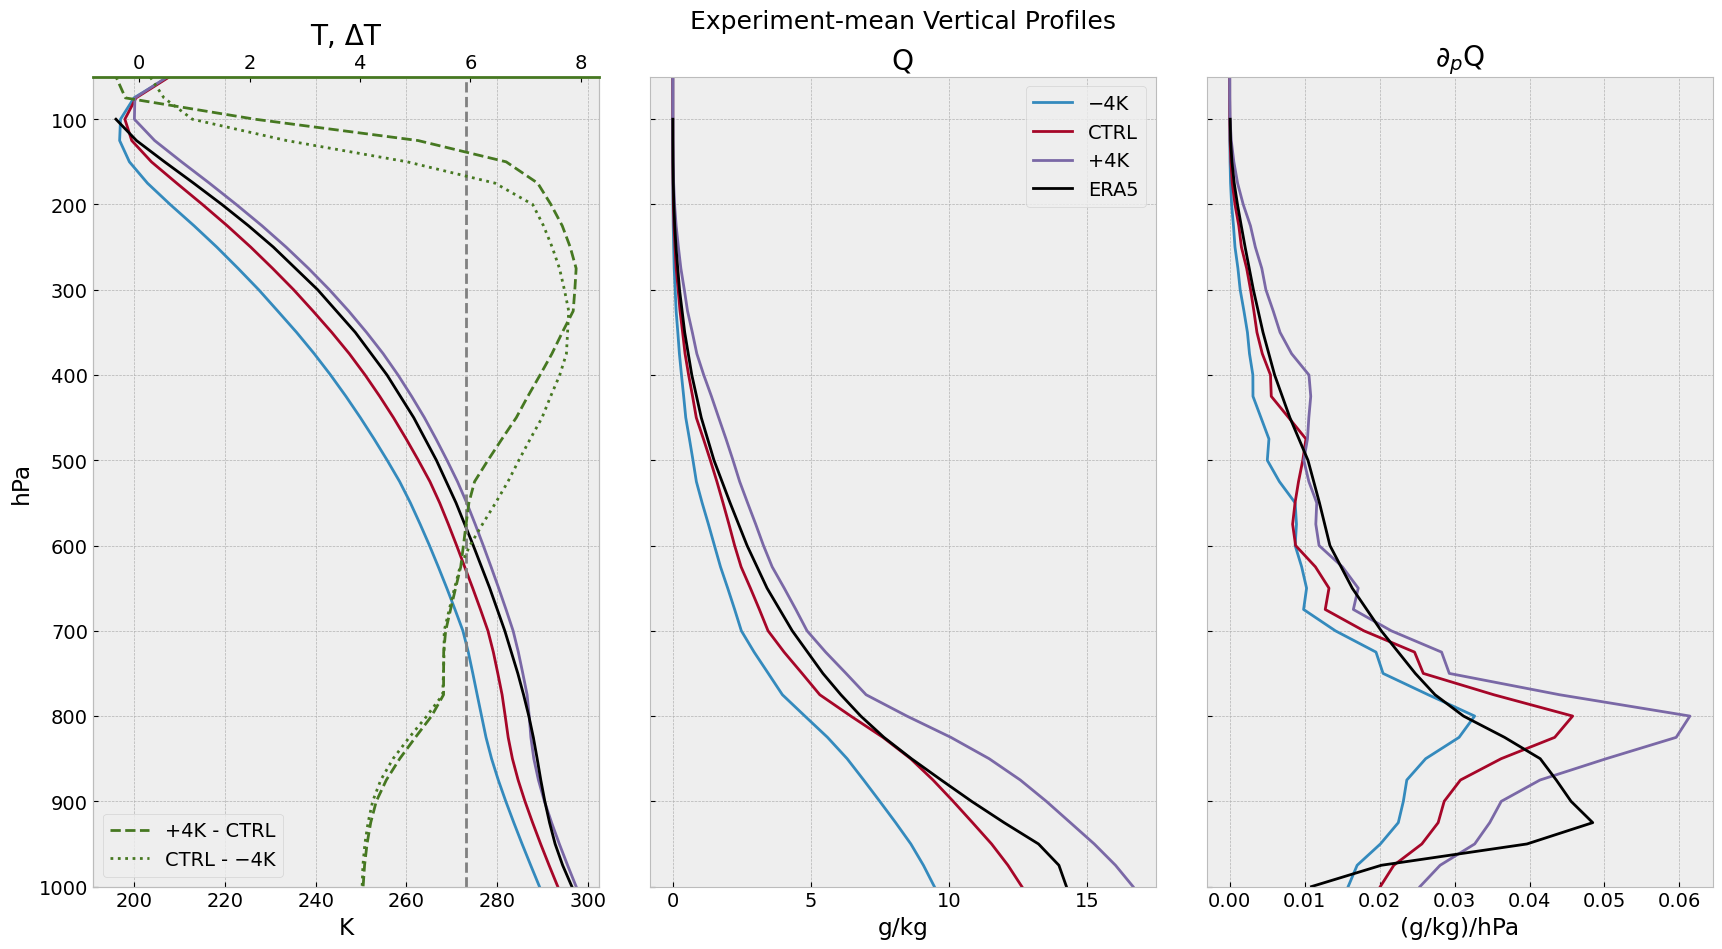

In [100]:
ERA5_temperature = xr.open_dataarray("/glade/campaign/univ/uwas0152/post_processed_data/ERA5_vertical_temperature_profile.nc")
ERA5_moisture = xr.open_dataarray("/glade/campaign/univ/uwas0152/post_processed_data/ERA5_vertical_moisture_profile.nc")

# Set plotting parameters
plt.style.use('bmh')
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams.update({'font.size':14})

# Create figure
fig = plt.figure(figsize=(18,9))
gs = GridSpec(1, 3, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, wspace=0.1)

axes = []
axes.append(fig.add_subplot(gs[0]))
axes.append(fig.add_subplot(gs[1]))
axes.append(fig.add_subplot(gs[2]))
# axes.append(fig.add_subplot(gs[3]))

# Plot temperature profile
axes[0].set_title('T, ΔT')
for index, experiment in enumerate(experiments_list):
    axes[0].plot(
        experiment_mean_temperature.sel(experiment=experiment),
        experiment_mean_temperature.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color = bmh_colors(index+1)
    )

axes[0].plot(
    ERA5_temperature,
    ERA5_temperature.plev,
    label='ERA5',
    color = 'k'
)
axes[0].set_xlabel('K')
axes[0].set_ylabel('hPa')
axes[0].axvline(x=273.15, ls='--', color='gray')

# Plot inter-experiment temperature differences
axes1 = axes[0].twiny()
axes1.spines['top'].set_color(bmh_colors(4))
axes1.spines['top'].set_linewidth(2)
axes1.plot(
    (
        experiment_mean_temperature.sel(experiment='4K')
        - experiment_mean_temperature.sel(experiment='0K')
    ),
    experiment_mean_temperature.plev,
    color = bmh_colors(4),
    ls='--',
    label = '+4K - CTRL'
)
axes1.plot(
    (
        experiment_mean_temperature.sel(experiment='0K')
        - experiment_mean_temperature.sel(experiment='-4K')
    ),
    experiment_mean_temperature.plev,
    color = bmh_colors(4),
    ls=':',
    label = 'CTRL - −4K'
)
# axes1.set_xlabel('K', loc='right')
axes1.legend(loc='lower left')
axes1.grid(False)

# Plot vertical moisture profile
axes[1].set_title('Q')
for index, experiment in enumerate(experiments_list):
    axes[1].plot(
        1000*experiment_mean_moisture.sel(experiment=experiment),
        experiment_mean_moisture.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color = bmh_colors(index+1)
    )

axes[1].plot(
    1000*ERA5_moisture,
    ERA5_moisture.plev,
    label='ERA5',
    color = 'k'
)

axes[1].set_xlabel('g/kg')
axes[1].set_xticks(np.arange(0, 20, 5))
axes[1].legend(loc='upper right')

# Plot vertical moisture gradient profile
axes[2].set_title(r'$\partial_{p}$Q')
for index, experiment in enumerate(experiments_list):
    axes[2].plot(
        1000*experiment_mean_moisture.sel(experiment=experiment).differentiate('plev'),
        experiment_mean_moisture.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
        color = bmh_colors(index+1)
    )

axes[2].plot(
    1000*ERA5_moisture.differentiate('plev'),
    ERA5_moisture.plev,
    label='ERA5',
    color = 'k'
)

axes[2].set_xlabel('(g/kg)/hPa')

fig.suptitle(
    "Experiment-mean Vertical Profiles",
    x=(axes[0].get_position().x0 + axes[2].get_position().x1)/2,
    ha='center',
    y=1.025,
    fontsize=18
)

# Format axes
for index, ax in enumerate(axes):
    if index == 0:
        ax.set_yticks(np.arange(0, 1100, 100), labels=np.arange(0, 1100, 100))
    else:
        ax.set_yticks(ticks=np.arange(0, 1100, 100), labels=[])
    ax.set_ylim(50, 1000)
    ax.invert_yaxis()

plt.show()

In [46]:
def plot_vertical_profile(variable_to_plot, lat_bounds=slice(-10,10), zero_bounded=False):

    experiment_mean_variable_to_plot = variable_to_plot.sel(lat=lat_bounds).mean(dim=['time', 'lat', 'lon'])

    plt.style.use('bmh')
    plt.rcParams.update(
        {
        'font.size':14,
        'mathtext.fontset':'dejavusans'
        }
    )
    [fig, ax] = plt.subplots(1, 1, figsize=(4.5,9))

    ax.set_title(f"Experiment-mean {variable_to_plot.attrs['short_name']} \nVertical Profile ", pad=10)
    for experiment in experiments_array.coords['experiment']:
        ax.plot(
            experiment_mean_variable_to_plot.sel(experiment=experiment),
            experiment_mean_variable_to_plot.plev,
            label=experiments_array.sel(experiment=experiment)['name'].item(),
        )

    ax.set_xlabel(f"{experiment_mean_variable_to_plot.attrs['units']}")
    ax.set_ylabel('hPa')
    ax.legend(loc='lower left')

    if zero_bounded == True:
        if np.all(experiment_mean_variable_to_plot.values) >= 0:
            ax.set_xlim(left=0)
        elif np.all(experiment_mean_variable_to_plot.values) <= 0:
            ax.set_xlim(right=0)
        else:
            print("Data not single-signed")

    ax.set_yticks(np.arange(0, 1100, 100))
    ax.set_ylim(100, 1000)
    ax.invert_yaxis()
    for side in ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set(lw=2)
        ax.spines[side].set(color="#bcbcbc")

    plt.show()

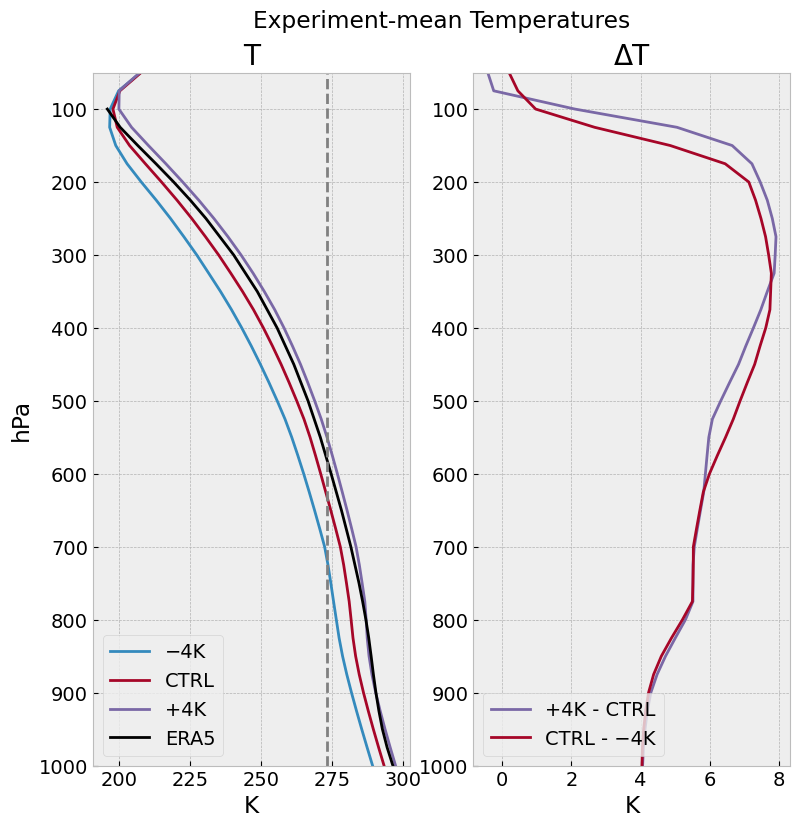

In [94]:
ERA5_temperature = xr.open_dataarray("/glade/campaign/univ/uwas0152/post_processed_data/ERA5_vertical_temperature_profile.nc")

plt.style.use('bmh')
plt.rcParams.update({'font.size':14})
[fig, axes] = plt.subplots(1, 2, figsize=(9,9))

fig.suptitle(
    "Experiment-mean Temperatures",
    x=(axes[0].get_position().x0 + axes[1].get_position().x1)/2,
    ha='center',
    y=0.95
)
axes[0].set_title('T')
for experiment in experiments_array.coords['experiment']:
    axes[0].plot(
        experiment_mean_temperature.sel(experiment=experiment),
        experiment_mean_temperature.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
    )

axes[0].plot(
    ERA5_temperature,
    ERA5_temperature.plev,
    label="ERA5",
    color='k'
)

axes[0].set_xlabel('K')
axes[0].set_ylabel('hPa')
axes[0].axvline(x=273.15, ls='--', color='gray')
axes[0].legend(loc='lower left')

axes[1].set_title('ΔT')
axes[1].plot(
    (
        experiment_mean_temperature.sel(experiment='4K')
        - experiment_mean_temperature.sel(experiment='0K')
    ),
    experiment_mean_temperature.plev,
    color = bmh_colors(3),
    label = '+4K - CTRL'
)
axes[1].plot(
    (
        experiment_mean_temperature.sel(experiment='0K')
        - experiment_mean_temperature.sel(experiment='-4K')
    ),
    experiment_mean_temperature.plev,
    color = bmh_colors(2),
    label = 'CTRL - −4K'
)
axes[1].set_xlabel('K')
axes[1].legend(loc='lower left')

for ax in axes:
    ax.set_yticks(np.arange(0, 1100, 100))
    ax.set_ylim(50, 1000)
    ax.invert_yaxis()

plt.show()

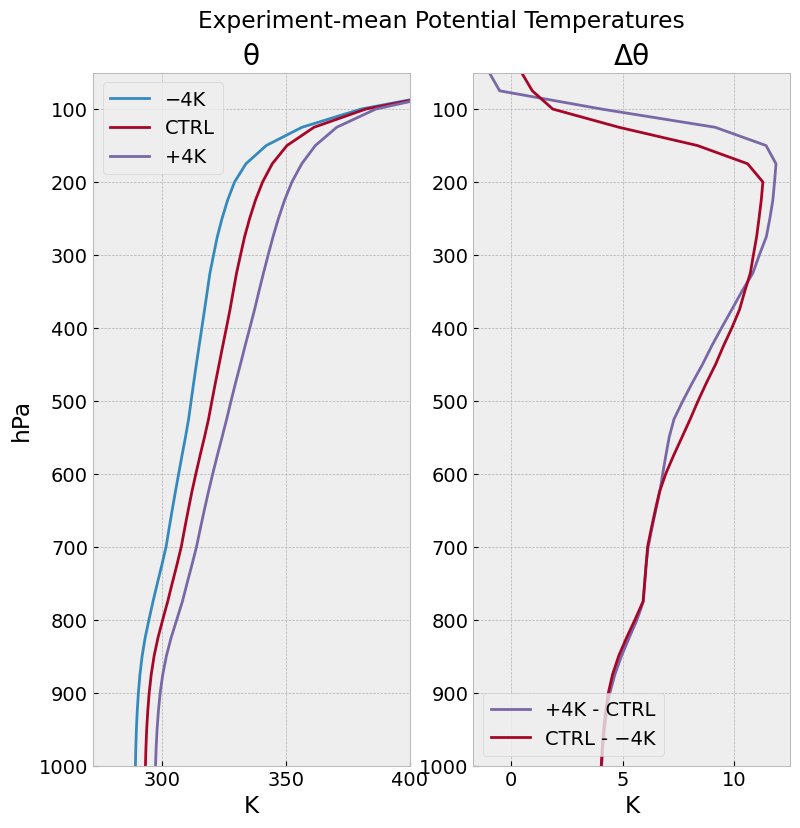

In [85]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':14})
[fig, axes] = plt.subplots(1, 2, figsize=(9,9))

fig.suptitle(
    "Experiment-mean Potential Temperatures",
    x=(axes[0].get_position().x0 + axes[1].get_position().x1)/2,
    ha='center',
    y=0.95
)
axes[0].set_title('θ')
for experiment in experiments_array.coords['experiment']:
    axes[0].plot(
        experiment_mean_potential_temperature.sel(experiment=experiment),
        experiment_mean_potential_temperature.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
    )

axes[0].set_xlabel('K')
axes[0].set_xlim(right=400)
axes[0].set_ylabel('hPa')
# axes[0].axvline(x=273.15, ls='--', color='gray')
axes[0].legend(loc='best')

axes[1].set_title('Δθ')
axes[1].plot(
    (
        experiment_mean_potential_temperature.sel(experiment='4K')
        - experiment_mean_potential_temperature.sel(experiment='0K')
    ),
    experiment_mean_potential_temperature.plev,
    color = bmh_colors(3),
    label = '+4K - CTRL'
)
axes[1].plot(
    (
        experiment_mean_potential_temperature.sel(experiment='0K')
        - experiment_mean_potential_temperature.sel(experiment='-4K')
    ),
    experiment_mean_potential_temperature.plev,
    color = bmh_colors(2),
    label = 'CTRL - −4K'
)
axes[1].set_xlabel('K')
axes[1].legend(loc='lower left')

# for experiment in experiments_array.coords['experiment']:
#     axes[2].plot(
#         experiment_mean_potential_temperature.sel(experiment=experiment).differentiate('plev'),
#         experiment_mean_potential_temperature.plev,
#         label=experiments_array.sel(experiment=experiment)['name'].item(),
#     )

# axes[2].set_xlabel('K/hPa')
# axes[2].set_xlim(-0.25, 0.0)
# axes[2].set_ylabel('hPa')
# # axes[0].axvline(x=273.15, ls='--', color='gray')
# axes[2].legend(loc='lower left')


for ax in axes:
    ax.set_yticks(np.arange(0, 1100, 100))
    ax.set_ylim(50, 1000)
    ax.invert_yaxis()

plt.show()

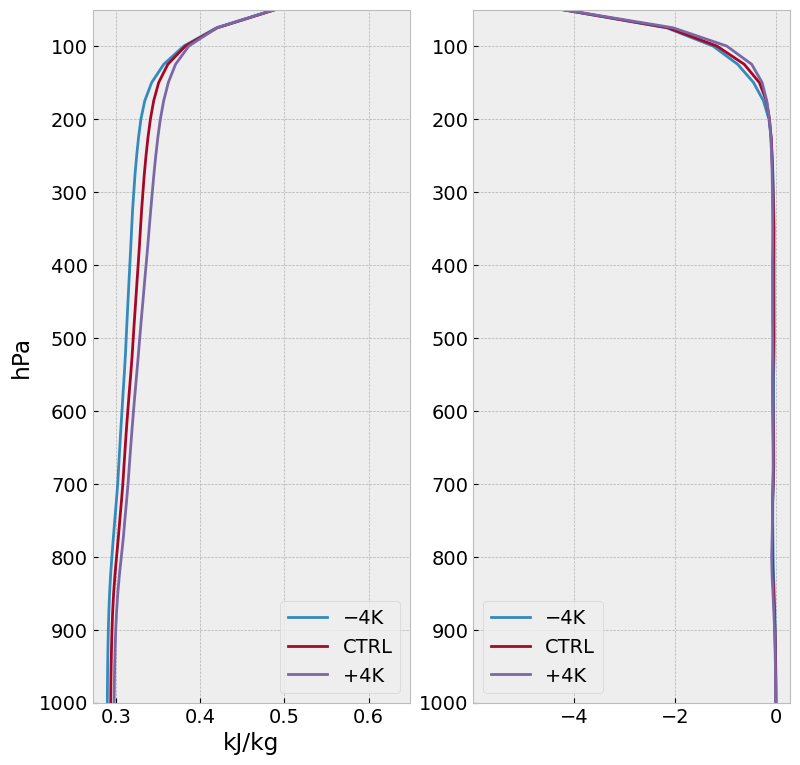

In [8]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':14})
[fig, axes] = plt.subplots(1, 2, figsize=(9,9))

# fig.suptitle(
#     "Experiment-mean MSE",
#     x=(axes[0].get_position().x0 + axes[1].get_position().x1)/2,
#     ha='center',
#     y=0.95
# )
# axes[0].set_title('MSE')
for experiment in experiments_array.coords['experiment']:
    axes[0].plot(
        (1/1000)*experiment_mean_potential_temperature.sel(experiment=experiment),
        experiment_mean_potential_temperature.plev,
        label=experiments_array.sel(experiment=experiment)['name'].item(),
    )

axes[0].set_xlabel('kJ/kg')
axes[0].set_ylabel('hPa')
axes[0].legend(loc='lower right')

# axes[0].set_title(r'$\partial_{p}$MSE')
for experiment in experiments_array.coords['experiment']:
    axes[1].plot(
        experiment_mean_potential_temperature.sel(experiment=experiment).differentiate('plev'),
        experiment_mean_potential_temperature.plev,
        label = experiments_array.sel(experiment=experiment)['name'].item(),
    )

# axes[1].set_xlabel('(kJ/kg)/hPa')
axes[1].legend(loc='lower left')
# axes[1].set_xlim(-100, 100)

for ax in axes:
    ax.set_yticks(np.arange(0, 1100, 100))
    ax.set_ylim(50, 1000)
    ax.invert_yaxis()

plt.show()

In [10]:
multi_experiment_variables_subset['Precipitation']

<xarray.DataArray 'Precipitation' (experiment: 3, time: 3648, lat: 34, lon: 144)> Size: 429MB
array([[[[1.83108903e-05, 6.19001861e-06, 1.15386168e-03, ...,
          2.29598407e-01, 1.31941258e-03, 1.31415613e-03],
         [8.60412925e-02, 2.70023314e-03, 1.90123589e-02, ...,
          1.60544738e-02, 4.53847272e-04, 9.00778672e-03],
         [4.41443490e-02, 6.25117258e-03, 2.96444653e-02, ...,
          3.37916536e-01, 2.35080940e-01, 3.22804103e-02],
         ...,
         [7.64861262e-02, 2.35367262e-02, 2.19202101e-03, ...,
          4.40568132e-01, 4.57026954e-01, 2.73735716e-01],
         [3.01176620e-02, 1.98509057e-02, 1.28206689e-02, ...,
          4.07538528e-01, 3.60082907e-01, 3.01470298e-01],
         [4.10508159e-01, 2.46730514e-01, 8.93607652e-02, ...,
          1.03304711e+00, 6.93654158e-01, 5.71985467e-01]],

        [[9.15698292e-04, 4.31483784e-06, 1.14618025e-03, ...,
          4.78062083e-01, 5.21831890e-02, 6.30607486e-03],
         [1.25707349e-01, 3.17145470e-03, 4.56196268e-05, ...,
          7.30358391e-01, 2.94521406e-01, 7.71998145e-02],
         [1.15810314e-03, 7.70350109e-04, 2.58511314e-05, ...,
          1.22827099e+00, 2.16353054e-01, 9.20845064e-02],
...
         [1.16682776e+00, 5.85095415e-01, 2.90616542e-01, ...,
          1.53209720e+00, 1.52047007e+00, 1.38302645e+00],
         [7.85741571e-01, 4.64550254e-01, 2.15932833e-01, ...,
          9.08931298e-01, 9.78706728e-01, 1.06849889e+00],
         [6.09093000e-01, 5.03246353e-01, 3.16077455e-01, ...,
          6.78383020e-01, 5.06277068e-01, 6.39031650e-01]],

        [[2.59525321e-02, 1.23072864e-01, 3.48671760e-01, ...,
          8.46072396e-02, 1.09849995e-01, 3.63284778e-02],
         [2.26832326e-01, 1.66907198e-01, 1.56077893e-01, ...,
          3.76678119e-03, 5.82322710e-03, 4.23062337e-02],
         [2.87443784e-01, 2.13084066e-01, 1.91211335e-01, ...,
          1.23897169e-02, 3.03467593e-01, 2.99503679e-01],
         ...,
         [9.47723436e-01, 2.80014488e-01, 1.25578188e-01, ...,
          1.85694880e+00, 1.71182180e+00, 1.42840445e+00],
         [9.82567218e-01, 7.16572606e-01, 4.79596778e-01, ...,
          1.10928140e+00, 1.18073011e+00, 1.11829427e+00],
         [6.00093824e-01, 6.35237232e-01, 7.03259607e-01, ...,
          6.24820426e-01, 4.66321842e-01, 6.36000436e-01]]]])
Coordinates:
  * lat         (lat) float64 272B -31.26 -29.37 -27.47 ... 27.47 29.37 31.26
  * lon         (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time        (time) object 29kB 0003-01-03 00:00:00 ... 0013-01-03 00:00:00
  * experiment  (experiment) <U3 36B '-4K' '0K' '4K'
Attributes:
    description:  Sum of large scale and convective precipitation
    units:        mm day$^{-1}$
    file_id:      PRCP
    short_name:   PRCP
    subset:       True

In [32]:
dry_static_energy = (
    SPECIFIC_HEAT*multi_experiment_variables_subset['Temperature']
    + GRAVITY*multi_experiment_variables_subset['Geopotential Height']
)
latent_heat = HEAT_OF_VAPORIZATION*multi_experiment_variables_subset['Moisture']

In [43]:
gross_dry_stability = -(800*100/9.81)*(multi_experiment_variables_subset['Vertical Wind']*dry_static_energy.differentiate('plev')/100).sel(plev=slice(100,950)).integrate('plev')

In [44]:
gross_dry_stability.mean(dim=['time', 'lat', 'lon'])

<xarray.DataArray (experiment: 3)> Size: 24B
array([17639.23143904, 16523.41285523,            nan])
Coordinates:
  * experiment  (experiment) <U3 36B '-4K' '0K' '4K'

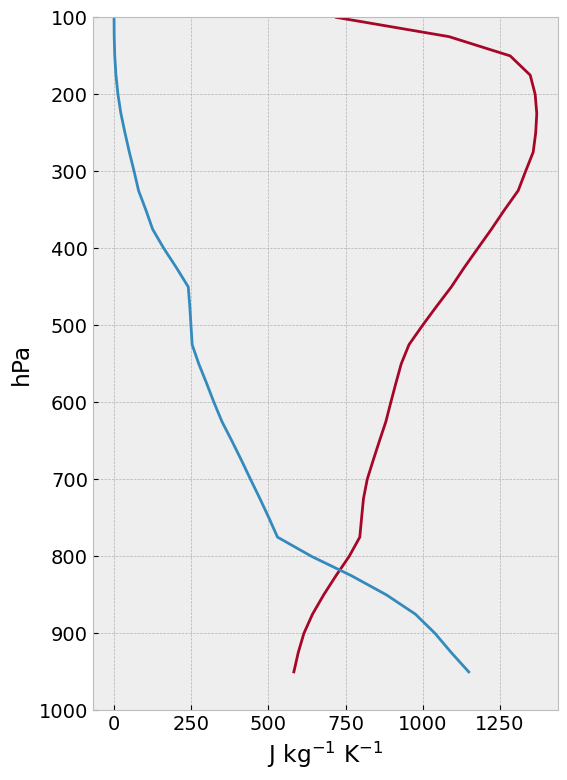

In [15]:
global_mean_temperature_warming = (
    multi_experiment_variables_subset['Temperature'].sel(experiment='4K').mean()
    - multi_experiment_variables_subset['Temperature'].sel(experiment='0K').mean()
)

plt.style.use('bmh')
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams.update({'font.size':14})
[fig, ax] = plt.subplots(1, 1, figsize=(6,9))

ax.plot(
    (
        dry_static_energy.sel(experiment='4K').mean(dim=['time', 'lat', 'lon'])
        - dry_static_energy.sel(experiment='0K').mean(dim=['time', 'lat', 'lon'])
    )/global_mean_temperature_warming,
    dry_static_energy.plev,
    color=bmh_colors('red')
)

ax.plot(
    (
        latent_heat.sel(experiment='4K').mean(dim=['time', 'lat', 'lon'])
        - latent_heat.sel(experiment='0K').mean(dim=['time', 'lat', 'lon'])
    )/global_mean_temperature_warming,
    latent_heat.plev,
    color=bmh_colors('blue')
)

ax.set_xlabel(r"J kg$^{-1}$ K$^{-1}$")
ax.set_yticks(np.arange(0, 1100, 100))
ax.set_ylim(100, 1000)
ax.invert_yaxis()
ax.set_ylabel('hPa')
plt.show()

## Meridional Moisture Gradient

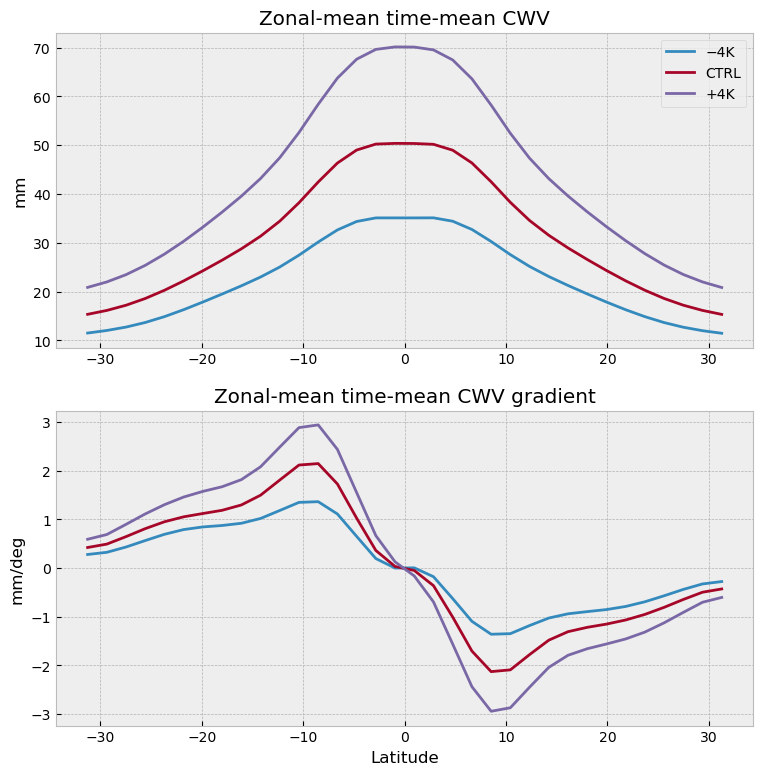

In [18]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(2, 1, figsize=(9,9))
ax[0].set_title("Zonal-mean time-mean CWV")
ax[1].set_title("Zonal-mean time-mean CWV gradient")
for experiment in experiments_list:
    ax[0].plot(
        multi_experiment_variables_subset['Moisture'].lat,
        multi_experiment_variables_subset['Column Water Vapor'].sel(experiment=experiment).mean(dim=['time', 'lon']),
        label=experiments_array.sel(experiment=experiment)['name'].item(),
    )
    ax[1].plot(
        multi_experiment_variables_subset['Moisture'].lat,
        multi_experiment_variables_subset['Column Water Vapor'].sel(experiment=experiment).mean(dim=['time', 'lon']).differentiate('lat'),
    )
ax[0].legend()
ax[0].set_ylabel('mm')
ax[1].set_ylabel('mm/deg')
ax[1].set_xlabel('Latitude')

plt.show()

In [28]:
global_mean_temperature = multi_experiment_variables_subset['Temperature'].mean(dim=['time', 'lat', 'lon', 'plev'])
meridional_moisture_gradient = multi_experiment_variables_subset['Column Water Vapor'].mean(dim=['time', 'lon']).differentiate('lat')
near_equatorial_mean_meridional_moisture_gradient = meridional_moisture_gradient.sel(lat=slice(-10,0)).mean(dim='lat')
percent_change = 100*(
    near_equatorial_mean_meridional_moisture_gradient.sel(experiment='4K')
    - near_equatorial_mean_meridional_moisture_gradient.sel(experiment='0K')
)/near_equatorial_mean_meridional_moisture_gradient.sel(experiment='0K')
print(
    f"Change in zonal-mean time-mean meridional moisture gradient: "
      + f"{percent_change/(global_mean_temperature.sel(experiment='4K') - global_mean_temperature.sel(experiment='0K')):0.1f} %/K"
)

Change in zonal-mean time-mean meridional moisture gradient:5.6 %/K


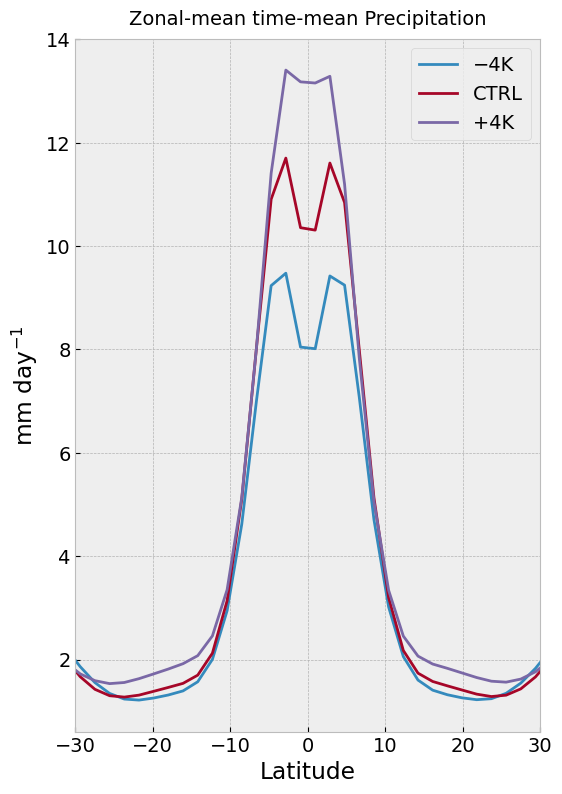

In [80]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 14
plt.rcParams['mathtext.fontset'] = 'dejavusans'
[fig, ax] = plt.subplots(1, 1, figsize=(6,9))
ax.set_title("Zonal-mean time-mean Precipitation", pad=10, fontsize=14)
for experiment in experiments_list:
    ax.plot(
        multi_experiment_variables_subset['Precipitation'].lat,
        multi_experiment_variables_subset['Precipitation'].sel(experiment=experiment).mean(dim=['time', 'lon']),
        label=experiments_array.sel(experiment=experiment)['name'].item(),
    )
ax.legend()
ax.set_ylabel(multi_experiment_variables_subset['Precipitation'].attrs['units'])
ax.set_xlabel('Latitude')
ax.set_xlim(-30,30)
ax.set_aspect('auto')

plt.show()

# Variance Plots

## Latitude-Longitude

In [18]:
print(
    (
        multi_experiment_variables_filtered['Precipitation'].sel(experiment='4K').std(dim='time')
        - multi_experiment_variables_filtered['Precipitation'].sel(experiment='0K').std(dim='time')
    ).sel(lat=slice(-10,10)).mean(dim=['lat', 'lon'])
)
print(
    (
        multi_experiment_variables_filtered['Vertical Wind'].sel(experiment='4K', plev=500).std(dim='time')
        - multi_experiment_variables_filtered['Vertical Wind'].sel(experiment='0K', plev=500).std(dim='time')
    ).sel(lat=slice(-10,10)).mean(dim=['lat', 'lon'])
)

<xarray.DataArray 'Precipitation' ()> Size: 8B
array(2.32085399)
Attributes:
    description:  Sum of large scale and convective precipitation
    units:        mm day$^{-1}$
    file_id:      PRCP
    short_name:   PRCP
    filtered:     True
<xarray.DataArray 'Vertical Wind' ()> Size: 8B
array(0.00265418)
Coordinates:
    plev     int64 8B 500
Attributes:
    description:  Vertical Wind
    units:        Pa s$^{-1}$
    file_id:      ω
    short_name:   ω
    filtered:     True


Variable: Precipitation


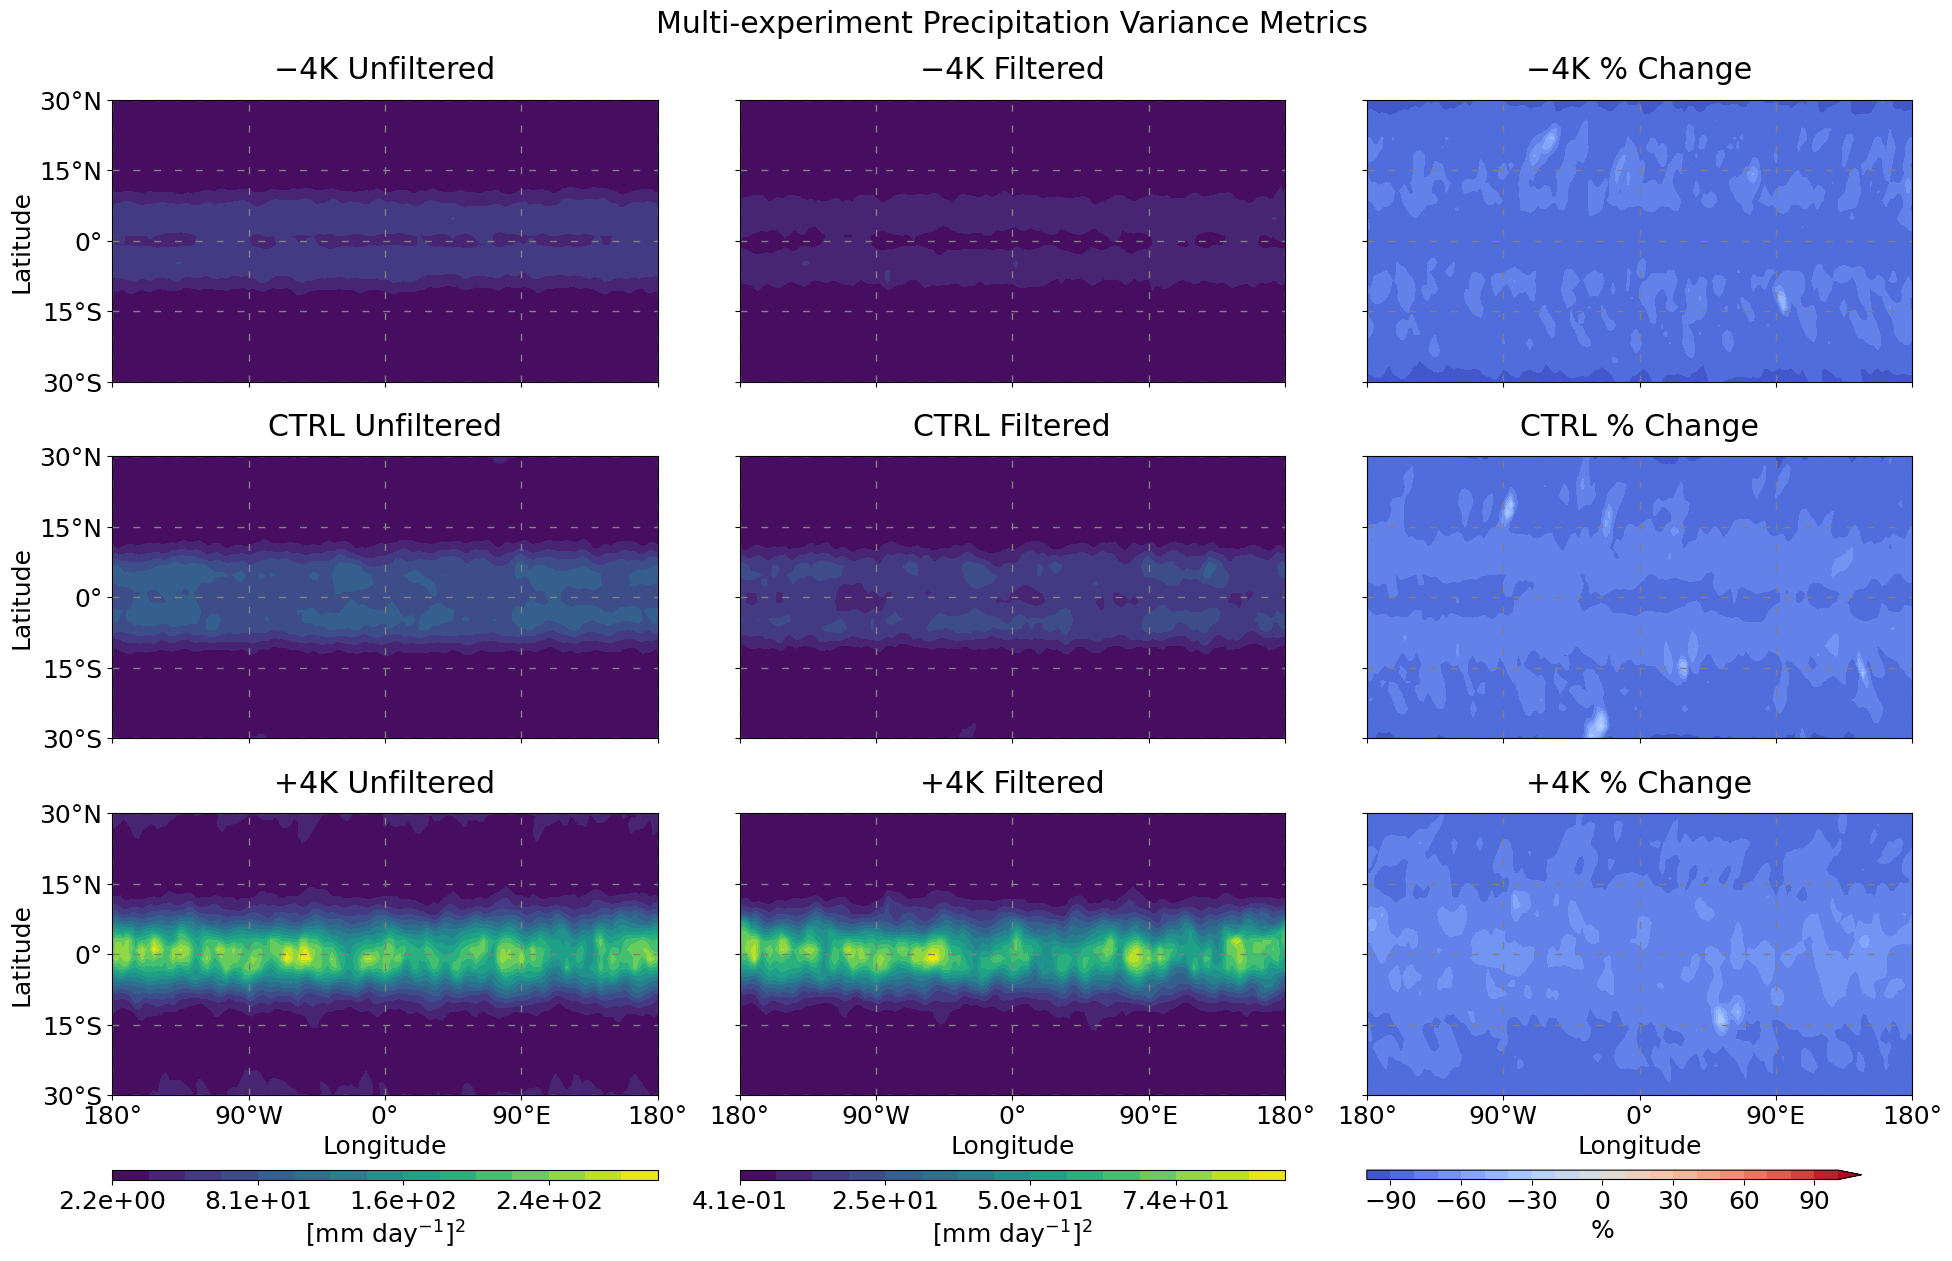

Variable: 850-hPa Zonal Wind


KeyboardInterrupt: 

In [13]:
plt.style.use("default")
fontsize=18
plt.rcParams.update({"font.size": fontsize})

output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False

variables_to_plot = [
    multi_experiment_variables_subset['Precipitation'],
    # multi_experiment_variables_subset['Outgoing Longwave Radiation'],
    # multi_experiment_variables_subset['Zonal Wind'].sel(plev=200),
    multi_experiment_variables_subset['Zonal Wind'].sel(plev=850),
    # multi_experiment_variables_subset['Geopotential Height'].sel(plev=200),
    # multi_experiment_variables_subset['Geopotential Height'].sel(plev=850),
    multi_experiment_variables_subset['Vertical Wind'].sel(plev=500),
    # multi_experiment_variables_subset['Moist Static Energy'].sel(plev=200),
    # multi_experiment_variables_subset['Moist Static Energy'].sel(plev=850),
    # multi_experiment_variables_subset['Column Temperature'],
    # multi_experiment_variables_subset['Column Water Vapor'],
    # multi_experiment_variables_subset['Column Longwave Heating'],
    # multi_experiment_variables_subset['Column Shortwave Heating'],
    # multi_experiment_variables_subset['Latent Heat Flux'],
    # multi_experiment_variables_subset['Sensible Heat Flux'],
]

for variable in variables_to_plot:
    print(
        "Variable:"
        + f"{(' ' + (str(variable.plev.values) + '-hPa') if 'plev' in variable.coords else '')}"
        + f" {variable.name}"
)

    unfiltered_data = variable.var(dim='time')
    if 'plev' in variable.coords:
        filtered_data = multi_experiment_variables_filtered[variable.name].sel(
            plev=variable.plev
        ).var(dim='time')
    else:
        filtered_data = multi_experiment_variables_filtered[variable.name].var(dim='time')
    variance_percentage = 100*((filtered_data-unfiltered_data)/unfiltered_data)

    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(4, 3, height_ratios=[30, 30, 30, 1], width_ratios=[1, 1, 1], figure=fig)
    gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.15)

    fig.suptitle(
        f"Multi-experiment"
        + f"{(' ' + (str(filtered_data.plev.values) + '-hPa') if 'plev' in filtered_data.coords else '')}"
        +f" {unfiltered_data.name} Variance Metrics",
        y=1.025
    )
    axes = {}
    cbar_axes = []
    cbar_axes.append(fig.add_subplot(gs[3, 0]))
    cbar_axes.append(fig.add_subplot(gs[3, 1]))
    cbar_axes.append(fig.add_subplot(gs[3, 2]))
    for experiment_index, experiment in enumerate(experiments_list):

        axes[experiment] = []
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 0]))
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 1]))
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 2]))

        # Plot unfiltered variance
        axes[experiment][0].set_title(f"{experiments_array.sel(experiment=experiment)['name'].item()} Unfiltered", pad=15)

        grand_max = unfiltered_data.max()
        grand_min = unfiltered_data.min()

        # Add cyclic point
        cdata, clon = cutil.add_cyclic_point(unfiltered_data.sel(experiment=experiment), coord=unfiltered_data.lon)

        # Plot data
        im0 = axes[experiment][0].contourf(
            clon,
            unfiltered_data.lat,
            cdata,
            cmap='viridis',
            levels=np.linspace(grand_min, grand_max, 16)
        )

        # Add colorbar
        cbar0 = fig.colorbar(
            im0,
            cax=cbar_axes[0],
            label=rf"[{unfiltered_data.attrs['units']}]$^2$",
            orientation="horizontal",
            format="%1.1e"
        )
        cbar0.ax.tick_params(labelsize=fontsize)
        cbar0.ax.locator_params(nbins=5)

        # Plot filtered variance
        axes[experiment][1].set_title(f"{experiments_array.sel(experiment=experiment)['name'].item()} Filtered", pad=15)

        grand_max = filtered_data.max()
        grand_min = filtered_data.min()
        # Add cyclic point
        cdata, clon = cutil.add_cyclic_point(filtered_data.sel(experiment=experiment), coord=filtered_data.lon)

        # Plot data
        im1 = axes[experiment][1].contourf(
            clon,
            filtered_data.lat,
            cdata,
            cmap='viridis',
            levels=np.linspace(grand_min, grand_max, 16)
        )

        # Add colorbar
        cbar1 = fig.colorbar(
            im1,
            cax=cbar_axes[1],
            label=rf"[{filtered_data.attrs['units']}]$^2$",
            orientation="horizontal",
            format="%1.1e"
        )
        cbar1.ax.tick_params(labelsize=fontsize)
        cbar1.ax.locator_params(nbins=5)

        # Plot variance percentage
        axes[experiment][2].set_title(f"{experiments_array.sel(experiment=experiment)['name'].item()} % Change", pad=15)

        # Add cyclic point
        cdata, clon = cutil.add_cyclic_point(variance_percentage.sel(experiment=experiment), coord=variance_percentage.lon)

        # Plot data
        im2 = axes[experiment][2].contourf(
            clon,
            variance_percentage.lat,
            cdata,
            cmap='coolwarm',
            levels=np.linspace(-100, 100, 21),
            # cmap='viridis',
            # levels=np.linspace(0, 50, 16),
            extend='max'
        )
        cbar2 = fig.colorbar(
            im2,
            cax=cbar_axes[2],
            label="%",
            orientation="horizontal",
        )
        cbar2.ax.tick_params(labelsize=fontsize)
        cbar2.ax.locator_params(nbins=7)

        for ax_index, ax in enumerate(axes[experiment]):

            # Axis parameters
            ax.set_aspect("auto")

            ax.set_xlim(0, 360)
            x_ticks = np.arange(0, 360 + 90, 90)
            ax.set_xticks(x_ticks)
            if experiment_index == 2:
                ax.set_xticklabels(tick_labeller(x_ticks-180, "lon"))
                # ax.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
                ax.set_xlabel("Longitude")
            else:
                ax.set_xticklabels('')

            ax.set_ylim(-30, 30)
            y_ticks = np.arange(-30, 45, 15)
            ax.set_yticks(y_ticks)
            if ax_index == 0:
                ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
                ax.set_ylabel("Latitude")
            else:
                ax.set_yticklabels('')

            grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
            ax.grid(True, **grid_kwargs)

    if not savefig:
        plt.show()
    else:
        save_string = (
            f"{experiment}_unfiltered"
          + f"_{variable.attrs['file_id']}"
          + f"{((str(variable.plev.values)) if 'plev' in variable.coords else '')}_variance.png"
            )
        print(f"Saving plot as {save_string}")
        plt.savefig(
            f"{output_directory}/variance/latitude-longitude/unfiltered/{save_string}",
            dpi=500,
            bbox_inches="tight",
        )

print(f"{'='*40}")
print("Finished")

In [24]:
precipitation_variance = multi_experiment_variables_filtered['Precipitation'].std(dim='time')
near_equatorial_mean_precipitation_variance = precipitation_variance.sel(lat=slice(-10,10)).mean(dim=["lat", "lon"])
precipitation_variance_change = 100*(
    near_equatorial_mean_precipitation_variance.sel(experiment = '0K') - near_equatorial_mean_precipitation_variance.sel(experiment = '-4K')
) / near_equatorial_mean_precipitation_variance.sel(experiment = '-4K')

zonal_wind_variance = multi_experiment_variables_filtered['Zonal Wind'].std(dim='time')
near_equatorial_mean_zonal_wind_variance = zonal_wind_variance.sel(lat=slice(-10,10), plev=850).mean(dim=["lat", "lon"])
zonal_wind_variance_change = 100*(
    near_equatorial_mean_zonal_wind_variance.sel(experiment = '0K') - near_equatorial_mean_zonal_wind_variance.sel(experiment = '-4K')
) / near_equatorial_mean_zonal_wind_variance.sel(experiment = '-4K')

vertical_wind_variance = multi_experiment_variables_filtered['Vertical Wind'].std(dim='time')
near_equatorial_mean_vertical_wind_variance = vertical_wind_variance.sel(lat=slice(-10,10), plev=500).mean(dim=["lat", "lon"])
vertical_wind_variance_change = 100*(
    near_equatorial_mean_vertical_wind_variance.sel(experiment = '0K') - near_equatorial_mean_vertical_wind_variance.sel(experiment = '-4K')
) / near_equatorial_mean_vertical_wind_variance.sel(experiment = '-4K')

In [25]:
print(precipitation_variance_change.values)
print(zonal_wind_variance_change.values)
print(vertical_wind_variance_change.values)

40.702807039507775
15.649394580111469
-0.8242325097879166


## Longitude-Height

Variable: Zonal Wind


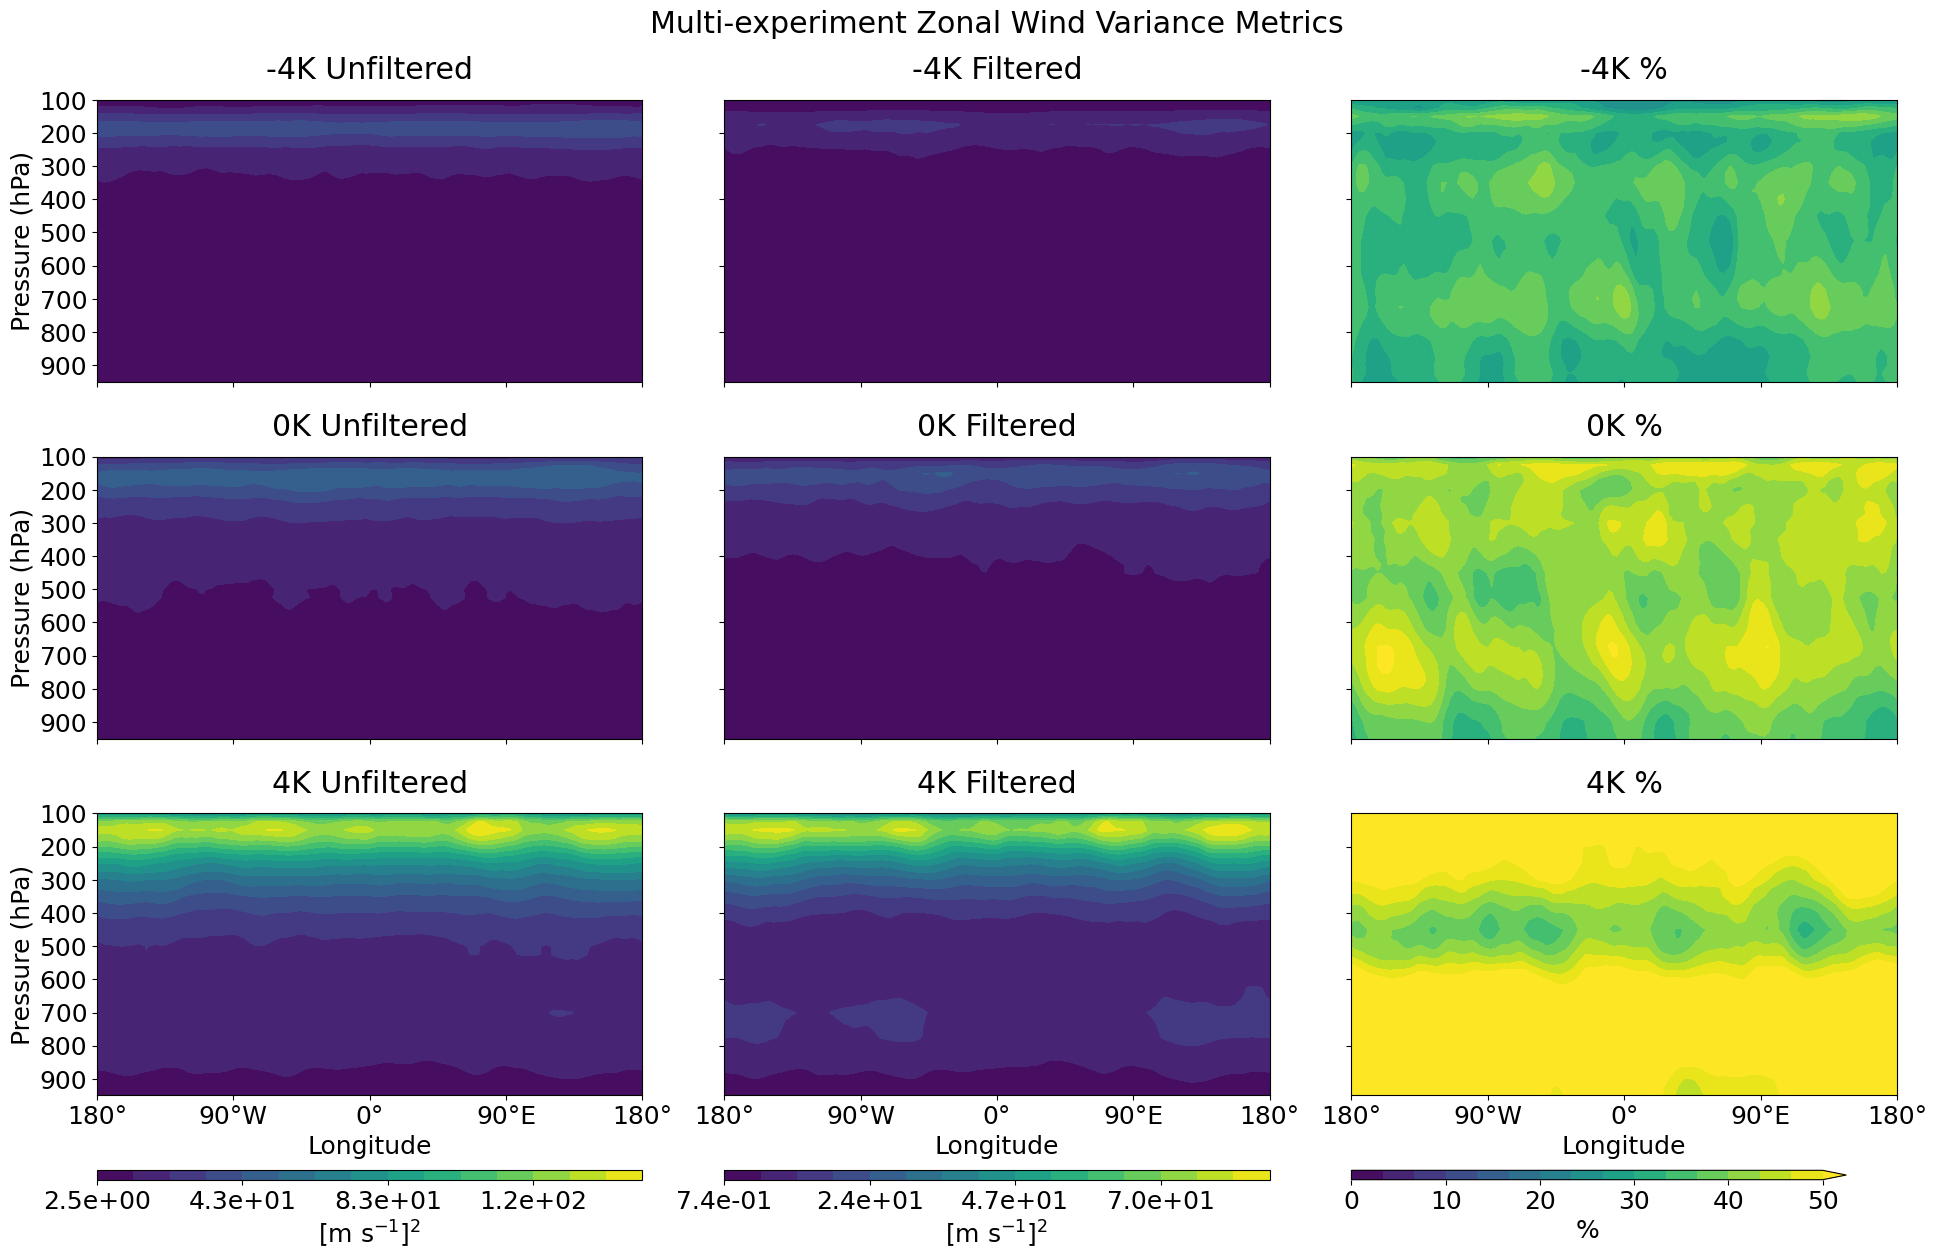

Variable: Meridional Wind


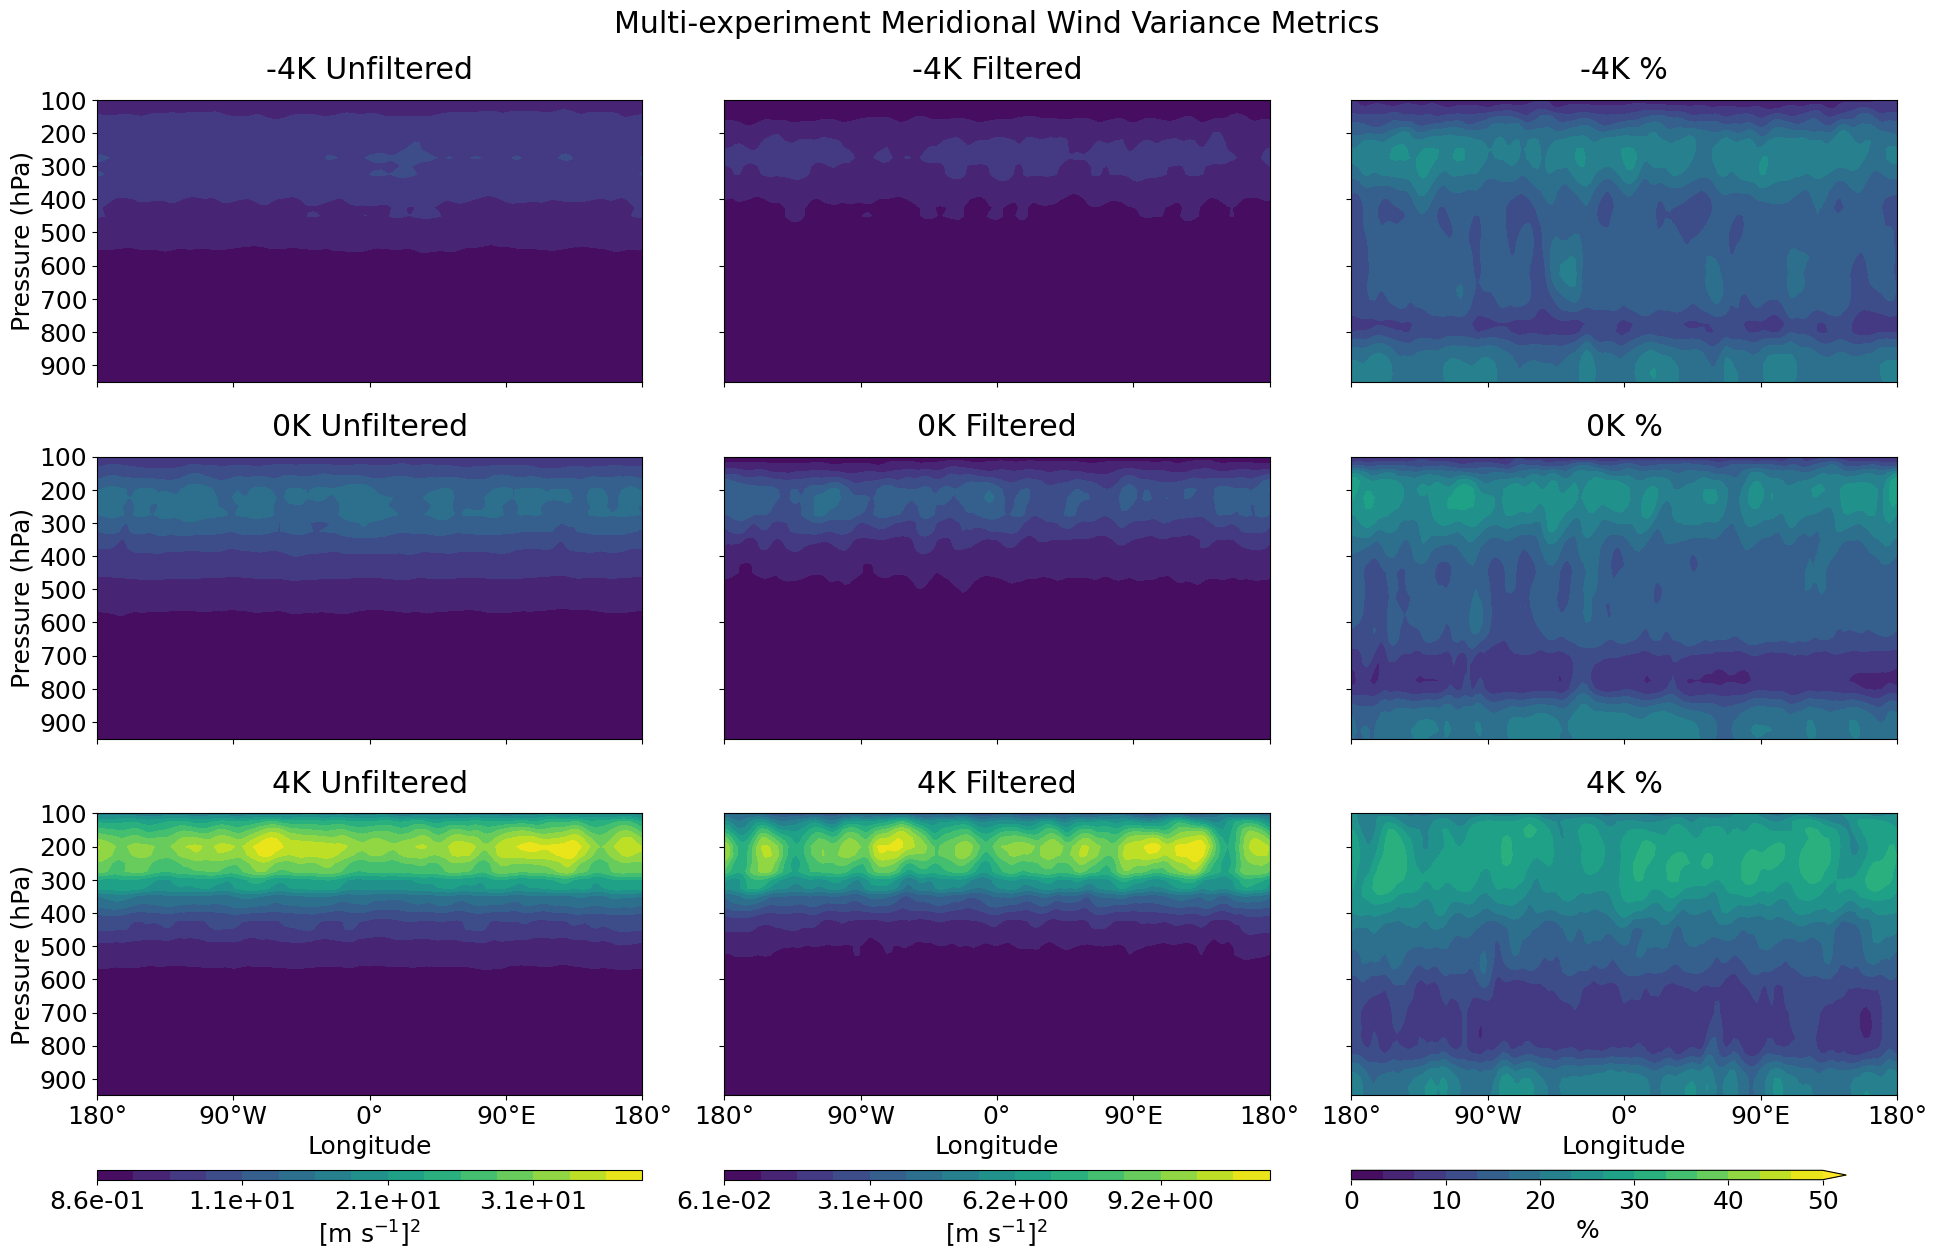

Variable: Vertical Wind


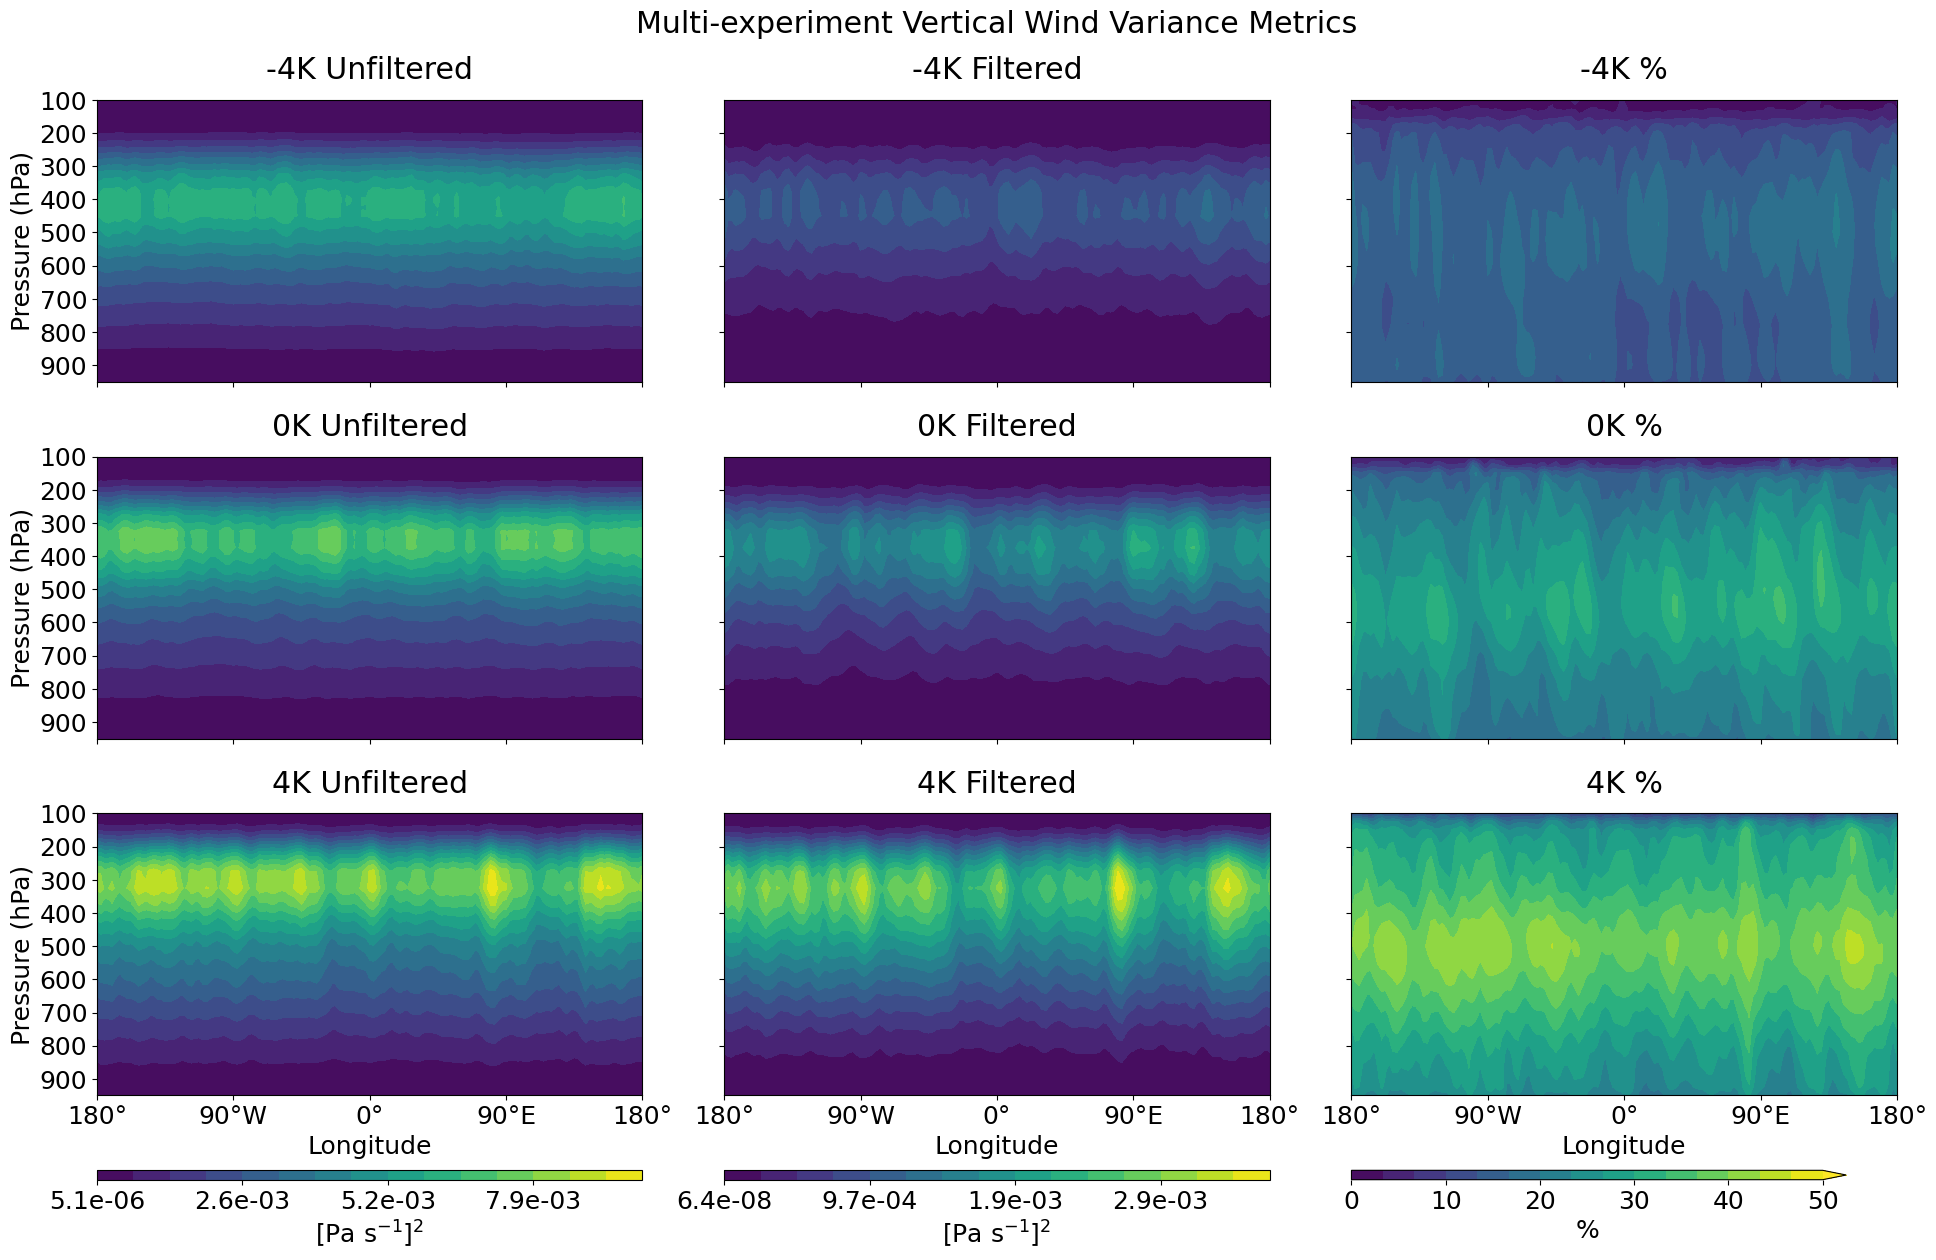

Variable: Temperature


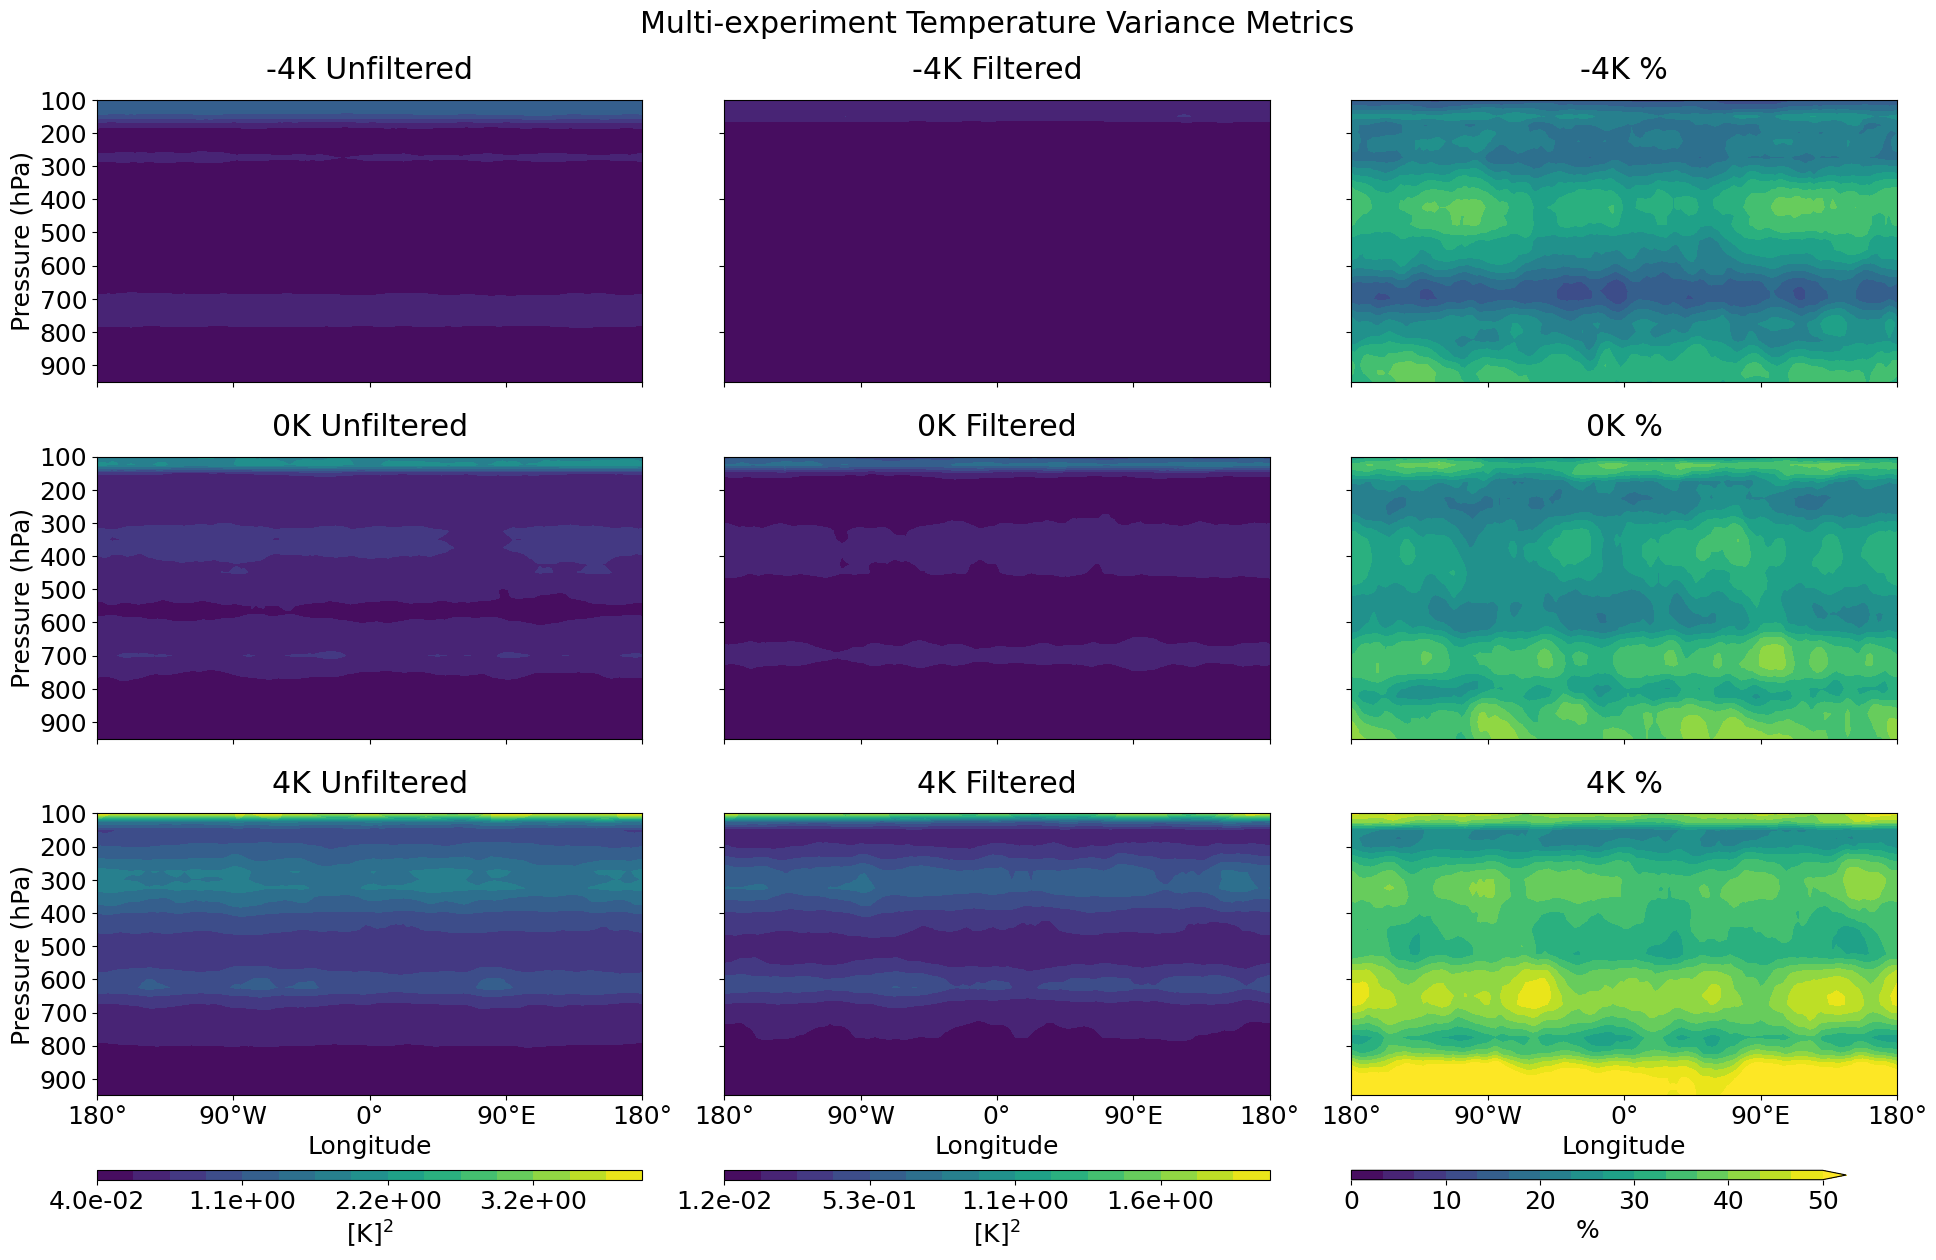

Variable: Moisture


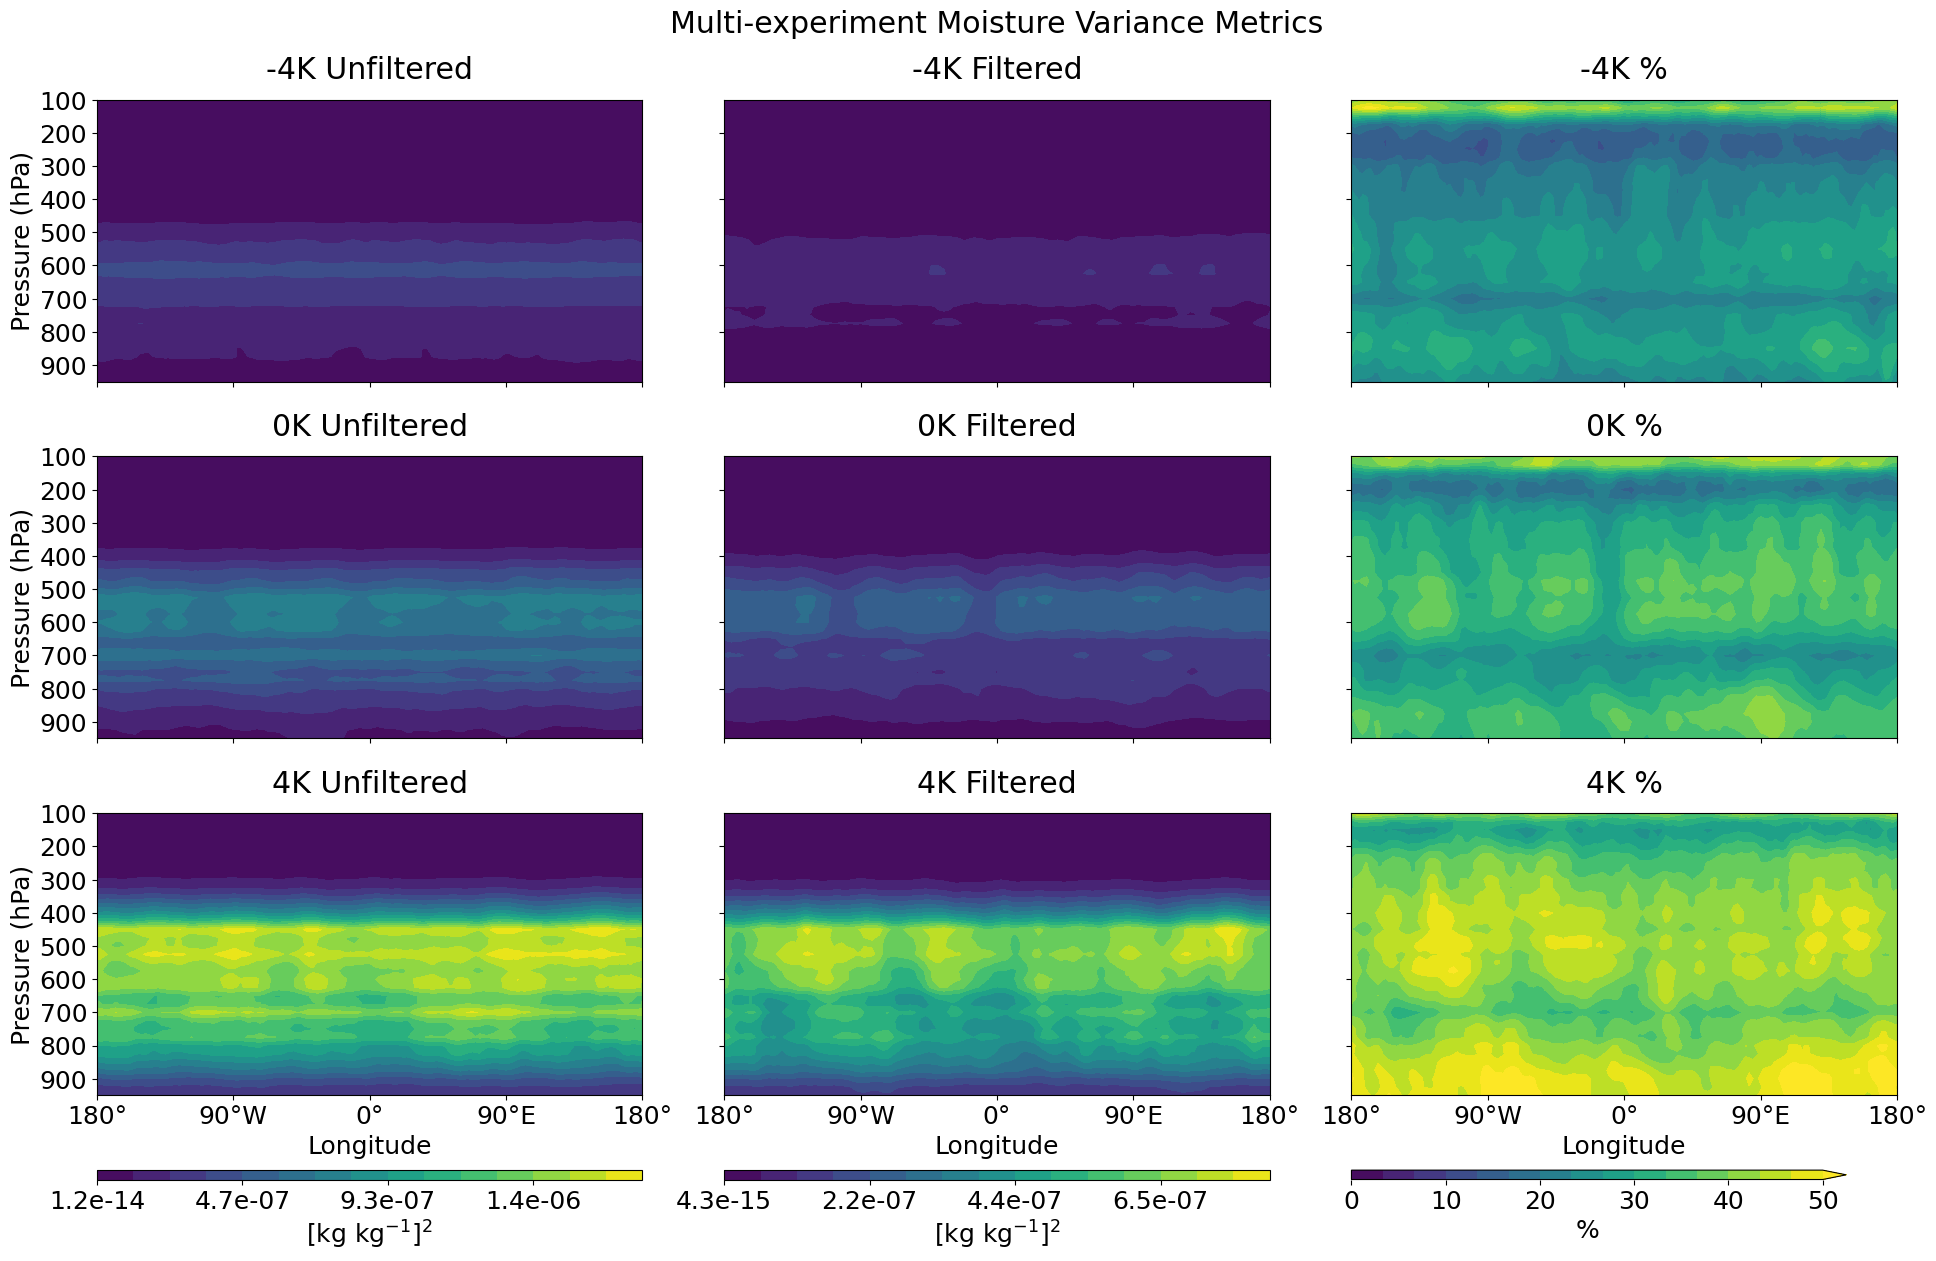

Variable: Geopotential Height


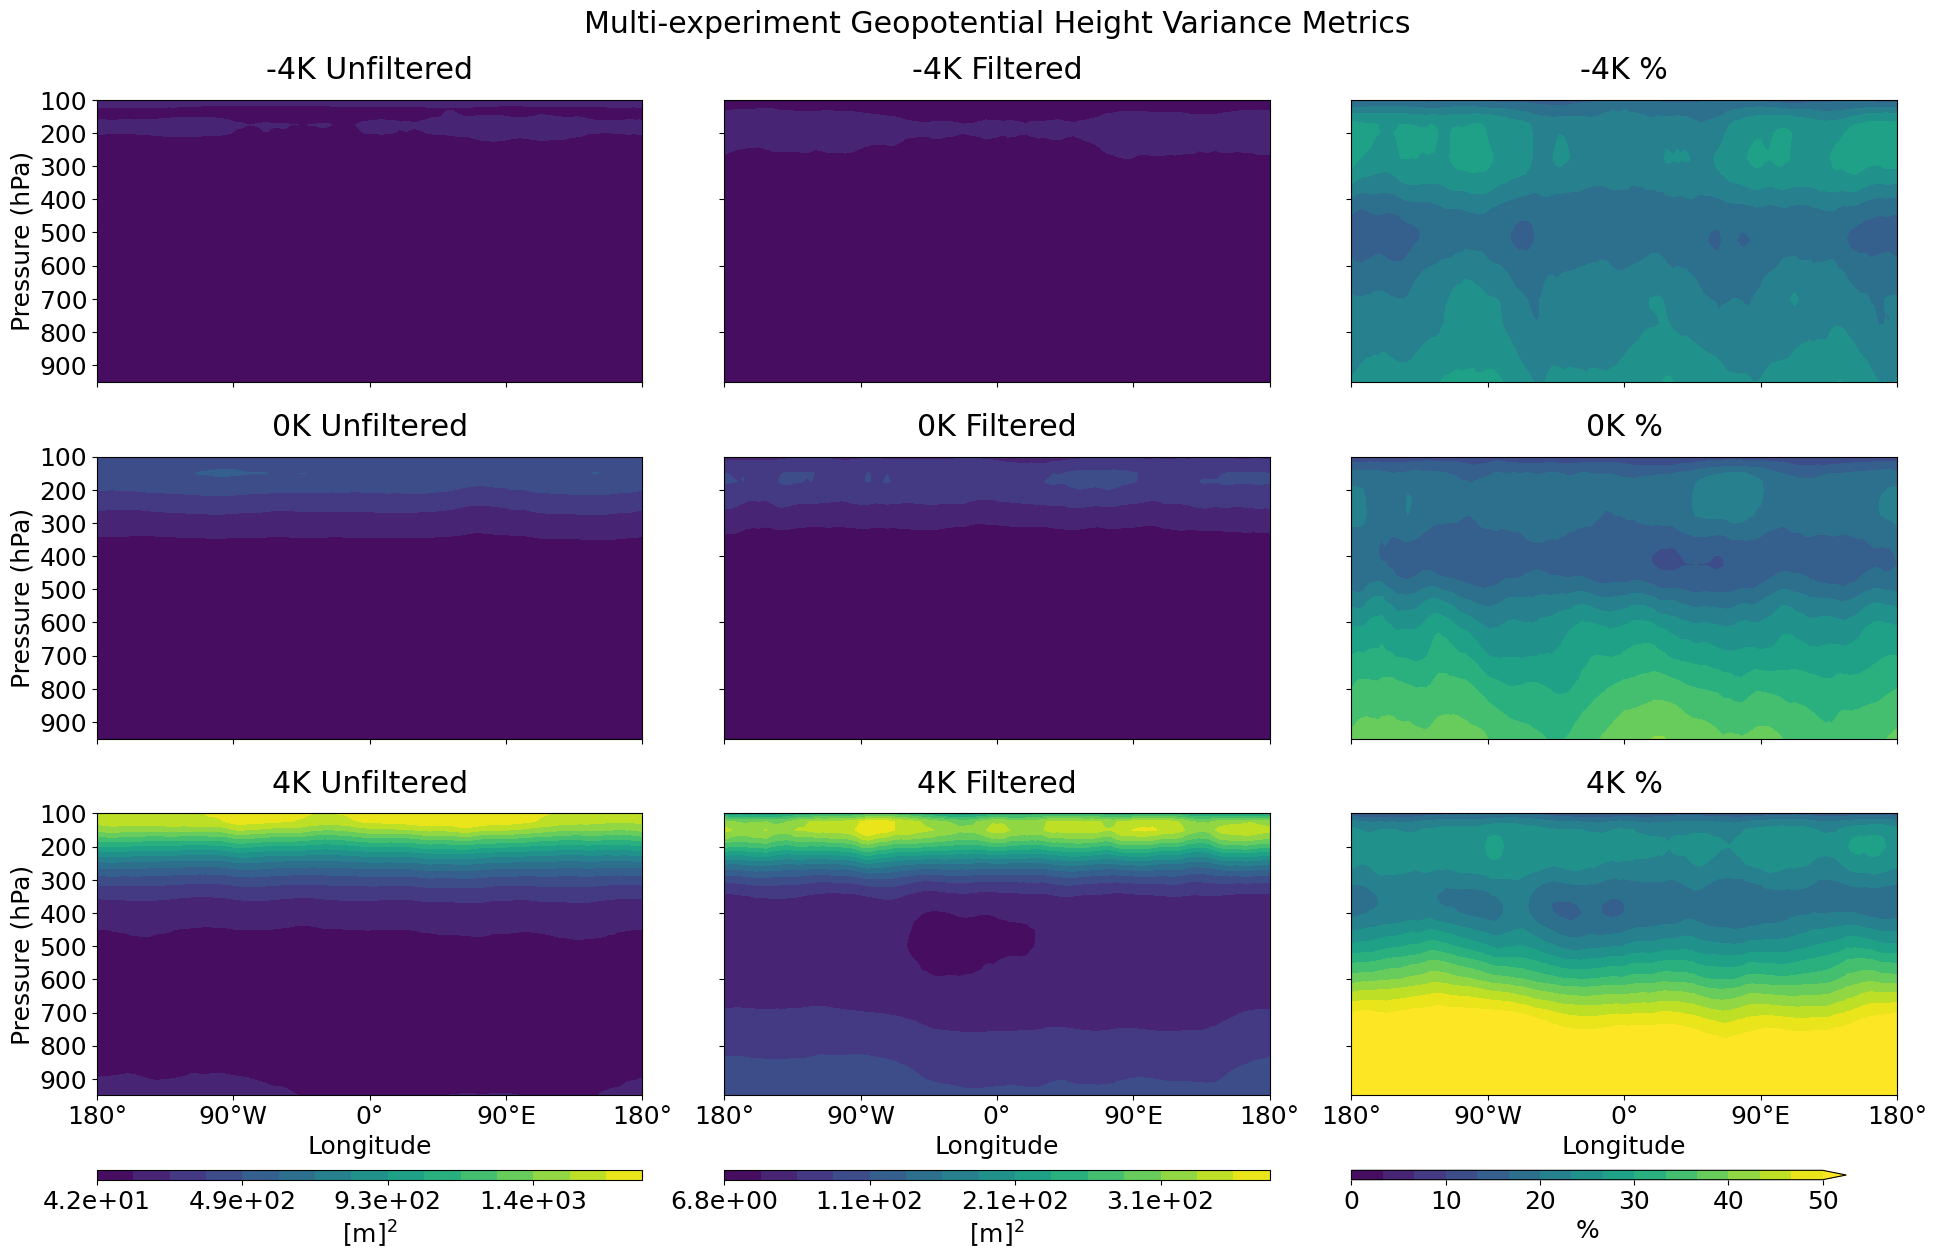

Variable: Moist Static Energy


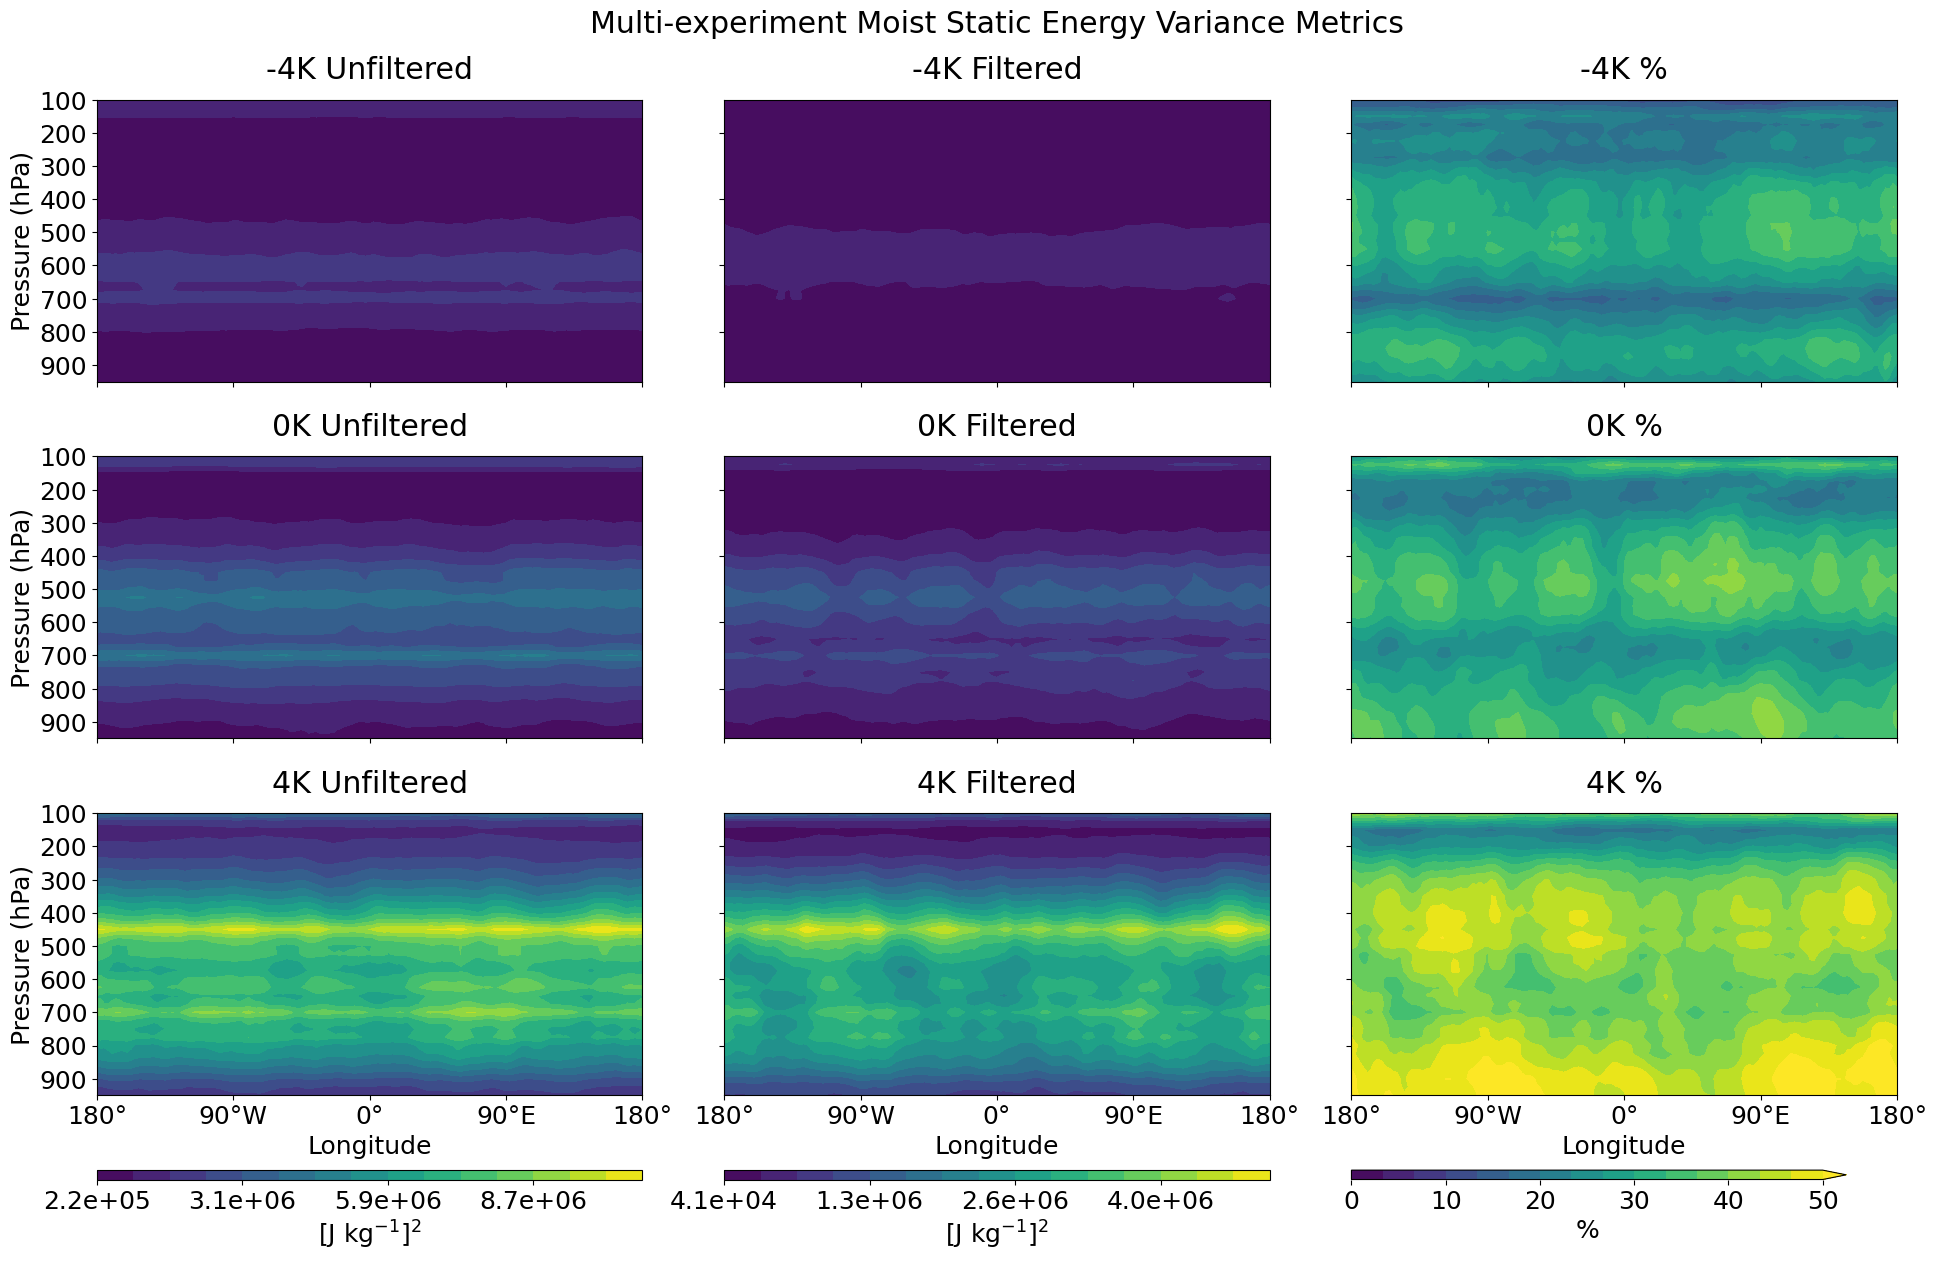

Variable: Longwave Heating Rate


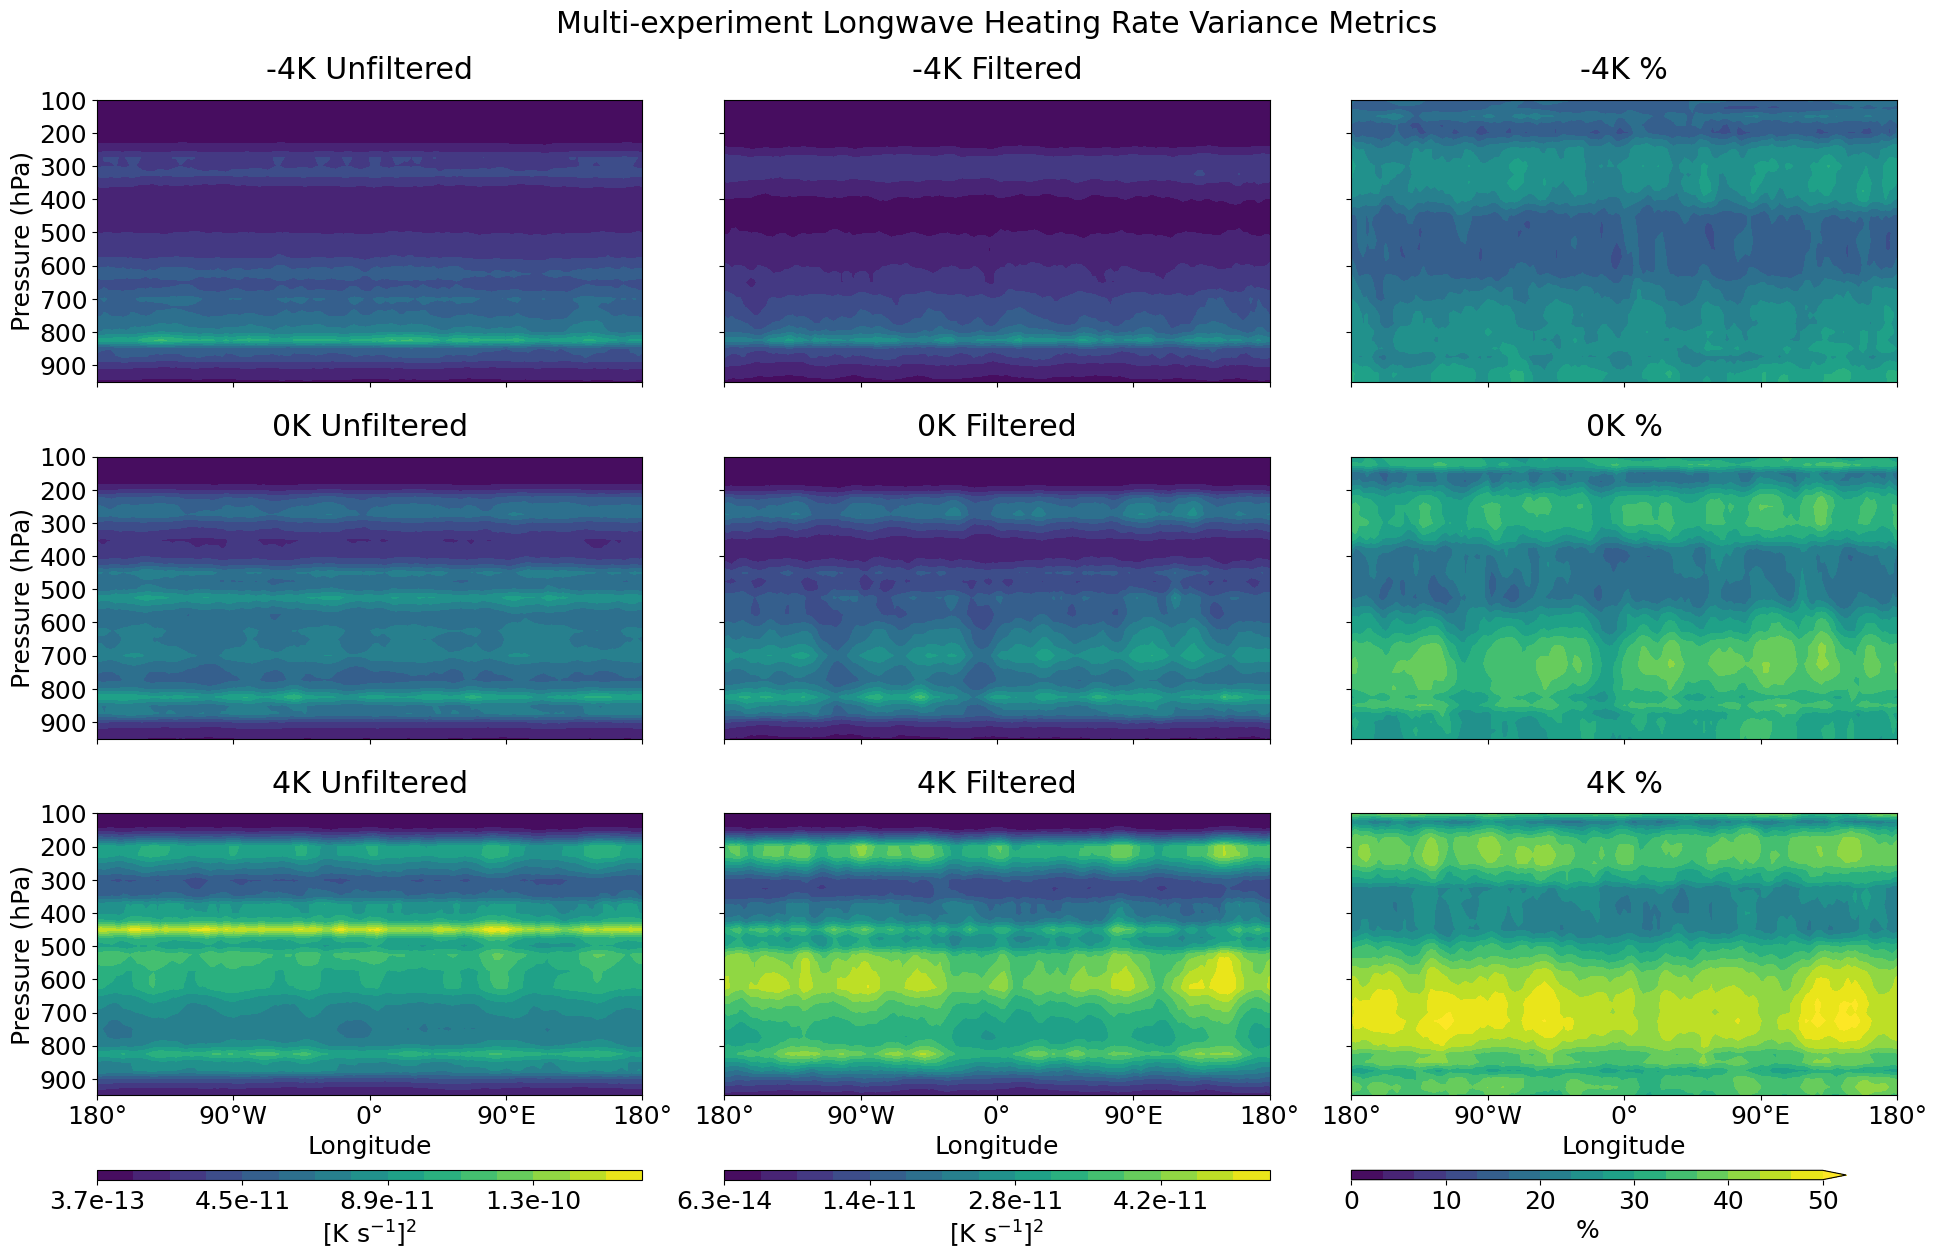

Variable: Shortwave Heating Rate


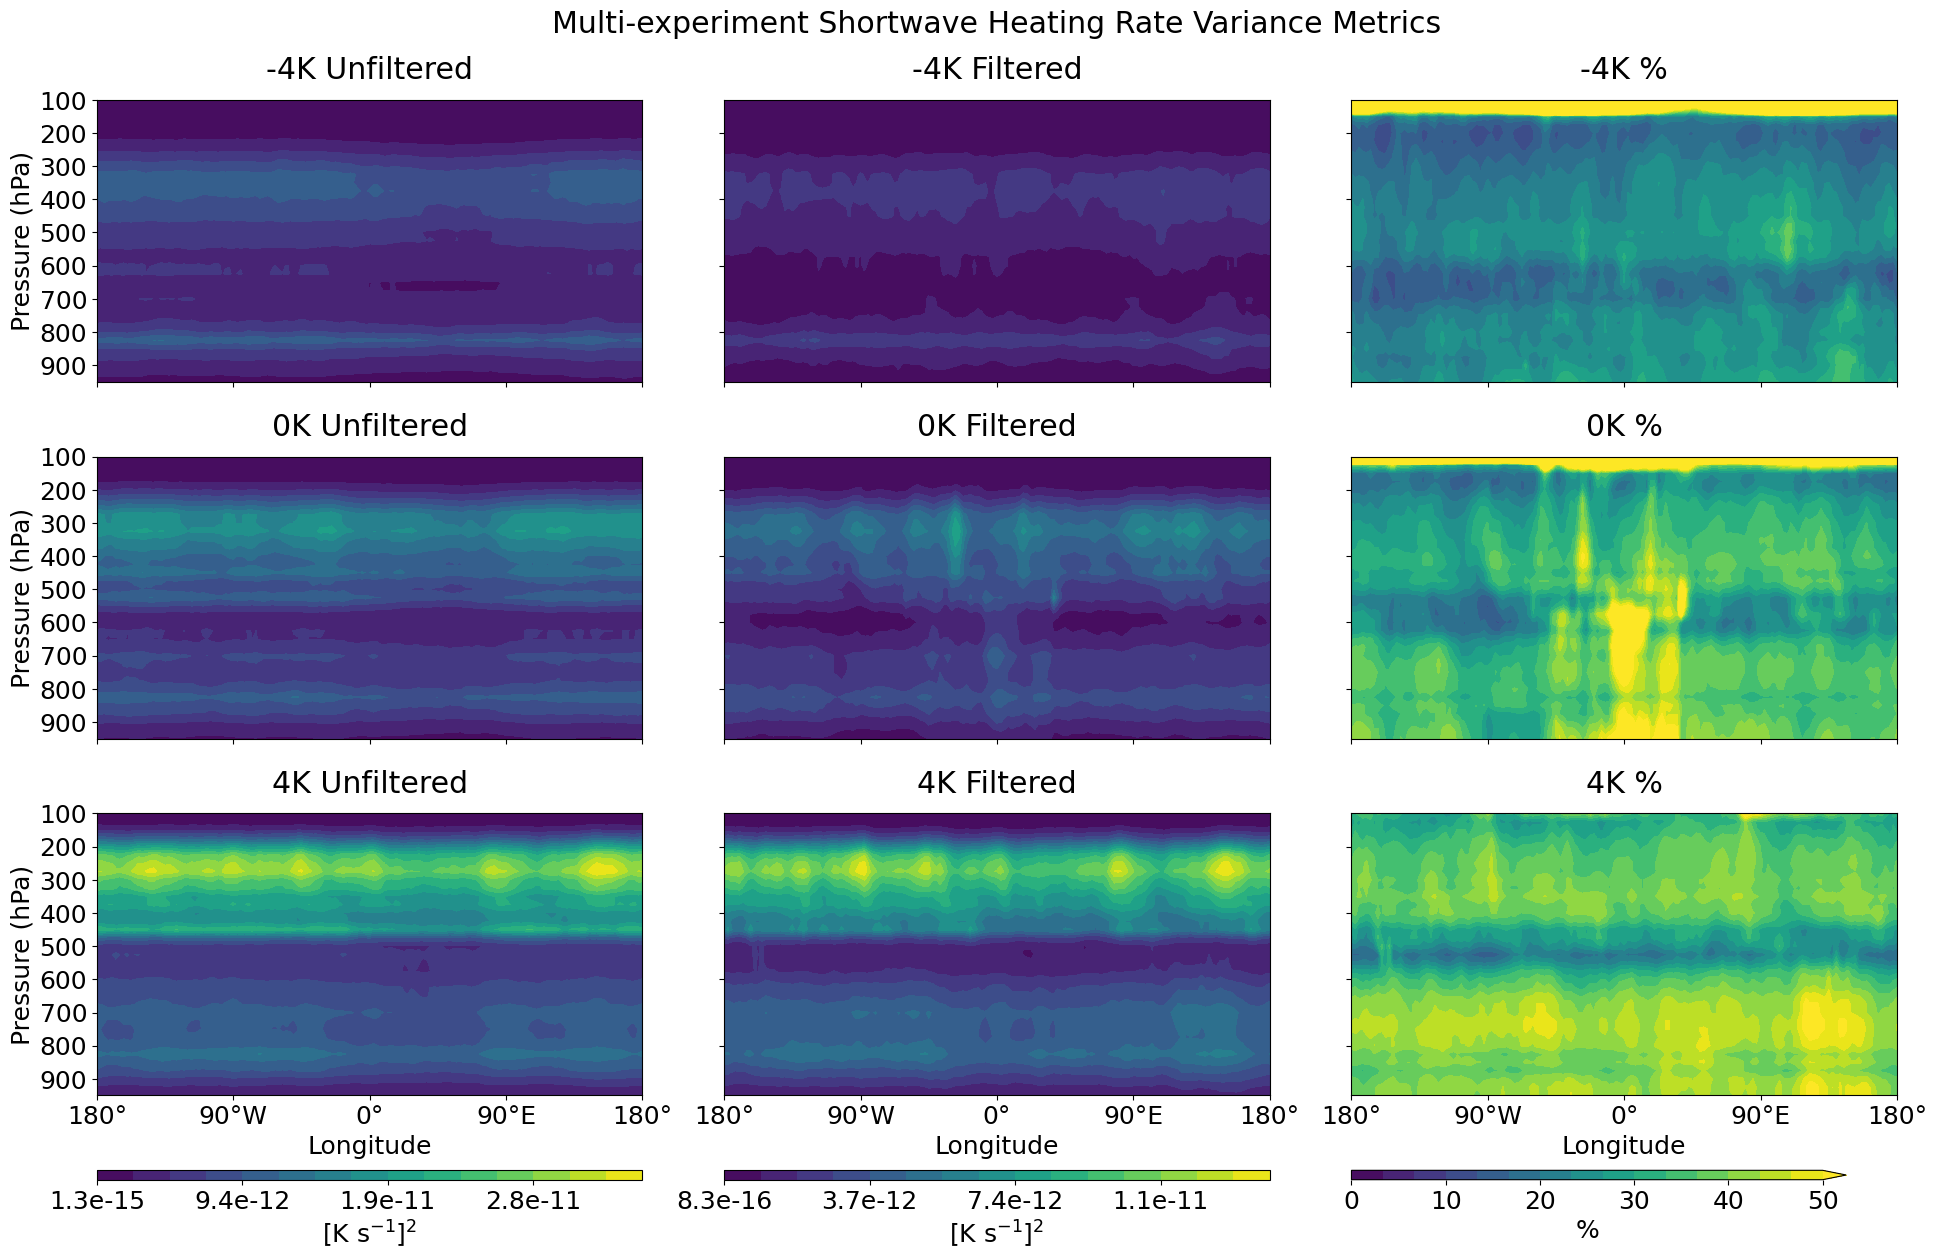

Finished


In [26]:
plt.style.use("default")
fontsize=18
plt.rcParams.update({"font.size": fontsize})

output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False

variables_to_plot = [
    multi_experiment_variables_subset['zonal wind'.title()],
    multi_experiment_variables_subset['meridional wind'.title()],
    multi_experiment_variables_subset['vertical wind'.title()],
    multi_experiment_variables_subset['temperature'.title()],
    multi_experiment_variables_subset['moisture'.title()],
    multi_experiment_variables_subset['geopotential height'.title()],
    multi_experiment_variables_subset['moist static energy'.title()],
    multi_experiment_variables_subset['longwave heating rate'.title()],
    multi_experiment_variables_subset['shortwave heating rate'.title()],
]

for variable in variables_to_plot:

    print(f"Variable: {variable.name}")

    unfiltered_data = multi_experiment_variables_subset[variable.name].sel(
        lat=meridional_mean_region
    ).mean(dim='lat').var(dim='time')
    filtered_data = multi_experiment_variables_filtered[variable.name].sel(
        lat=meridional_mean_region
    ).mean(dim='lat').var(dim='time')
    variance_percentage = 100*(filtered_data/unfiltered_data)

    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(4, 3, height_ratios=[30, 30, 30, 1], width_ratios=[1, 1, 1], figure=fig)
    gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.15)

    fig.suptitle(
        f"Multi-experiment"
        +f" {unfiltered_data.name} Variance Metrics",
        y=1.025
    )
    axes = {}
    cbar_axes = []
    cbar_axes.append(fig.add_subplot(gs[3, 0]))
    cbar_axes.append(fig.add_subplot(gs[3, 1]))
    cbar_axes.append(fig.add_subplot(gs[3, 2]))
    for experiment_index, experiment in enumerate(experiments_list):

        axes[experiment] = []
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 0]))
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 1]))
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 2]))

        # Plot unfiltered variance
        axes[experiment][0].set_title(f"{experiment} Unfiltered", pad=15)

        grand_max = unfiltered_data.max()
        grand_min = unfiltered_data.min()

        cdata, clon = cutil.add_cyclic_point(
            unfiltered_data.sel(experiment=experiment).T,
            coord=unfiltered_data.lon
        )

        # Plot data
        im0 = axes[experiment][0].contourf(
            clon,
            unfiltered_data.plev,
            cdata,
            cmap='viridis',
            levels=np.linspace(grand_min, grand_max, 16)
        )

        # Add colorbar
        cbar0 = fig.colorbar(
            im0,
            cax=cbar_axes[0],
            label=rf"[{unfiltered_data.attrs['units']}]$^2$",
            orientation="horizontal",
            format="%1.1e"
        )
        cbar0.ax.tick_params(labelsize=fontsize)
        cbar0.ax.locator_params(nbins=5)

        # Plot filtered variance
        axes[experiment][1].set_title(f"{experiment} Filtered", pad=15)

        grand_max = filtered_data.max()
        grand_min = filtered_data.min()
        # Add cyclic point

        cdata, clon = cutil.add_cyclic_point(
            filtered_data.sel(experiment=experiment).T,
            coord=filtered_data.lon
        )

        # Plot data
        im1 = axes[experiment][1].contourf(
            clon,
            filtered_data.plev,
            cdata,
            cmap='viridis',
            levels=np.linspace(grand_min, grand_max, 16)
        )

        # Add colorbar
        cbar1 = fig.colorbar(
            im1,
            cax=cbar_axes[1],
            label=rf"[{filtered_data.attrs['units']}]$^2$",
            orientation="horizontal",
            format="%1.1e"
        )
        cbar1.ax.tick_params(labelsize=fontsize)
        cbar1.ax.locator_params(nbins=5)

        # Plot variance percentage
        axes[experiment][2].set_title(f"{experiment} %", pad=15)

        cdata, clon = cutil.add_cyclic_point(
            variance_percentage.sel(experiment=experiment).T,
            coord=variance_percentage.lon
        )

        # Plot data
        im2 = axes[experiment][2].contourf(
            clon,
            variance_percentage.plev,
            cdata,
            cmap='viridis',
            levels=np.linspace(0, 50, 16),
            extend='max'
        )
        cbar2 = fig.colorbar(
            im2,
            cax=cbar_axes[2],
            label="%",
            orientation="horizontal",
        )
        cbar2.ax.tick_params(labelsize=fontsize)
        cbar2.ax.locator_params(nbins=7)

        for ax_index, ax in enumerate(axes[experiment]):

            # # Axis parameters
            # ax.set_aspect("auto")

            # ax.set_xlim(0, 360)
            # x_ticks = np.arange(0, 360 + 90, 90)
            # ax.set_xticks(x_ticks)
            # if experiment_index == 2:
            #     ax.set_xticklabels(tick_labeller(x_ticks-180, "lon"))
            #     # ax.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
            #     ax.set_xlabel("Longitude")
            # else:
            #     ax.set_xticklabels('')

            # ax.set_ylim(-30, 30)
            # y_ticks = np.arange(-30, 45, 15)
            # ax.set_yticks(y_ticks)
            # if ax_index == 0:
            #     ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
            #     ax.set_ylabel("Latitude")
            # else:
            #     ax.set_yticklabels('')

            # grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
            # ax.grid(True, **grid_kwargs)

            # Axis parameters
            ax.set_xlim(0, 360)
            x_ticks = np.arange(0, 360 + 90, 90)
            ax.set_xticks(x_ticks)
            if experiment_index == 2:
                ax.set_xticklabels(tick_labeller(x_ticks-180, "lon"))
                # ax.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
                ax.set_xlabel("Longitude")
            else:
                ax.set_xticklabels('')

            if ax_index == 0:
                ax.set_ylim(100, 950)
                ax.set_yticks(np.arange(100, 1000, 100))
                ax.set_ylabel("Pressure (hPa)")
            else:
                ax.set_yticklabels('')
            ax.invert_yaxis()

            ax.set_aspect('auto')

    if not savefig:
        plt.show()
    else:
        save_string = (
            f"{experiment}_unfiltered"
          + f"_{variable.attrs['file_id']}"
          + f"{((str(variable.plev.values)) if 'plev' in variable.coords else '')}_variance.png"
            )
        print(f"Saving plot as {save_string}")
        plt.savefig(
            f"{output_directory}/variance/latitude-longitude/unfiltered/{save_string}",
            dpi=500,
            bbox_inches="tight",
        )

print(f"{'='*40}")
print("Finished")

## Latitude-Height

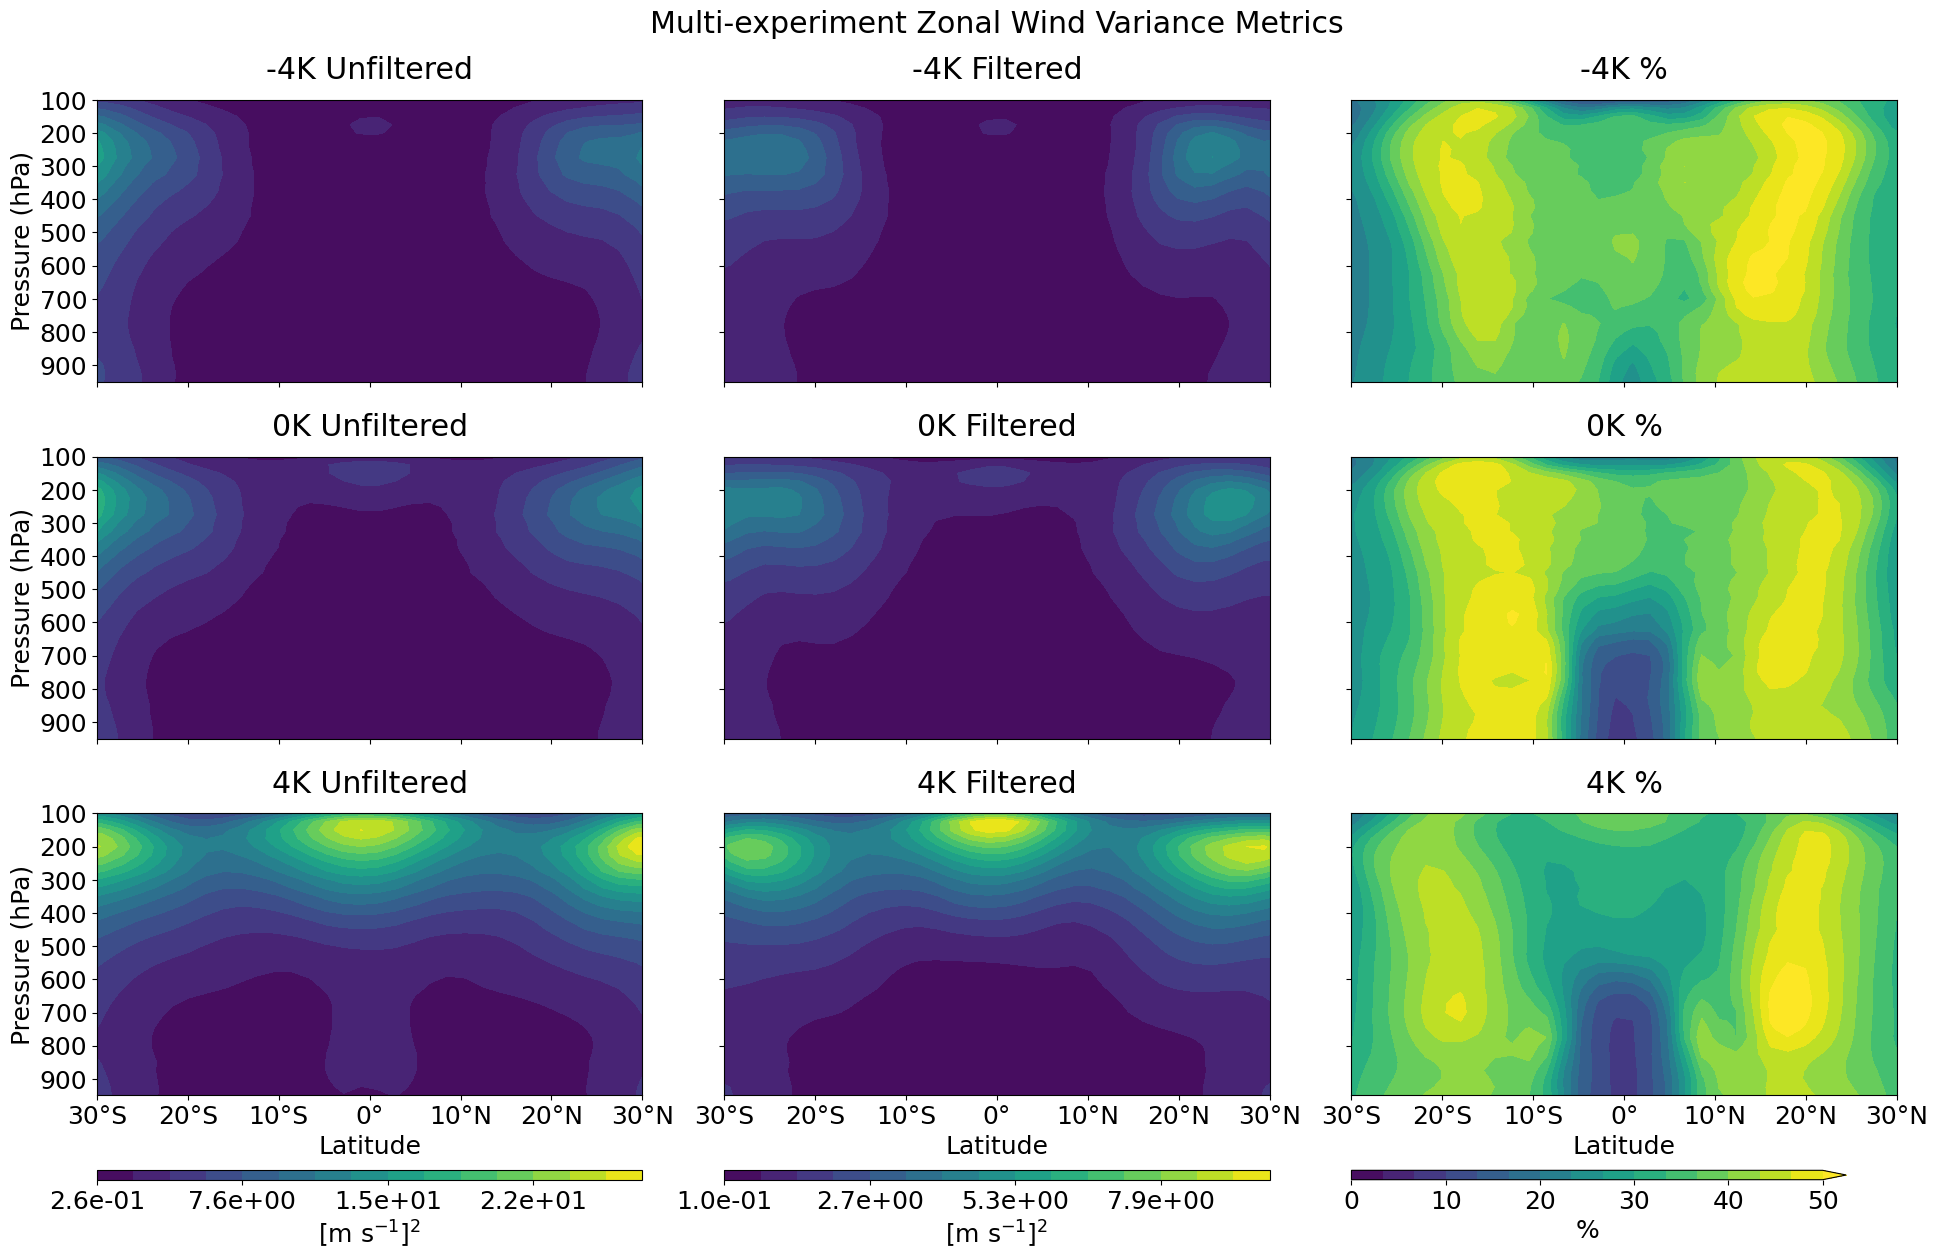

Finished


In [27]:
plt.style.use("default")
fontsize=18
plt.rcParams.update({"font.size": fontsize})

output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False

variables_to_plot = [
    multi_experiment_variables_subset['zonal wind'.title()],
    # multi_experiment_variables_subset['meridional wind'.title()],
    # multi_experiment_variables_subset['vertical wind'.title()],
    # multi_experiment_variables_subset['temperature'.title()],
    # multi_experiment_variables_subset['moisture'.title()],
    # multi_experiment_variables_subset['geopotential height'.title()],
    # multi_experiment_variables_subset['moist static energy'.title()],
    # multi_experiment_variables_subset['longwave heating rate'.title()],
    # multi_experiment_variables_subset['shortwave heating rate'.title()],
]

for variable in variables_to_plot:


    unfiltered_data = multi_experiment_variables_subset[variable.name].mean(dim='lon').var(dim='time')
    filtered_data = multi_experiment_variables_filtered[variable.name].mean(dim='lon').var(dim='time')
    variance_percentage = 100*(filtered_data/unfiltered_data)

    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(4, 3, height_ratios=[30, 30, 30, 1], width_ratios=[1, 1, 1], figure=fig)
    gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.15)

    fig.suptitle(
        f"Multi-experiment"
        +f" {unfiltered_data.name} Variance Metrics",
        y=1.025
    )
    axes = {}
    cbar_axes = []
    cbar_axes.append(fig.add_subplot(gs[3, 0]))
    cbar_axes.append(fig.add_subplot(gs[3, 1]))
    cbar_axes.append(fig.add_subplot(gs[3, 2]))
    for experiment_index, experiment in enumerate(experiments_list):

        axes[experiment] = []
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 0]))
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 1]))
        axes[experiment].append(fig.add_subplot(gs[experiment_index, 2]))

        # Plot unfiltered variance
        axes[experiment][0].set_title(f"{experiment} Unfiltered", pad=15)

        grand_max = unfiltered_data.max()
        grand_min = unfiltered_data.min()

        # Plot data
        im0 = axes[experiment][0].contourf(
            unfiltered_data.lat,
            unfiltered_data.plev,
            unfiltered_data.sel(experiment=experiment).T,
            cmap='viridis',
            levels=np.linspace(grand_min, grand_max, 16)
        )

        # Add colorbar
        cbar0 = fig.colorbar(
            im0,
            cax=cbar_axes[0],
            label=rf"[{unfiltered_data.attrs['units']}]$^2$",
            orientation="horizontal",
            format="%1.1e"
        )
        cbar0.ax.tick_params(labelsize=fontsize)
        cbar0.ax.locator_params(nbins=5)

        # Plot filtered variance
        axes[experiment][1].set_title(f"{experiment} Filtered", pad=15)

        grand_max = filtered_data.max()
        grand_min = filtered_data.min()

        # Plot data
        im1 = axes[experiment][1].contourf(
            filtered_data.lat,
            filtered_data.plev,
            filtered_data.sel(experiment=experiment).T,
            cmap='viridis',
            levels=np.linspace(grand_min, grand_max, 16)
        )

        # Add colorbar
        cbar1 = fig.colorbar(
            im1,
            cax=cbar_axes[1],
            label=rf"[{filtered_data.attrs['units']}]$^2$",
            orientation="horizontal",
            format="%1.1e"
        )
        cbar1.ax.tick_params(labelsize=fontsize)
        cbar1.ax.locator_params(nbins=5)

        # Plot variance percentage
        axes[experiment][2].set_title(f"{experiment} %", pad=15)

        # Plot data
        im2 = axes[experiment][2].contourf(
            variance_percentage.lat,
            variance_percentage.plev,
            variance_percentage.sel(experiment=experiment).T,
            cmap='viridis',
            levels=np.linspace(0, 50, 16),
            extend='max'
        )
        cbar2 = fig.colorbar(
            im2,
            cax=cbar_axes[2],
            label="%",
            orientation="horizontal",
        )
        cbar2.ax.tick_params(labelsize=fontsize)
        cbar2.ax.locator_params(nbins=7)

        for ax_index, ax in enumerate(axes[experiment]):

            # Axis parameters
            ax.set_xlim(-30, 30)
            x_ticks = np.arange(-30, 30+10, 10)
            ax.set_xticks(x_ticks)
            if experiment_index == 2:
                ax.set_xticklabels(tick_labeller(x_ticks, "lat"))
                # ax.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
                ax.set_xlabel("Latitude")
            else:
                ax.set_xticklabels('')

            if ax_index == 0:
                ax.set_ylim(100, 950)
                ax.set_yticks(np.arange(100, 1000, 100))
                ax.set_ylabel("Pressure (hPa)")
            else:
                ax.set_yticklabels('')
            ax.invert_yaxis()

            ax.set_aspect('auto')

    if not savefig:
        plt.show()
    else:
        save_string = (
            )
        print(f"Saving plot as {save_string}")
        plt.savefig(
            f"{output_directory}/variance/latitude-longitude/unfiltered/{save_string}",
            dpi=500,
            bbox_inches="tight",
        )

print(f"{'='*40}")
print("Finished")

# Time Series Power Spectra

## Calculate power spectra

### Fit Red Spectrum

In [99]:
def calculate_red_spectrum(frequency, autocorrelation):
    red_spectrum = (1 - autocorrelation**2) / (
        1 - (2 * autocorrelation * np.cos(frequency * 2 * np.pi)) + autocorrelation**2
    )
    return red_spectrum

In [96]:
variable_frequency = {}
variable_power_spectrum = {}

window_size = 256
segment_length_degrees = 20
segment_length = int(segment_length_degrees * (1/2.5))
overlap = 0

weights = np.cos(np.deg2rad(latitude))
weights.name = "weights"

variables_to_plot = [
    multi_experiment_variables_subset['Precipitation'],
    multi_experiment_variables_subset['Outgoing Longwave Radiation'],
    multi_experiment_variables_subset['Zonal Wind'].sel(plev=200),
    multi_experiment_variables_subset['Zonal Wind'].sel(plev=850),
    # multi_experiment_variables_subset['vertical wind'].sel(plev=500),
    # multi_experiment_variables_subset['column temperature'],
    # multi_experiment_variables_subset['column water vapor'],
]

print("Calculating power spectra...")
print(f"{'='*40}")
# for variable in variables_subset:
for variable in variables_to_plot:
    variable_id = f"{variable.attrs['file_id']}{(str(variable.plev.values) if 'plev' in variable.coords else '')}"
    print(f"----> {variable_id}")


    meridional_mean_time_series = variable.sel(lat=slice(-10,10)).weighted(weights).mean(dim='lat')
    meridional_mean_time_series = meridional_mean_time_series.rolling(
            lon=segment_length, center=False
        ).construct("index")[:, :, (segment_length-1):][:, :, ::(segment_length-overlap)].transpose("experiment", "time", "lon", "index").mean(dim="index")

    time_axis = meridional_mean_time_series.get_axis_num('time')
    experiment_axis = meridional_mean_time_series.get_axis_num('experiment')
    lon_axis = meridional_mean_time_series.get_axis_num('lon')

    detrended_time_series = xr.zeros_like((meridional_mean_time_series))
    detrended_time_series[:] = signal.detrend(meridional_mean_time_series, type="linear", axis=time_axis)

    [time_series_frequency, time_series_power_spectrum] = signal.welch(
        detrended_time_series.values,
        nperseg=window_size,
        noverlap=window_size // 2,
        fs=1,
        axis=time_axis
    )

    variable_power_spectrum[variable_id] = xr.DataArray(
        data=np.mean(time_series_power_spectrum, axis=lon_axis),
        dims=["experiment", "frequency"],
        coords=dict(
            experiment=experiments_list,
            frequency=time_series_frequency
        ),
        attrs=dict(
            plev=(variable.plev.values if 'plev' in variable.coords else '')
        )
    )
    variable_power_spectrum[variable_id].name = variable.name
    variable_power_spectrum[variable_id].attrs['units'] = variable.attrs['units']
    variable_power_spectrum[variable_id].attrs['time series variance'] = {
        experiment:detrended_time_series.sel(experiment=experiment).var().values
        for experiment in experiments_list
    }
    variable_power_spectrum[variable_id].attrs['integrated spectral variance'] = {
        experiment:scipy.integrate.simpson(
            variable_power_spectrum[variable_id].sel(experiment=experiment),
            x=variable_power_spectrum[variable_id].frequency
        )
        for experiment in experiments_list
    }

Calculating power spectra...
----> PRCP
----> OLR
----> U200
----> U850


## Plot power spectra

PRCP


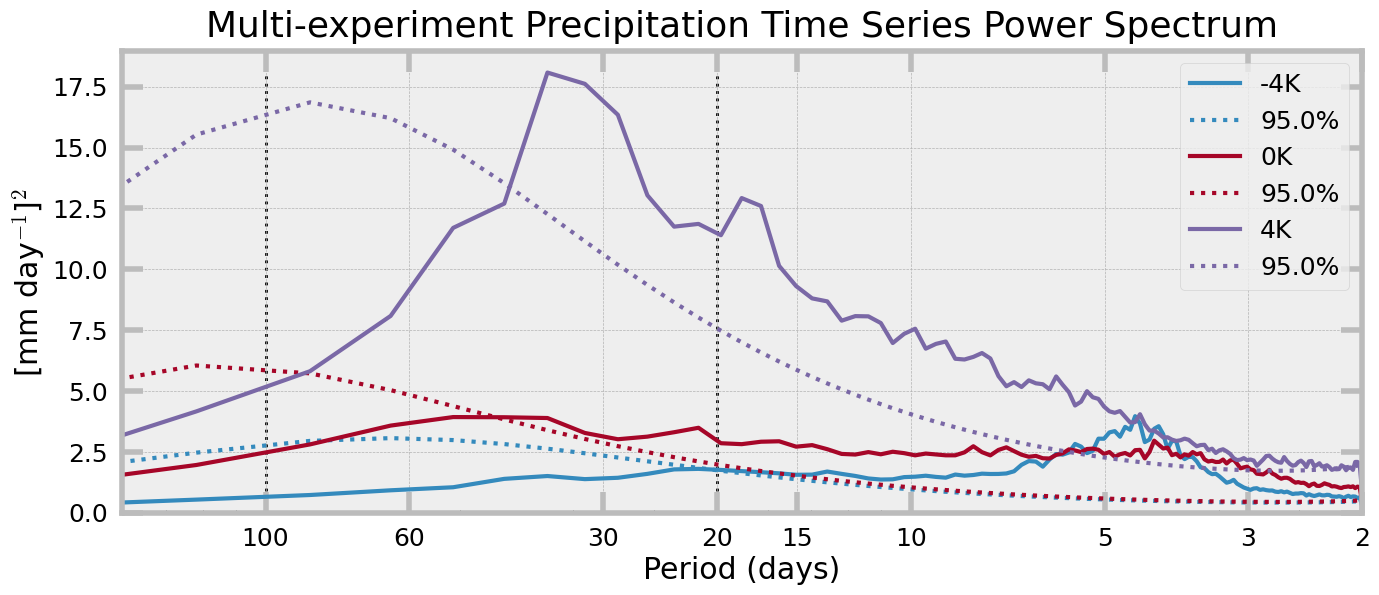

OLR


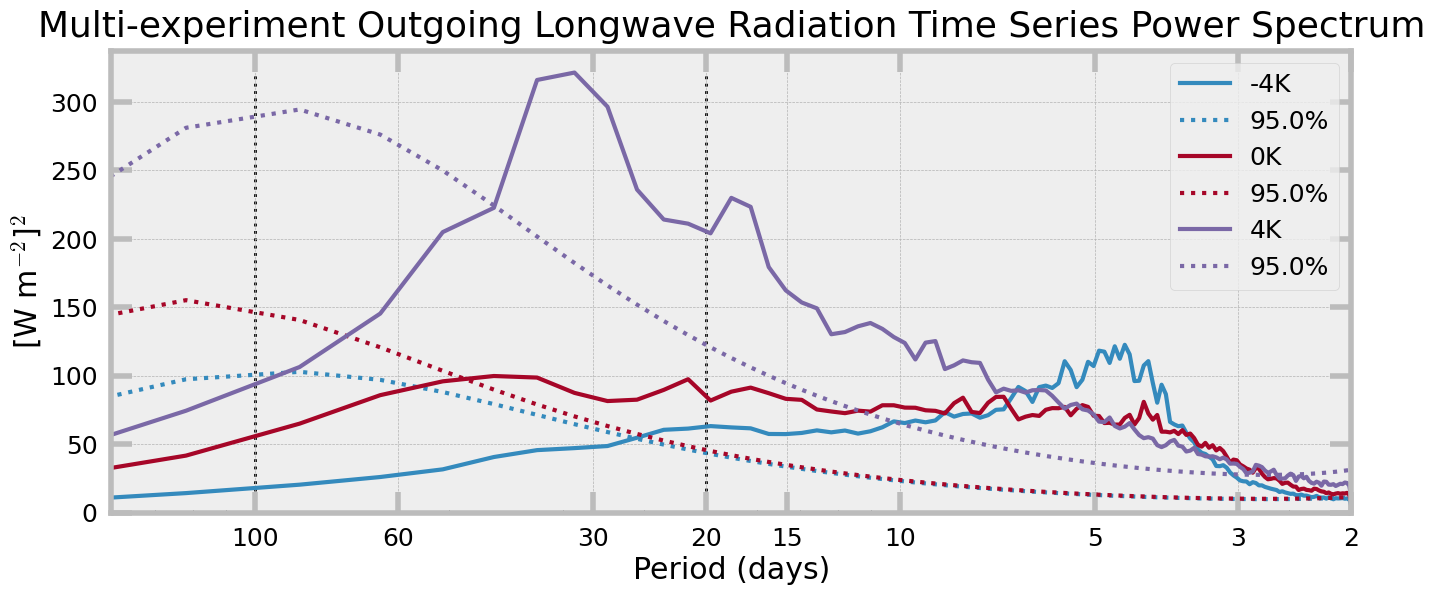

U200


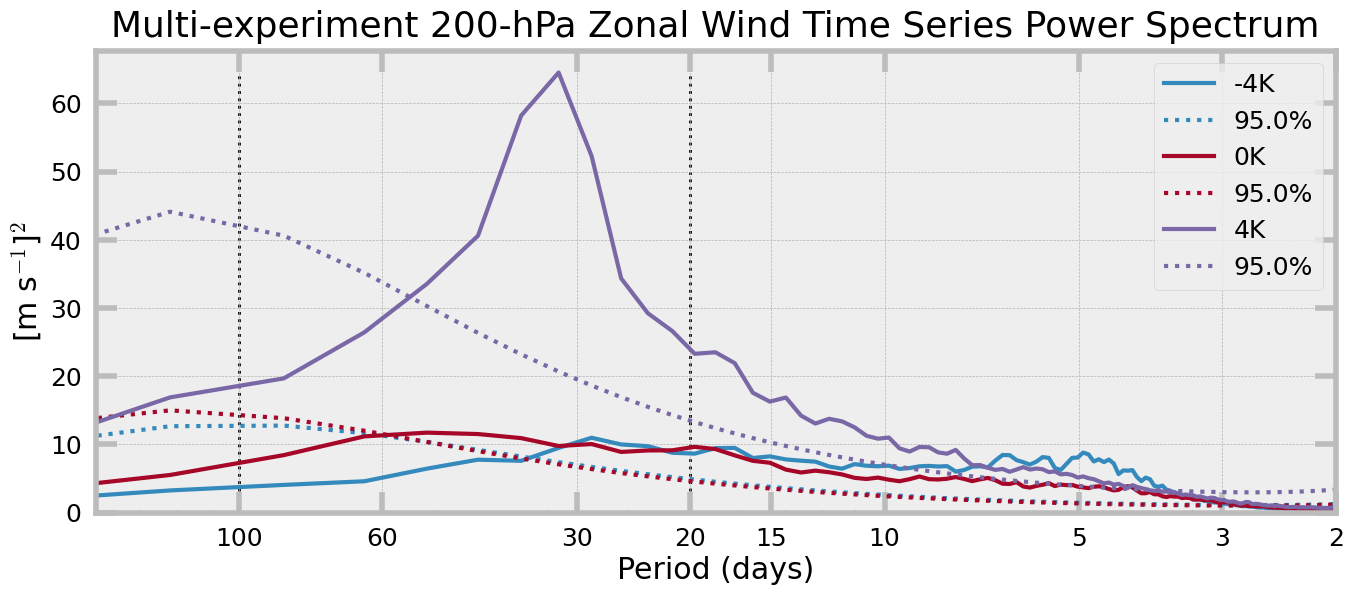

U850


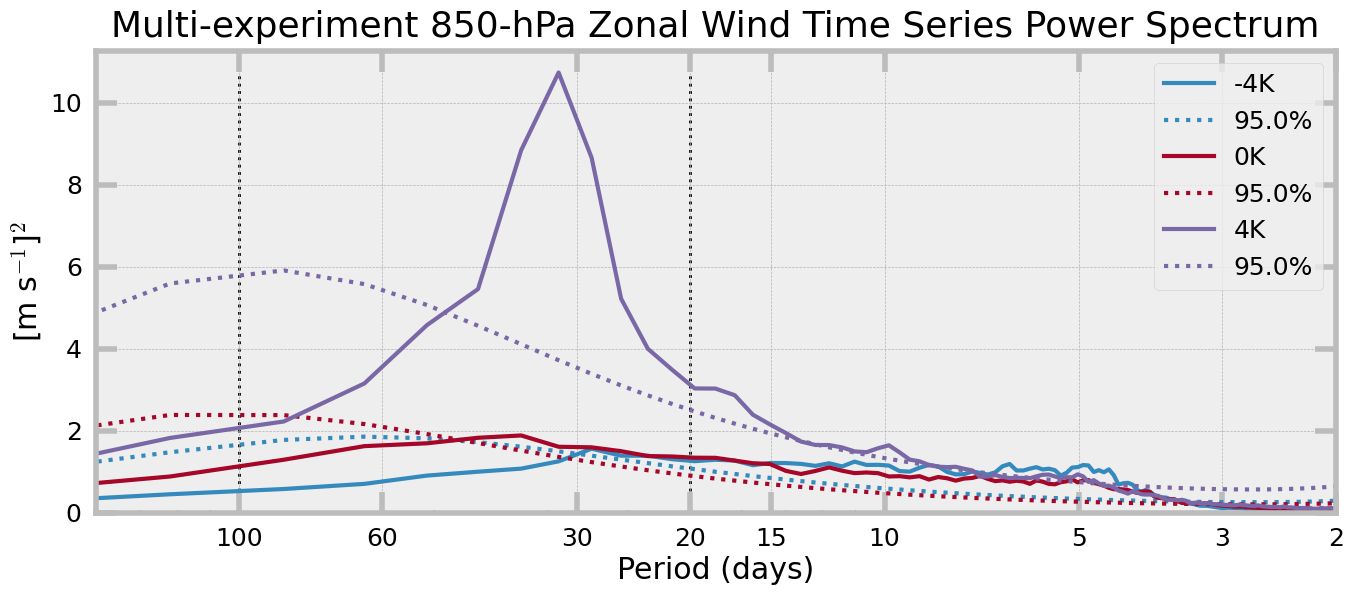

Finished


In [126]:
# Set plotting parameters
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False

p_critical_list = [0.95]

linestyle = {}
linestyle[0.9] = '--'
linestyle[0.95] = ':'

plt.style.use("bmh")
plt.rcParams.update({"font.size": 18})

periods = np.array([100, 60, 30, 20, 15, 10, 5, 3, 2])
frequency_from_period = 1 / periods

red_noise_parameters = {}
variable_covariance = {}
variable_red_spectrum = {}
f_critical = {}

# Estimate degrees of freedom
degrees_of_freedom_numerator = 2 * len(time) / window_size
degrees_of_freedom_denominator = len(time) // 2

for p_critical in p_critical_list:
    f_critical[p_critical] = scipy.stats.f.ppf(
        p_critical, degrees_of_freedom_numerator, degrees_of_freedom_denominator
    )

# p_critical = 0.95
p_critical = 0.95
for variable_id, variable in variable_power_spectrum.items():
    print(variable_id)

    variable_red_spectrum[variable_id] = xr.zeros_like((variable_power_spectrum[variable_id]))

    [fig, ax] = plt.subplots(1, 1, figsize=(16, 6))
    ax.set_title(
        f"Multi-experiment "
        + f"{((str(variable.attrs['plev']) + '-hPa ') if variable.attrs['plev'] != '' else '')}"
        + f"{variable.name} Time Series Power Spectrum",
        pad=10
    )

    for experiment_index, experiment in enumerate(experiments_list):

        [
        red_noise_parameters[variable_id],
         variable_covariance[variable_id]
        ] = curve_fit(
                calculate_red_spectrum,
                variable_power_spectrum[variable_id].frequency,
                variable_power_spectrum[variable_id].sel(experiment=experiment),
                p0=(0.5),
            )

        variable_red_spectrum[variable_id][:] = calculate_red_spectrum(
            variable_power_spectrum[variable_id].frequency,
            red_noise_parameters[variable_id][0]
        )

        red_variance = scipy.integrate.simpson(
            variable_red_spectrum[variable_id].sel(experiment=experiment),
            x=variable_power_spectrum[variable_id].frequency
        )



        ax.plot(
            variable_power_spectrum[variable_id].frequency,
            variable_power_spectrum[variable_id].sel(experiment=experiment).frequency*variable_power_spectrum[variable_id].sel(experiment=experiment),
            lw=3,
            label=experiment
        )

        # ax.plot(
        #     variable_power_spectrum[variable_id].frequency,
        #     (
        #         variable_power_spectrum[variable_id].attrs['integrated spectral variance'][experiment]/red_variance
        #     ) * variable_power_spectrum[variable_id].frequency*variable_red_spectrum[variable_id],
        #     color=bmh_colors(experiment_index+1),
        #     lw=3,
        #     ls='--'
        #     # label='Red Spectrum'
        # )

        ax.plot(
            variable_power_spectrum[variable_id].frequency,
            f_critical[p_critical] * (
                variable_power_spectrum[variable_id].attrs['integrated spectral variance'][experiment]/red_variance
        ) * variable_power_spectrum[variable_id].frequency*variable_red_spectrum[variable_id].sel(experiment=experiment),
            color=bmh_colors(experiment_index+1),
            ls=linestyle[p_critical],
            label=f"{100*p_critical}%",
            lw=3
        )

    ax.legend()
    ax.set_aspect('auto')
    ax.set_xscale('log')
    ax.set_xlim(1 / 167, 1 / 2)
    ax.set_ylim(bottom=0)
    ax.axvline(x=1/100, c='k', ls=':', zorder=-10)
    ax.axvline(x=1/20, c='k', ls=':', zorder=-10)
    ax.set_ylabel(rf"[{variable.attrs['units']}]$^2$")
    ax.set_xticks(ticks=frequency_from_period)
    ax.xaxis.set_major_formatter(mticker.FixedFormatter(periods))
    ax.set_xlabel("Period (days)")
    ax.legend(loc='upper right')

    for edge in ["top", "bottom", "left", "right"]:
        ax.spines[edge].set_linewidth(4)
    ax.tick_params(
        which="major",
        axis="both",
        direction="in",
        top=True,
        right=True,
        width=4,
        length=15,
        color="#bcbcbc",
        pad=10,
    )

    if not savefig:
        plt.show()
    else:
        save_string = (
            f"{experiment}"
          + f"_{variable_id}"
         # + f"_{variable.attrs['file_id']}"
          # + f"{((str(variable.plev.values)) if 'plev' in variables_subset[variable.name.lower()].coords else '')}"
          + f"_time-series-power-spectrum.png"

            )
        print(f"Saving plot as {save_string}")
        plt.savefig(
            f"{output_directory}/time-series-power-spectra/{save_string}",
            dpi=500,
            bbox_inches="tight",
        )

print(f"{'='*40}")
print("Finished")

# Hovmoller

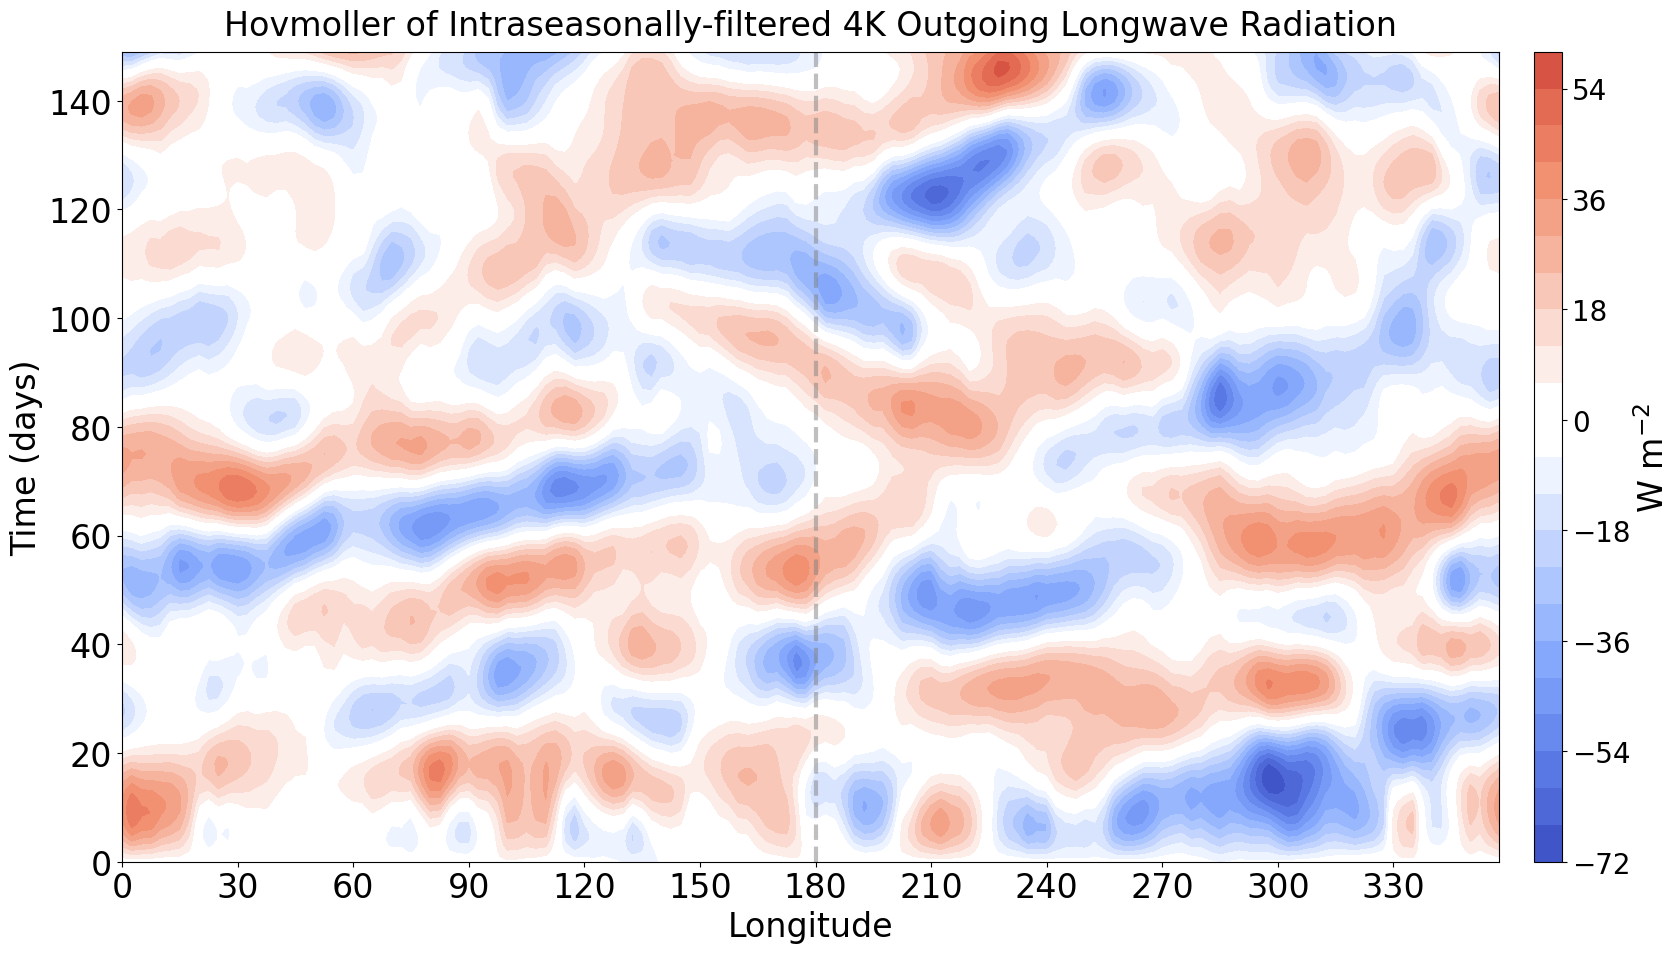

In [147]:
variable = "outgoing longwave radiation"

plt.style.use("default")
plt.rcParams.update({"font.size": 24})

# Create figure and gridpsec
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(1, 2, width_ratios=[100, 2])
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05)

# Specify axes
ax = fig.add_subplot(gs[0])
cbar_ax = fig.add_subplot(gs[1])

# Label plot
ax.set_title(
    f"Hovmoller of Intraseasonally-filtered {experiment} {variables_filtered[variable].name}",
    fontsize=24,
    pad=12,
)

# Plot data
im = ax.contourf(
    longitude,
    np.arange(len(time))[:150],
    variables_filtered["outgoing longwave radiation"].sel(lat=slice(-10, 10)).mean(dim="lat")[:150],
    cmap=mjo.modified_colormap("coolwarm", "white", 0.05, 0.5),
    norm=mcolors.CenteredNorm(),
    levels=21
)

# Add colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(variables_filtered[variable].attrs["units"])

# Add line at 180°
ax.axvline(x=180, color="gray", lw=3, ls="--", alpha=0.5)

# Configure axes
ax.set_xticks(np.arange(0, 360, 30))
ax.set_aspect("auto")
ax.set_xlabel("Longitude")
ax.set_ylabel("Time (days)")

plt.show()
# plt.savefig(
#     f"{output_directory}/hovmoller_intraseasonally_filtered_precipitation_30S-30N.png",
#     dpi=300,
#     bbox_inches='tight'
# )